In [25]:
!git clone --recursive https://github.com/Microsoft/LightGBM
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
import warnings
warnings.filterwarnings(action='ignore')
from xgboost import XGBRegressor
!pip install catboost
import catboost

import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer,QuantileTransformer ,LabelEncoder, OneHotEncoder, MinMaxScaler, OrdinalEncoder, RobustScaler
import seaborn as sns
! pip install prince
import prince

! pip install optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

fatal: destination path 'LightGBM' already exists and is not an empty directory.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory:

In [27]:
path = '/content/drive/Shareddrives/dacon/Playground/'
train = pd.read_csv(path + 'train.csv', index_col=['id'])
test = pd.read_csv(path + 'test.csv', index_col=['id'])
submission = pd.read_csv(path + 'sample_submission.csv', index_col=['id'])

In [28]:
cat_features = [feature for feature in train.columns if 'cat' in feature]
cont_features = [feature for feature in train.columns if 'cont' in feature]

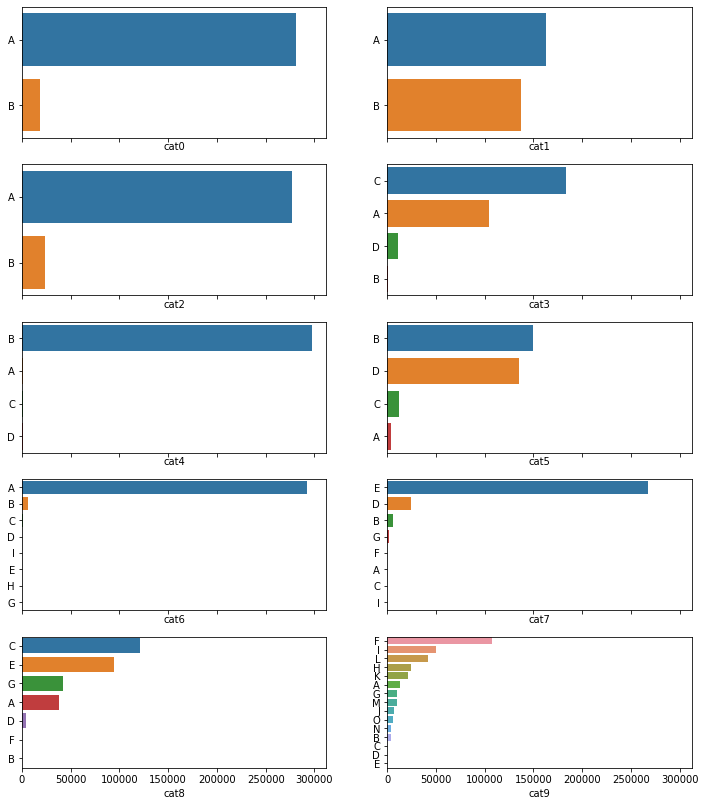

In [29]:
idx = 0
f, axes = plt.subplots(5,2,sharex = True, figsize = (12,14))

for row in range(5):
  for col in range(2):
    data = train[cat_features[idx]].value_counts()
    ax = sns.barplot(x = data.values, y =data.index, ax = axes[row, col])
    ax.set(xlabel = cat_features[idx])
    idx += 1

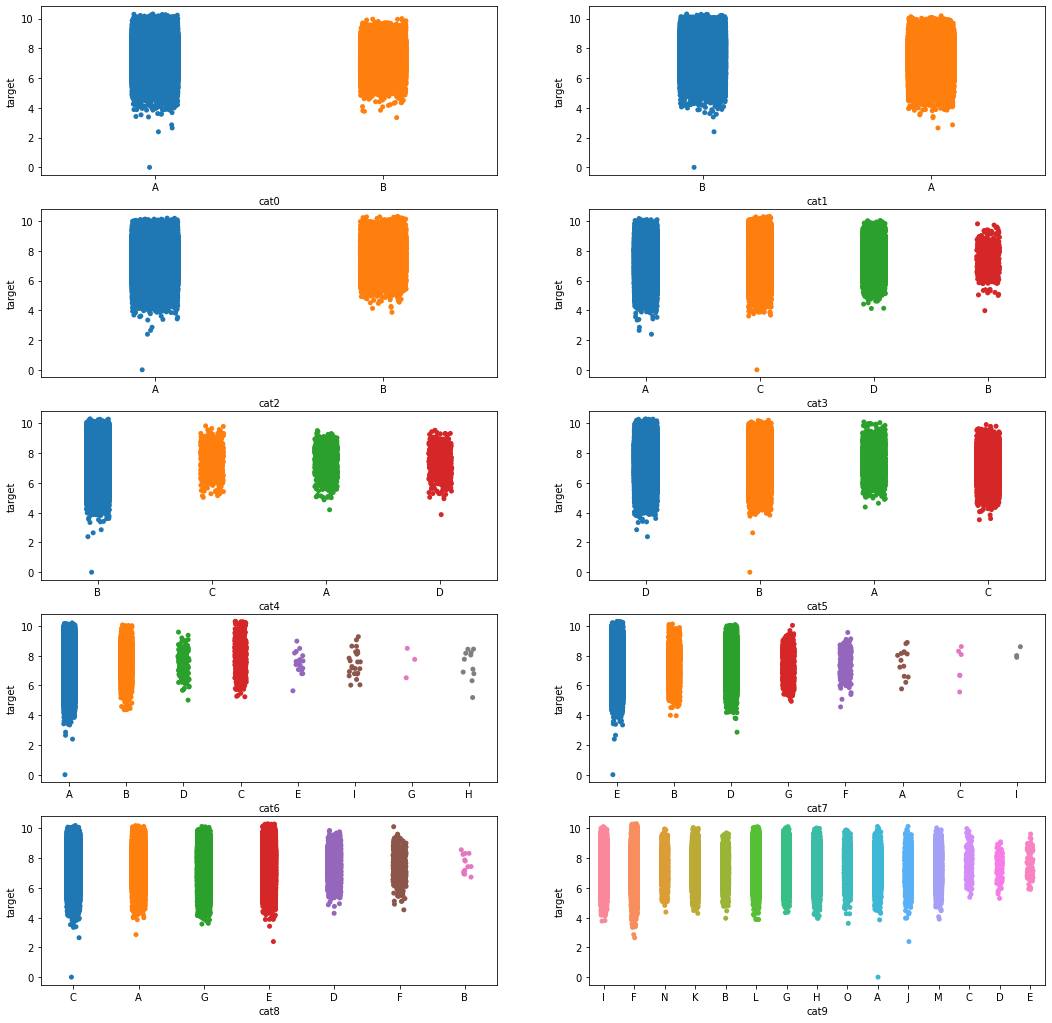

In [30]:
idx = 0
f, axes = plt.subplots(5,2, figsize = (18,18))

for row in range(5):
  for col in range(2):
    sns.stripplot(x = cat_features[idx], y = 'target', data = train, ax = axes[row, col])
    idx += 1

In [31]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

In [32]:
train

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
2,B,A,A,A,B,B,A,E,A,F,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
3,A,A,A,C,B,D,A,B,C,N,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
4,A,A,A,C,B,D,A,E,G,K,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
6,A,B,A,A,B,B,A,E,C,F,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,A,B,A,C,B,B,A,E,E,L,0.260716,0.712438,0.161661,0.442794,0.768447,0.269578,0.258655,0.363598,0.300619,0.340516,0.235711,0.383477,0.215227,0.793630,8.343538
499996,A,B,A,C,B,B,A,E,E,L,0.173302,0.121591,0.592514,0.193711,0.775951,0.197211,0.257024,0.574304,0.227035,0.322583,0.286094,0.324874,0.306933,0.230902,7.851861
499997,A,B,A,C,B,B,A,E,C,M,0.342856,0.617869,0.462991,0.418098,0.297406,0.449482,0.386172,0.476217,0.135947,0.502730,0.235788,0.316671,0.250286,0.349041,7.600558


######### cat0 ############
2.878678917081735e-193
######### cat1 ############
0.0
######### cat2 ############
0.0
######### cat3 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.0747 0.1608 -0.0177  0.1671  False
     A      C   0.1155  0.001  0.1067  0.1243   True
     A      D   0.0634  0.001  0.0407   0.086   True
     B      C   0.0408 0.6477 -0.0515  0.1331  False
     B      D  -0.0113    0.9 -0.1059  0.0833  False
     C      D  -0.0521  0.001 -0.0743 -0.0299   True
----------------------------------------------------


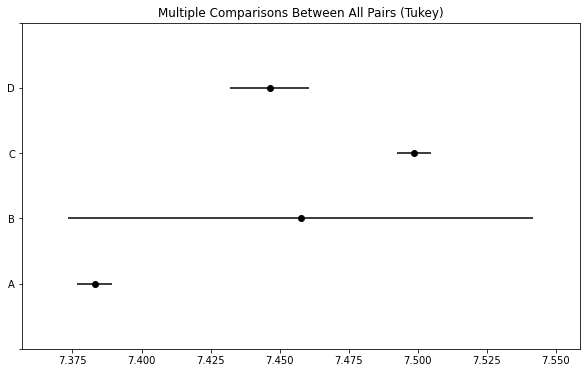

######### cat4 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     A      B  -0.0094   0.9 -0.0742 0.0555  False
     A      C   0.2009 0.001  0.0962 0.3056   True
     A      D  -0.0292   0.9 -0.1414 0.0829  False
     B      C   0.2102 0.001  0.1278 0.2927   True
     B      D  -0.0199   0.9 -0.1116 0.0718  False
     C      D  -0.2301 0.001 -0.3533 -0.107   True
--------------------------------------------------


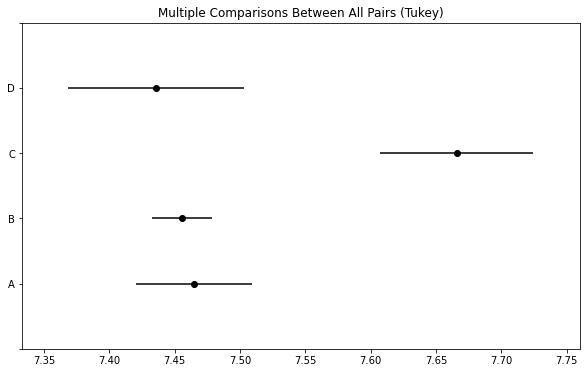

######### cat5 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B    0.022 0.4215  -0.015   0.059  False
     A      C  -0.2835  0.001 -0.3256 -0.2414   True
     A      D   0.0347 0.0765 -0.0024  0.0717  False
     B      C  -0.3055  0.001 -0.3273 -0.2837   True
     B      D   0.0126  0.001  0.0041  0.0212   True
     C      D   0.3181  0.001  0.2963    0.34   True
----------------------------------------------------


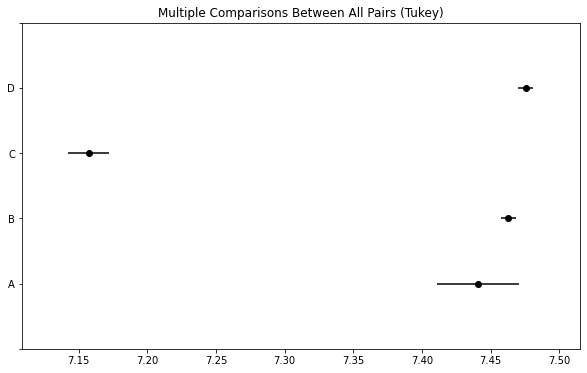

######### cat6 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.3029  0.001  0.2688  0.3369   True
     A      C   0.5117  0.001  0.4171  0.6062   True
     A      D   0.1225 0.6777  -0.099   0.344  False
     A      E   0.0811    0.9 -0.5349  0.6971  False
     A      G   0.1377    0.9 -1.4124  1.6879  False
     A      H  -0.0545    0.9 -0.8641   0.755  False
     A      I   0.0609    0.9 -0.4872  0.6089  False
     B      C   0.2088  0.001  0.1086   0.309   True
     B      D  -0.1804 0.2216 -0.4044  0.0436  False
     B      E  -0.2218    0.9 -0.8386  0.3951  False
     B      G  -0.1651    0.9 -1.7156  1.3854  False
     B      H  -0.3574 0.8802 -1.1676  0.4528  False
     B      I   -0.242 0.8809 -0.7911  0.3071  False
     C      D  -0.3892  0.001 -0.6299 -0.1485   True
     C      E  -0.4306 0.4212 -1.0537  0.1926  False
     C      G  -0.

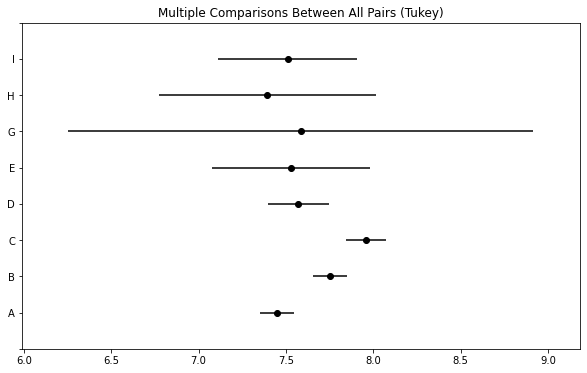

######### cat7 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B  -0.0717    0.9 -0.7912  0.6478  False
     A      C  -0.2411    0.9 -1.5532   1.071  False
     A      D  -0.0624    0.9 -0.7812  0.6565  False
     A      E  -0.1075    0.9 -0.8262  0.6112  False
     A      F  -0.0309    0.9 -0.7674  0.7055  False
     A      G  -0.1149    0.9 -0.8361  0.6063  False
     A      I    0.607    0.9 -1.1038  2.3177  False
     B      C  -0.1694    0.9 -1.2678  0.9289  False
     B      D   0.0093    0.9 -0.0301  0.0488  False
     B      E  -0.0358 0.0501 -0.0717     0.0  False
     B      F   0.0408    0.9 -0.1241  0.2056  False
     B      G  -0.0432  0.566 -0.1135  0.0271  False
     B      I   0.6787 0.8875 -0.8742  2.2316  False
     C      D   0.1788    0.9 -0.9192  1.2767  False
     C      E   0.1336    0.9 -0.9642  1.2314  False
     C      F   0.

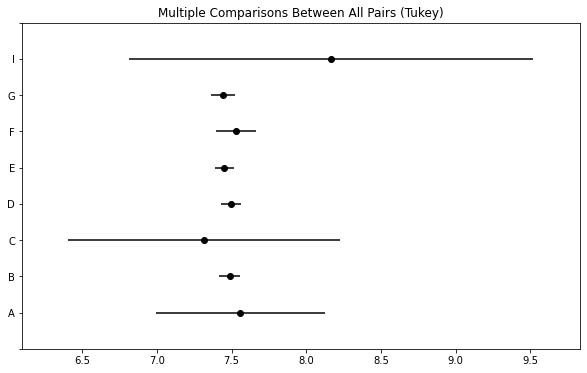

######### cat8 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.0875    0.9 -0.6102  0.7851  False
     A      C  -0.0275  0.001 -0.0429 -0.0122   True
     A      D   0.0099    0.9 -0.0351  0.0549  False
     A      E   0.0406  0.001  0.0247  0.0565   True
     A      F   0.0519 0.7974 -0.0603  0.1641  False
     A      G  -0.1506  0.001 -0.1691 -0.1321   True
     B      C   -0.115    0.9 -0.8126  0.5826  False
     B      D  -0.0776    0.9 -0.7765  0.6213  False
     B      E  -0.0469    0.9 -0.7445  0.6507  False
     B      F  -0.0356    0.9 -0.7419  0.6708  False
     B      G  -0.2381    0.9 -0.9357  0.4596  False
     C      D   0.0374 0.1483 -0.0062   0.081  False
     C      E   0.0681  0.001  0.0568  0.0795   True
     C      F   0.0795 0.3542 -0.0322  0.1911  False
     C      G  -0.1231  0.001 -0.1378 -0.1083   True
     D      E   0.

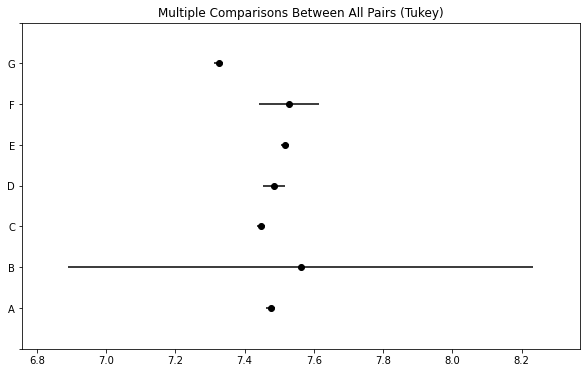

######### cat9 ############
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.0848  0.001  0.0276   0.142   True
     A      C   0.2756  0.001  0.0671  0.4841   True
     A      D   0.0441    0.9 -0.2517    0.34  False
     A      E   0.4074 0.0073  0.0564  0.7584   True
     A      F   0.1779  0.001  0.1505  0.2053   True
     A      G   0.2447  0.001  0.2056  0.2838   True
     A      H   0.1457  0.001  0.1137  0.1778   True
     A      I   0.0209 0.4875 -0.0082    0.05  False
     A      J   0.0431 0.0643  -0.001  0.0873  False
     A      K   0.0953  0.001  0.0622  0.1284   True
     A      L   0.3318  0.001  0.3021  0.3614   True
     A      M   0.1731  0.001  0.1334  0.2128   True
     A      N   0.1589  0.001  0.1056  0.2122   True
     A      O   0.1191  0.001  0.0731  0.1651   True
     B      C   0.1908 0.1389 -0.0223  0.4039  False
     B      D  -0.

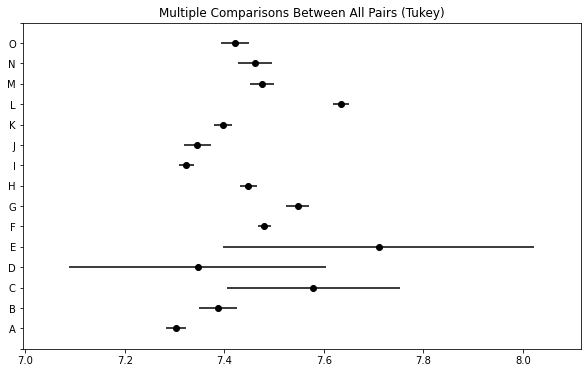

In [33]:
for cat in cat_features:
  uni = train[cat].unique()
  if len(uni) > 2:
    posthoc = pairwise_tukeyhsd(train['target'], train[cat], alpha = 0.05)
    print('#########', cat, '############')
    print(posthoc)
    fig = posthoc.plot_simultaneous()
    plt.show()
  elif len(uni) == 2:
    a = train.target[train[cat] == uni[0]]
    b = train.target[train[cat] == uni[1]]
    t, p = stats.ttest_ind(a,b)
    print('#########', cat, '############')
    print(p)

In [34]:
def create_stratified_folds_for_regression(data_df, n_splits=5):
    """
    @param data_df: training data to split in Stratified K Folds for a continous target value
    @param n_splits: number of splits
    @return: the training data with a column with kfold id
    """
    data_df['kfold'] = -1
    # randomize the data
    data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)
    # calculate the optimal number of bins based on log2(data_df.shape[0])
    num_bins = np.int(np.floor(1 + np.log2(len(data_df))))
    # bins value will be the equivalent of class value of target feature used by StratifiedKFold to 
    # distribute evenly the classed over each fold
    data_df.loc[:, "bins"] = pd.cut(pd.to_numeric(data_df['target'], downcast="signed"), bins=num_bins, labels=False)
    kf = StratifiedKFold(n_splits=n_splits, random_state=42)
    
    # set the fold id as a new column in the train data
    for f, (t_, v_) in enumerate(kf.split(X=data_df, y=data_df.bins.values)):
        data_df.loc[v_, 'kfold'] = f
    
    # drop the bins column (no longer needed)
    data_df = data_df.drop("bins", axis=1)
    
    return data_df

In [35]:
def cv_evaluation_regression(df, model):
    n_fold = 5
    oof = np.zeros((len(df),))
    for fold in tqdm(range(n_fold)):
        val_ind = df[df.kfold == fold].index
        train = df[df.kfold != fold].reset_index(drop=True)
        valid = df[df.kfold == fold].reset_index(drop=True)

        features = [feature for feature in df.columns if feature not in ['id', 'target', 'kfold']]

        X_train = train[features]
        y_train = train['target']
        X_valid = valid[features]
        y_valid = valid['target']

        model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 500, verbose=False)
        preds = model.predict(valid[features])
        mse = mean_squared_error(y_valid, preds)
        
        oof[val_ind] = preds
    
    mse_oof = mean_squared_error(oof, df['target'])
    
    print(f'LGBM Overall RMSE:{np.sqrt(mse_oof)}')
    return mse_oof

In [36]:
train_data = train.iloc[:,:-1]
train_target = train.iloc[:, -1]
test_data = test.copy()

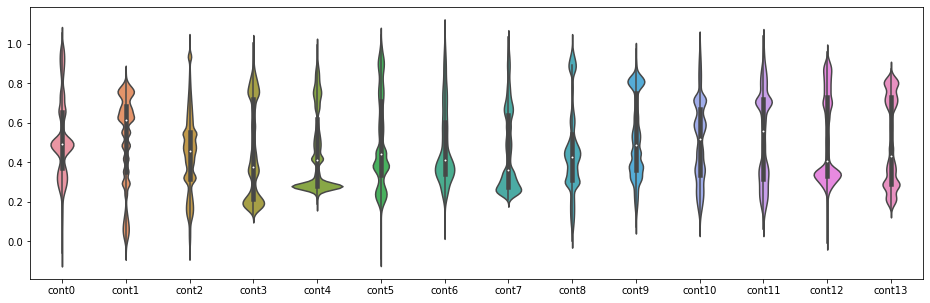

In [37]:
plt.figure(figsize=(16,5))
sns.violinplot(data = train_data[cont_features])

In [38]:
# # CAT4, CAT6 Drop하는 경우
# train_temp = train_data.drop(['cat6'], axis = 1)
# test_temp = test_data.drop(['cat6'], axis = 1)

train_temp = train_data.copy()
test_temp = test_data.copy()

cat_features = [feature for feature in train_temp.columns if 'cat' in feature]
cont_features = [feature for feature in train_temp.columns if 'cont' in feature]

# scaler  = QuantileTransformer(random_state=42, n_quantiles=2500)
scaler  = PowerTransformer()

a = pd.get_dummies(train_temp[cat_features])
b = pd.get_dummies(test_temp[cat_features])
missing_cols = set(a.columns) - set(b.columns)
for c in missing_cols:
  b[c] = 0
b = b[a.columns]

train_temp2 = train_data[cont_features]
test_temp2 = test_data[cont_features]
train_sc = scaler.fit_transform(train_temp2)
test_sc = scaler.transform(test_temp2)

train_scaled = pd.DataFrame(train_sc, index = train_temp2.index, columns = train_temp2.columns)
test_scaled = pd.DataFrame(test_sc, index = test_temp2.index, columns = test_temp2.columns)

trainset = pd.concat([train_scaled, a, train_target], axis = 1)
testset = pd.concat([test_scaled, b], axis = 1)

trainset.drop(['cat3_B', 'cat8_B'], axis = 1, inplace=True)

drops_cat5 = ['cat5_B', 'cat5_A', 'cat5_D']
trainset['cat5_ABD'] = trainset[drops_cat5].sum(axis = 1)
trainset.drop(drops_cat5, axis = 1, inplace=True)

drops_cat6 = ['cat6_E', 'cat6_I', 'cat6_H']
trainset['cat6_EIH'] = trainset[drops_cat6].sum(axis = 1)
trainset.drop(drops_cat6, axis = 1, inplace=True)


drops_cat7_1 = ['cat7_G', 'cat7_E']
trainset['cat7_GE'] = trainset[drops_cat7_1].sum(axis = 1)
drops_cat7_2 = ['cat7_B', 'cat7_D']
trainset['cat7_BD'] = trainset[drops_cat7_2].sum(axis = 1)
trainset.drop(drops_cat7_1, axis = 1, inplace=True)
trainset.drop(drops_cat7_2, axis = 1, inplace=True)

drops_cat8 = ['cat8_A', 'cat8_D']
trainset['cat8_AD'] = trainset[drops_cat8].sum(axis = 1)
trainset.drop(drops_cat8, axis = 1, inplace=True)


drops_cat9_1 = ['cat9_B', 'cat9_O', 'cat9_K']
trainset['cat9_BOK'] = trainset[drops_cat9_1].sum(axis = 1)
drops_cat9_2 = ['cat9_N', 'cat9_M', 'cat9_H']
trainset['cat9_NMH'] = trainset[drops_cat9_2].sum(axis = 1)
trainset.drop(drops_cat9_1, axis = 1, inplace=True)
trainset.drop(drops_cat9_2, axis = 1, inplace=True)

In [39]:
train_fold = create_stratified_folds_for_regression(trainset)
model = lgb.LGBMRegressor(random_state=42)
score = cv_evaluation_regression(train_fold, model)


LGBM Overall RMSE:0.8462646408680162


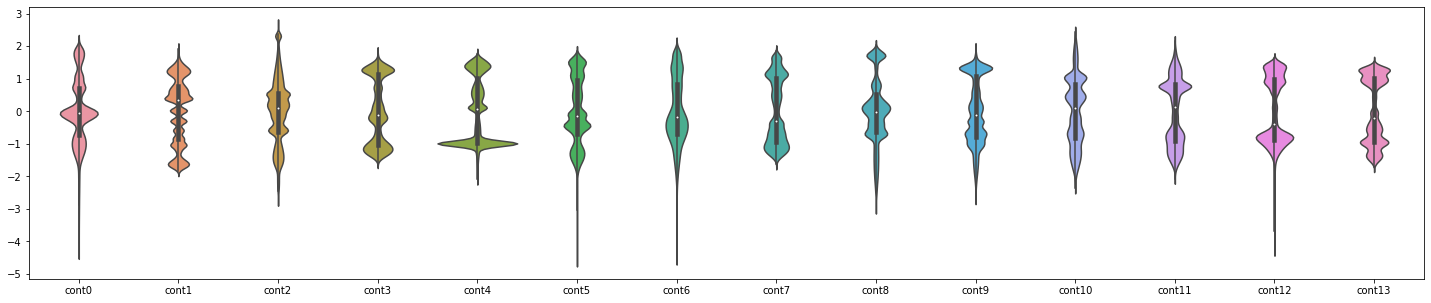

In [40]:
plt.figure(figsize=(25,5))
sns.violinplot(data = trainset[cont_features])

In [41]:
# Outlier 제거
trainset2 = trainset.copy()

from sklearn.ensemble import IsolationForest
iso_model = IsolationForest(max_samples='auto', random_state=42, n_jobs = -1, contamination = 0.1, n_estimators=500)
iso_model.fit(trainset2)

score = iso_model.decision_function(trainset2)
anomaly = iso_model.predict(trainset2)
trainset2['scores'] = score
trainset2['anomaly'] = anomaly

In [42]:
train_fold = create_stratified_folds_for_regression(trainset2)
model = lgb.LGBMRegressor(random_state=42)
score = cv_evaluation_regression(train_fold, model)


LGBM Overall RMSE:0.8453841607613808


In [43]:
train_fold

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cat0_A,cat0_B,cat1_A,cat1_B,cat2_A,cat2_B,cat3_A,cat3_C,cat3_D,cat4_A,cat4_B,cat4_C,cat4_D,cat5_C,cat6_A,cat6_B,cat6_C,cat6_D,cat6_G,cat7_A,cat7_C,cat7_F,cat7_I,cat8_C,cat8_E,cat8_F,cat8_G,cat9_A,cat9_C,cat9_D,cat9_E,cat9_F,cat9_G,cat9_I,cat9_J,cat9_L,target,cat5_ABD,cat6_EIH,cat7_GE,cat7_BD,cat8_AD,cat9_BOK,cat9_NMH,kfold,scores,anomaly
0,0.063459,0.547124,0.286647,0.026728,-0.970359,-0.463341,1.186723,-1.447889,-0.811682,-0.585855,-0.773920,-0.913852,-0.937787,1.017898,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,5.733432,1,0,1,0,0,0,0,0,0.015433,1
1,-1.081840,-1.654312,0.399657,-1.411632,-0.797778,-0.350594,0.561543,-1.083645,-0.687609,-1.714217,-0.721692,-1.003205,-1.131612,1.113003,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6.990234,1,0,1,0,0,0,1,0,0.052201,1
2,1.563698,0.726425,1.417603,-1.051357,-1.010105,1.328282,-0.790124,1.413296,-0.894499,0.678841,-0.169562,0.735109,1.297581,1.258405,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,8.212900,1,0,1,0,0,0,1,0,-0.020669,-1
3,-0.860759,-1.481680,-0.624235,1.213227,0.127443,1.062009,-0.360081,-1.182251,-1.001042,-0.941134,-0.564849,-0.733908,-1.055110,1.106341,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,8.466549,1,0,1,0,0,0,0,0,0.085263,1
4,-0.420112,0.832561,2.373246,0.102615,0.074190,-1.409122,-0.485245,-0.992150,-0.676684,-1.048086,0.149505,-1.037465,-0.875276,-0.845528,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7.449541,1,0,1,0,1,0,0,0,0.063353,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-1.688524,-1.474387,1.086894,-0.824828,-1.044355,0.592711,-1.598201,-1.247627,-0.472509,-0.990175,-0.801552,-0.925519,-0.679648,-0.603161,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,6.611676,1,0,1,0,0,0,0,4,0.056215,1
299996,-1.040027,0.652625,1.004387,-0.209832,-1.007911,-1.411761,0.338795,-0.676317,0.232152,-1.503663,0.960393,0.985881,0.712613,-0.347695,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,7.253953,1,0,1,0,0,0,0,4,0.053090,1
299997,-0.141074,0.695301,-0.400485,1.228440,-0.979015,-0.441027,1.773414,0.856959,0.102824,-0.313641,1.195293,0.917672,-1.807939,0.946479,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6.979163,1,0,1,0,1,0,0,4,0.057698,1
299998,-1.292875,-0.829829,1.721416,0.453327,-0.175844,-1.232363,-0.274564,0.456955,-0.567006,-1.033324,-0.632128,-0.749684,0.756160,-1.388986,1,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,6.423450,1,0,1,0,0,0,0,4,0.067854,1


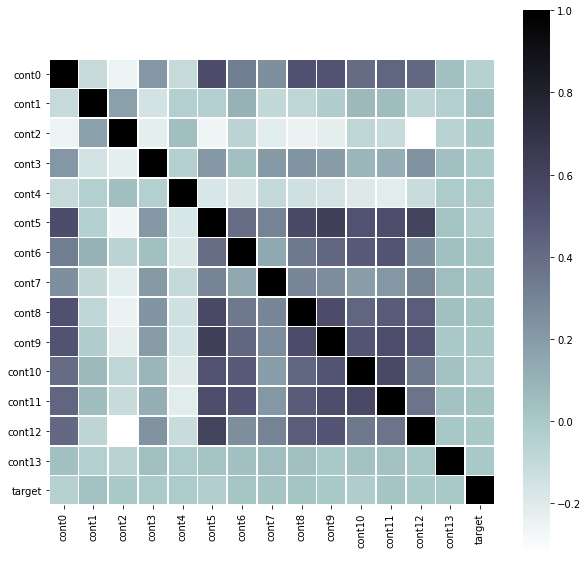

In [44]:
## 다중공선성 확인

plt.figure(figsize=(10,10))
sns.heatmap(trainset2[cont_features].join(train_target).corr(), square=True, linewidths=0.7, cmap="bone_r")

In [45]:
X = trainset2.loc[:, trainset2.columns != 'target']
X = X[cont_features]
y = trainset2['target']

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

### VIF 값이 10을 넘는 이상치 없음....... 그냥 쓰면 될 듯 하다.

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,1.695632,cont0
1,1.085992,cont1
2,1.208957,cont2
3,1.141717,cont3
4,1.064631,cont4
5,2.390685,cont5
6,1.515827,cont6
7,1.182102,cont7
8,1.823751,cont8
9,2.078532,cont9


In [84]:
def cv_evaluation_regression2(df, model1, model2, model3, a,b,c):
    n_fold = 5
    oof = np.zeros((len(df),))
    for fold in tqdm(range(n_fold)):
        val_ind = df[df.kfold == fold].index
        train = df[df.kfold != fold].reset_index(drop=True)
        valid = df[df.kfold == fold].reset_index(drop=True)

        features = [feature for feature in df.columns if feature not in ['id', 'target', 'kfold']]

        X_train = train[features]
        y_train = train['target']
        X_valid = valid[features]
        y_valid = valid['target']

        model1.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 500, verbose=False)
        model2.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 500, verbose=False)
        model3.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 500, verbose=False)

        preds1 = model1.predict(valid[features])
        preds2 = model2.predict(valid[features])
        preds3 = model3.predict(valid[features])

        pred = (a * preds1 + b*preds2 + c*preds3)/(a + b +c)
        oof[val_ind] = pred

    mse_oof = mean_squared_error(oof, df['target'])
    return np.sqrt(mse_oof)

In [85]:
def objective(trial: Trial, X):

  params = {} #initialize parameters
  params['random_state'] = 42
  params['learning_rate'] = 0.01
  params['n_estimators'] = 400
  params['device_type'] = 'gpu'

  params['feature_fraction'] = trial.suggest_loguniform('feature_fraction_lg', 0.3, 1)
  params['subsample'] = trial.suggest_loguniform('subsample_lg', 0.3, 1)
  params['num_leaves'] = trial.suggest_int('num_leaves_lg', 150, 300)
  params['min_data'] = trial.suggest_int('min_data_lg', 10, 500)
  params['max_depth'] = trial.suggest_int('max_depth_lg', 10, 25)
  params['boosting_type'] = trial.suggest_categorical('boosting_type_lg', ['gbdt', 'dart', 'goss'])
  params['min_child_weight'] = trial.suggest_loguniform('min_child_weight_lg', 0.0001, 100)
  params['max_drop'] = trial.suggest_int('max_drop_lg', 10, 150)

  lgbm_model = lgb.LGBMRegressor(**params)

  xgb_params = {}
  xgb_params['objective'] = 'reg:squarederror'
  xgb_params['n_estimators'] = 200
  xgb_params['max_depth'] = trial.suggest_int('max_depth_xg', 3, 16)
  xgb_params['min_child_weight'] = trial.suggest_int('min_child_weight_xg', 1, 300)
  xgb_params['gamma'] = trial.suggest_discrete_uniform('gamma_xg', 0.5, 10, 0.5)
  xgb_params['learning_rate'] = 0.01
  xgb_params['colsample_bytree'] = trial.suggest_discrete_uniform('colsample_bytree_xg',0.5, 1, 0.05)
  xgb_params['lambda'] = trial.suggest_loguniform('lambda_xg', 1e-3, 10.0)
  xgb_params['alpha'] = trial.suggest_loguniform('alpha_xg', 1e-3, 10.0)
  xgb_params['subsample'] = trial.suggest_discrete_uniform('subsample_xg', 0.5,1, 0.05 )
  xgb_params['random_state'] = 42
  xgb_params['tree_method'] = 'gpu_hist'
  xgb_params['gpu_id'] = 0
  xgb_model = XGBRegressor(**xgb_params)

  cat_params = {} #initialize parameters
  cat_params['random_state'] = 42
  cat_params['iterations'] = 400
  cat_params['subsample'] = trial.suggest_loguniform('subsample', 0.3, 1)
  cat_params['max_depth'] = trial.suggest_int('max_depth', 3, 10)
  cat_params['l2_leaf_reg'] = trial.suggest_loguniform('l2_leaf_reg', 0.3, 100)
  cat_params['objective'] = trial.suggest_categorical('objective', ['MAE', 'MAPE', 'Poisson', 'RMSE'])
  cat_params['bootstrap_type'] = trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'MVS', 'Poisson'])
  cat_params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 1, 200)
  cat_params['learning_rate'] = 0.01
  cat_params['task_type'] = 'GPU'
  # cat_params['max_bin'] = 36
  cat_params['learning_rate'] = 0.01
  cat_model = catboost.CatBoostRegressor(**cat_params)

  lgbm_ratio = trial.suggest_int('lgbm', 1, 5)
  xgb_ratio = trial.suggest_int('xgb', 1, 5)
  cat_ratio = trial.suggest_int('cat', 1, 5)
  # score = cv_evaluation_regression(X, model)
  score = cv_evaluation_regression2(X, lgbm_model, xgb_model, cat_model, lgbm_ratio, xgb_ratio, cat_ratio)

  return score

In [52]:
study = optuna.create_study(direction = 'minimize')

[I 2021-02-15 17:33:05,180] A new study created in memory with name: no-name-b786d412-4a97-4e9a-b00d-7e93f795fd2d


In [86]:
study.optimize(lambda trial : objective(trial, train_fold), n_trials=200)

[LightGBM] [Warning] min_data_in_leaf is set with min_data=228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=228
[LightGBM] [Warning] feature_fraction is set=0.6092884405720411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6092884405720411


[LightGBM] [Warning] min_data_in_leaf is set with min_data=228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=228
[LightGBM] [Warning] feature_fraction is set=0.6092884405720411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6092884405720411


[LightGBM] [Warning] min_data_in_leaf is set with min_data=228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=228
[LightGBM] [Warning] feature_fraction is set=0.6092884405720411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6092884405720411


[LightGBM] [Warning] min_data_in_leaf is set with min_data=228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=228
[LightGBM] [Warning] feature_fraction is set=0.6092884405720411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6092884405720411


[LightGBM] [Warning] min_data_in_leaf is set with min_data=228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=228
[LightGBM] [Warning] feature_fraction is set=0.6092884405720411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6092884405720411


[I 2021-02-15 18:05:03,195] Trial 4 finished with value: 1.051119523551308 and parameters: {'feature_fraction_lg': 0.6092884405720411, 'subsample_lg': 0.3728854858191869, 'num_leaves_lg': 229, 'min_data_lg': 228, 'max_depth_lg': 19, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 19.06891223335603, 'max_drop_lg': 65, 'max_depth_xg': 11, 'min_child_weight_xg': 13, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.8, 'lambda_xg': 0.005982866607464751, 'alpha_xg': 0.4419181050368366, 'subsample_xg': 0.6, 'subsample': 0.7965160122746717, 'max_depth': 7, 'l2_leaf_reg': 84.51167353827256, 'objective': 'Poisson', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 48, 'lgbm': 1, 'xgb': 3, 'cat': 1}. Best is trial 4 with value: 1.051119523551308.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=483, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=483
[LightGBM] [Warning] feature_fraction is set=0.8966464089630358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966464089630358


[LightGBM] [Warning] min_data_in_leaf is set with min_data=483, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=483
[LightGBM] [Warning] feature_fraction is set=0.8966464089630358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966464089630358


[LightGBM] [Warning] min_data_in_leaf is set with min_data=483, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=483
[LightGBM] [Warning] feature_fraction is set=0.8966464089630358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966464089630358


[LightGBM] [Warning] min_data_in_leaf is set with min_data=483, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=483
[LightGBM] [Warning] feature_fraction is set=0.8966464089630358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966464089630358


[LightGBM] [Warning] min_data_in_leaf is set with min_data=483, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=483
[LightGBM] [Warning] feature_fraction is set=0.8966464089630358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966464089630358


[I 2021-02-15 18:34:32,252] Trial 5 finished with value: 1.0867216490922877 and parameters: {'feature_fraction_lg': 0.8966464089630358, 'subsample_lg': 0.5319244543349927, 'num_leaves_lg': 176, 'min_data_lg': 483, 'max_depth_lg': 23, 'boosting_type_lg': 'dart', 'min_child_weight_lg': 0.8340637640672777, 'max_drop_lg': 138, 'max_depth_xg': 4, 'min_child_weight_xg': 73, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.8500000000000001, 'lambda_xg': 5.726069393846882, 'alpha_xg': 0.13749566435322857, 'subsample_xg': 0.9, 'subsample': 0.6398696359938305, 'max_depth': 3, 'l2_leaf_reg': 0.740821763335288, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 114, 'lgbm': 1, 'xgb': 5, 'cat': 5}. Best is trial 4 with value: 1.051119523551308.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=167
[LightGBM] [Warning] feature_fraction is set=0.9168245721790634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9168245721790634


[LightGBM] [Warning] min_data_in_leaf is set with min_data=167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=167
[LightGBM] [Warning] feature_fraction is set=0.9168245721790634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9168245721790634


[LightGBM] [Warning] min_data_in_leaf is set with min_data=167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=167
[LightGBM] [Warning] feature_fraction is set=0.9168245721790634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9168245721790634


[LightGBM] [Warning] min_data_in_leaf is set with min_data=167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=167
[LightGBM] [Warning] feature_fraction is set=0.9168245721790634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9168245721790634


[LightGBM] [Warning] min_data_in_leaf is set with min_data=167, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=167
[LightGBM] [Warning] feature_fraction is set=0.9168245721790634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9168245721790634


[I 2021-02-15 18:38:56,708] Trial 6 finished with value: 1.034159140042175 and parameters: {'feature_fraction_lg': 0.9168245721790634, 'subsample_lg': 0.4366476979207287, 'num_leaves_lg': 221, 'min_data_lg': 167, 'max_depth_lg': 13, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.00013524284806065587, 'max_drop_lg': 13, 'max_depth_xg': 8, 'min_child_weight_xg': 74, 'gamma_xg': 1.5, 'colsample_bytree_xg': 1.0, 'lambda_xg': 0.0014178243983867462, 'alpha_xg': 0.17703017232394216, 'subsample_xg': 0.7, 'subsample': 0.8182136957688251, 'max_depth': 9, 'l2_leaf_reg': 18.304442984159326, 'objective': 'RMSE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 32, 'lgbm': 1, 'xgb': 5, 'cat': 2}. Best is trial 6 with value: 1.034159140042175.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.3107149575827446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3107149575827446


[LightGBM] [Warning] min_data_in_leaf is set with min_data=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.3107149575827446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3107149575827446


[LightGBM] [Warning] min_data_in_leaf is set with min_data=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.3107149575827446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3107149575827446


[LightGBM] [Warning] min_data_in_leaf is set with min_data=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.3107149575827446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3107149575827446


[LightGBM] [Warning] min_data_in_leaf is set with min_data=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.3107149575827446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3107149575827446


[I 2021-02-15 18:41:54,053] Trial 7 finished with value: 0.9535215818978503 and parameters: {'feature_fraction_lg': 0.3107149575827446, 'subsample_lg': 0.6115964197860803, 'num_leaves_lg': 214, 'min_data_lg': 160, 'max_depth_lg': 10, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.21433882897998494, 'max_drop_lg': 115, 'max_depth_xg': 3, 'min_child_weight_xg': 149, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.004006040542076454, 'alpha_xg': 6.020879388500146, 'subsample_xg': 0.7, 'subsample': 0.8933154064615619, 'max_depth': 10, 'l2_leaf_reg': 5.891930684047008, 'objective': 'Poisson', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 57, 'lgbm': 1, 'xgb': 2, 'cat': 4}. Best is trial 7 with value: 0.9535215818978503.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] feature_fraction is set=0.6127148597909177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6127148597909177


[LightGBM] [Warning] min_data_in_leaf is set with min_data=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] feature_fraction is set=0.6127148597909177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6127148597909177


[LightGBM] [Warning] min_data_in_leaf is set with min_data=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] feature_fraction is set=0.6127148597909177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6127148597909177


[LightGBM] [Warning] min_data_in_leaf is set with min_data=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] feature_fraction is set=0.6127148597909177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6127148597909177


[LightGBM] [Warning] min_data_in_leaf is set with min_data=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] feature_fraction is set=0.6127148597909177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6127148597909177


[I 2021-02-15 18:45:08,372] Trial 8 finished with value: 0.9683783087938972 and parameters: {'feature_fraction_lg': 0.6127148597909177, 'subsample_lg': 0.6796429816957175, 'num_leaves_lg': 269, 'min_data_lg': 191, 'max_depth_lg': 12, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.0030512073039176578, 'max_drop_lg': 13, 'max_depth_xg': 4, 'min_child_weight_xg': 251, 'gamma_xg': 6.0, 'colsample_bytree_xg': 0.8500000000000001, 'lambda_xg': 0.052063421941489316, 'alpha_xg': 3.023711763984289, 'subsample_xg': 0.9, 'subsample': 0.9866934422950628, 'max_depth': 8, 'l2_leaf_reg': 39.731333955804516, 'objective': 'Poisson', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 95, 'lgbm': 4, 'xgb': 5, 'cat': 3}. Best is trial 7 with value: 0.9535215818978503.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] feature_fraction is set=0.3977431455435363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3977431455435363


[LightGBM] [Warning] min_data_in_leaf is set with min_data=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] feature_fraction is set=0.3977431455435363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3977431455435363


[LightGBM] [Warning] min_data_in_leaf is set with min_data=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] feature_fraction is set=0.3977431455435363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3977431455435363


[LightGBM] [Warning] min_data_in_leaf is set with min_data=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] feature_fraction is set=0.3977431455435363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3977431455435363


[LightGBM] [Warning] min_data_in_leaf is set with min_data=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] feature_fraction is set=0.3977431455435363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3977431455435363


[I 2021-02-15 18:48:09,790] Trial 9 finished with value: 0.9864371757163831 and parameters: {'feature_fraction_lg': 0.3977431455435363, 'subsample_lg': 0.5375717590819651, 'num_leaves_lg': 196, 'min_data_lg': 181, 'max_depth_lg': 23, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.0005030253742992494, 'max_drop_lg': 61, 'max_depth_xg': 8, 'min_child_weight_xg': 203, 'gamma_xg': 5.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.0023701717817685547, 'alpha_xg': 4.852870675768569, 'subsample_xg': 0.7, 'subsample': 0.9324573377746882, 'max_depth': 8, 'l2_leaf_reg': 1.9453948924121782, 'objective': 'MAPE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 78, 'lgbm': 1, 'xgb': 5, 'cat': 5}. Best is trial 7 with value: 0.9535215818978503.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] feature_fraction is set=0.3699969091143136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3699969091143136


[LightGBM] [Warning] min_data_in_leaf is set with min_data=322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] feature_fraction is set=0.3699969091143136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3699969091143136


[LightGBM] [Warning] min_data_in_leaf is set with min_data=322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] feature_fraction is set=0.3699969091143136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3699969091143136


[LightGBM] [Warning] min_data_in_leaf is set with min_data=322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] feature_fraction is set=0.3699969091143136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3699969091143136


[LightGBM] [Warning] min_data_in_leaf is set with min_data=322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] feature_fraction is set=0.3699969091143136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3699969091143136


[I 2021-02-15 18:51:27,538] Trial 10 finished with value: 0.9529168967584519 and parameters: {'feature_fraction_lg': 0.3699969091143136, 'subsample_lg': 0.36191561933442323, 'num_leaves_lg': 285, 'min_data_lg': 322, 'max_depth_lg': 19, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.9924128221625523, 'max_drop_lg': 84, 'max_depth_xg': 5, 'min_child_weight_xg': 280, 'gamma_xg': 1.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.034620029973589136, 'alpha_xg': 0.03740677236997734, 'subsample_xg': 0.8500000000000001, 'subsample': 0.7139178138502299, 'max_depth': 8, 'l2_leaf_reg': 5.283330261763648, 'objective': 'RMSE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 88, 'lgbm': 4, 'xgb': 5, 'cat': 2}. Best is trial 10 with value: 0.9529168967584519.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.3383792109794341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3383792109794341


[LightGBM] [Warning] min_data_in_leaf is set with min_data=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.3383792109794341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3383792109794341


[LightGBM] [Warning] min_data_in_leaf is set with min_data=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.3383792109794341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3383792109794341


[LightGBM] [Warning] min_data_in_leaf is set with min_data=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.3383792109794341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3383792109794341


[LightGBM] [Warning] min_data_in_leaf is set with min_data=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] feature_fraction is set=0.3383792109794341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3383792109794341


[I 2021-02-15 18:54:23,759] Trial 11 finished with value: 0.8811966148610828 and parameters: {'feature_fraction_lg': 0.3383792109794341, 'subsample_lg': 0.7317357078267702, 'num_leaves_lg': 159, 'min_data_lg': 300, 'max_depth_lg': 15, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.011142605901789697, 'max_drop_lg': 50, 'max_depth_xg': 12, 'min_child_weight_xg': 104, 'gamma_xg': 4.0, 'colsample_bytree_xg': 0.8500000000000001, 'lambda_xg': 2.2278699378288995, 'alpha_xg': 0.026376948825697497, 'subsample_xg': 0.6, 'subsample': 0.41926991031104316, 'max_depth': 5, 'l2_leaf_reg': 0.3033870869198676, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 188, 'lgbm': 5, 'xgb': 3, 'cat': 4}. Best is trial 11 with value: 0.8811966148610828.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=299, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=299
[LightGBM] [Warning] feature_fraction is set=0.7534918599084759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7534918599084759


[LightGBM] [Warning] min_data_in_leaf is set with min_data=299, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=299
[LightGBM] [Warning] feature_fraction is set=0.7534918599084759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7534918599084759


[LightGBM] [Warning] min_data_in_leaf is set with min_data=299, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=299
[LightGBM] [Warning] feature_fraction is set=0.7534918599084759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7534918599084759


[LightGBM] [Warning] min_data_in_leaf is set with min_data=299, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=299
[LightGBM] [Warning] feature_fraction is set=0.7534918599084759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7534918599084759


[LightGBM] [Warning] min_data_in_leaf is set with min_data=299, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=299
[LightGBM] [Warning] feature_fraction is set=0.7534918599084759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7534918599084759


[I 2021-02-15 18:58:14,005] Trial 12 finished with value: 0.9164974179485279 and parameters: {'feature_fraction_lg': 0.7534918599084759, 'subsample_lg': 0.5018414669956536, 'num_leaves_lg': 279, 'min_data_lg': 299, 'max_depth_lg': 12, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.5392251388031747, 'max_drop_lg': 58, 'max_depth_xg': 7, 'min_child_weight_xg': 205, 'gamma_xg': 9.5, 'colsample_bytree_xg': 0.9, 'lambda_xg': 1.499173810093259, 'alpha_xg': 1.517144096114111, 'subsample_xg': 0.9, 'subsample': 0.588128032316969, 'max_depth': 3, 'l2_leaf_reg': 1.0184023334542327, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'lgbm': 3, 'xgb': 4, 'cat': 4}. Best is trial 11 with value: 0.8811966148610828.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.9269305802999471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9269305802999471


[LightGBM] [Warning] min_data_in_leaf is set with min_data=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.9269305802999471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9269305802999471


[LightGBM] [Warning] min_data_in_leaf is set with min_data=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.9269305802999471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9269305802999471


[LightGBM] [Warning] min_data_in_leaf is set with min_data=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.9269305802999471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9269305802999471


[LightGBM] [Warning] min_data_in_leaf is set with min_data=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] feature_fraction is set=0.9269305802999471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9269305802999471


[I 2021-02-15 19:02:08,336] Trial 13 finished with value: 0.8825553586408983 and parameters: {'feature_fraction_lg': 0.9269305802999471, 'subsample_lg': 0.34366359835452387, 'num_leaves_lg': 272, 'min_data_lg': 178, 'max_depth_lg': 25, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.00017862772884225046, 'max_drop_lg': 37, 'max_depth_xg': 12, 'min_child_weight_xg': 166, 'gamma_xg': 6.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.02490567438596772, 'alpha_xg': 0.252470053094432, 'subsample_xg': 0.9, 'subsample': 0.5770470561950558, 'max_depth': 8, 'l2_leaf_reg': 7.909877259171758, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 127, 'lgbm': 2, 'xgb': 2, 'cat': 4}. Best is trial 11 with value: 0.8811966148610828.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.4534191223652628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4534191223652628


[LightGBM] [Warning] min_data_in_leaf is set with min_data=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.4534191223652628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4534191223652628


[LightGBM] [Warning] min_data_in_leaf is set with min_data=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.4534191223652628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4534191223652628


[LightGBM] [Warning] min_data_in_leaf is set with min_data=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.4534191223652628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4534191223652628


[LightGBM] [Warning] min_data_in_leaf is set with min_data=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.4534191223652628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4534191223652628


[I 2021-02-15 19:29:05,513] Trial 14 finished with value: 1.8361243285408222 and parameters: {'feature_fraction_lg': 0.4534191223652628, 'subsample_lg': 0.9949459210247519, 'num_leaves_lg': 150, 'min_data_lg': 24, 'max_depth_lg': 16, 'boosting_type_lg': 'dart', 'min_child_weight_lg': 0.010815046190405235, 'max_drop_lg': 101, 'max_depth_xg': 16, 'min_child_weight_xg': 79, 'gamma_xg': 3.5, 'colsample_bytree_xg': 1.0, 'lambda_xg': 0.49248083479271404, 'alpha_xg': 0.0014271082386587035, 'subsample_xg': 0.5, 'subsample': 0.38271083626584845, 'max_depth': 5, 'l2_leaf_reg': 0.34460139533979434, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 193, 'lgbm': 5, 'xgb': 1, 'cat': 3}. Best is trial 11 with value: 0.8811966148610828.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=398, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=398
[LightGBM] [Warning] feature_fraction is set=0.48661633521742176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48661633521742176


[LightGBM] [Warning] min_data_in_leaf is set with min_data=398, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=398
[LightGBM] [Warning] feature_fraction is set=0.48661633521742176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48661633521742176


[LightGBM] [Warning] min_data_in_leaf is set with min_data=398, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=398
[LightGBM] [Warning] feature_fraction is set=0.48661633521742176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48661633521742176


[LightGBM] [Warning] min_data_in_leaf is set with min_data=398, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=398
[LightGBM] [Warning] feature_fraction is set=0.48661633521742176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48661633521742176


[LightGBM] [Warning] min_data_in_leaf is set with min_data=398, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=398
[LightGBM] [Warning] feature_fraction is set=0.48661633521742176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48661633521742176


[I 2021-02-15 19:32:39,070] Trial 15 finished with value: 0.8843508487522638 and parameters: {'feature_fraction_lg': 0.48661633521742176, 'subsample_lg': 0.8389989598563314, 'num_leaves_lg': 252, 'min_data_lg': 398, 'max_depth_lg': 16, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.015865627179489885, 'max_drop_lg': 33, 'max_depth_xg': 13, 'min_child_weight_xg': 124, 'gamma_xg': 3.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.261207968020122, 'alpha_xg': 0.015172692396140795, 'subsample_xg': 1.0, 'subsample': 0.43639668292065964, 'max_depth': 5, 'l2_leaf_reg': 8.945905306975565, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 174, 'lgbm': 2, 'xgb': 2, 'cat': 4}. Best is trial 11 with value: 0.8811966148610828.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3043916676232616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3043916676232616


[LightGBM] [Warning] min_data_in_leaf is set with min_data=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3043916676232616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3043916676232616


[LightGBM] [Warning] min_data_in_leaf is set with min_data=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3043916676232616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3043916676232616


[LightGBM] [Warning] min_data_in_leaf is set with min_data=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3043916676232616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3043916676232616


[LightGBM] [Warning] min_data_in_leaf is set with min_data=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.3043916676232616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3043916676232616


[I 2021-02-15 19:35:28,261] Trial 16 finished with value: 0.9191343991624935 and parameters: {'feature_fraction_lg': 0.3043916676232616, 'subsample_lg': 0.806763667933212, 'num_leaves_lg': 150, 'min_data_lg': 69, 'max_depth_lg': 25, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.0006982343958631442, 'max_drop_lg': 37, 'max_depth_xg': 14, 'min_child_weight_xg': 192, 'gamma_xg': 4.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.01352155070918815, 'alpha_xg': 0.006624160812735131, 'subsample_xg': 0.5, 'subsample': 0.4840720847355614, 'max_depth': 5, 'l2_leaf_reg': 2.8816354380074327, 'objective': 'MAPE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 145, 'lgbm': 3, 'xgb': 3, 'cat': 4}. Best is trial 11 with value: 0.8811966148610828.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=364
[LightGBM] [Warning] feature_fraction is set=0.7563010759920666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563010759920666


[LightGBM] [Warning] min_data_in_leaf is set with min_data=364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=364
[LightGBM] [Warning] feature_fraction is set=0.7563010759920666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563010759920666


[LightGBM] [Warning] min_data_in_leaf is set with min_data=364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=364
[LightGBM] [Warning] feature_fraction is set=0.7563010759920666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563010759920666


[LightGBM] [Warning] min_data_in_leaf is set with min_data=364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=364
[LightGBM] [Warning] feature_fraction is set=0.7563010759920666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563010759920666


[LightGBM] [Warning] min_data_in_leaf is set with min_data=364, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=364
[LightGBM] [Warning] feature_fraction is set=0.7563010759920666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563010759920666


[I 2021-02-15 19:39:07,716] Trial 17 finished with value: 0.8762697055224585 and parameters: {'feature_fraction_lg': 0.7563010759920666, 'subsample_lg': 0.30064931682706253, 'num_leaves_lg': 297, 'min_data_lg': 364, 'max_depth_lg': 16, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.00015660951880372008, 'max_drop_lg': 39, 'max_depth_xg': 11, 'min_child_weight_xg': 120, 'gamma_xg': 5.5, 'colsample_bytree_xg': 0.75, 'lambda_xg': 9.73563409857367, 'alpha_xg': 0.5681326870887924, 'subsample_xg': 0.6, 'subsample': 0.30652875480742897, 'max_depth': 6, 'l2_leaf_reg': 18.20942292867866, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 152, 'lgbm': 2, 'xgb': 2, 'cat': 5}. Best is trial 17 with value: 0.8762697055224585.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.7128405376626823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7128405376626823


[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.7128405376626823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7128405376626823


[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.7128405376626823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7128405376626823


[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.7128405376626823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7128405376626823


[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.7128405376626823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7128405376626823


[I 2021-02-15 19:42:12,022] Trial 18 finished with value: 0.855915291029976 and parameters: {'feature_fraction_lg': 0.7128405376626823, 'subsample_lg': 0.7191920417992077, 'num_leaves_lg': 178, 'min_data_lg': 414, 'max_depth_lg': 16, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.03618851427877387, 'max_drop_lg': 46, 'max_depth_xg': 10, 'min_child_weight_xg': 106, 'gamma_xg': 2.5, 'colsample_bytree_xg': 0.9, 'lambda_xg': 9.183505441817346, 'alpha_xg': 0.8025658144252625, 'subsample_xg': 0.6, 'subsample': 0.3015701210338648, 'max_depth': 6, 'l2_leaf_reg': 25.932619321336414, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 161, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 18 with value: 0.855915291029976.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] feature_fraction is set=0.7378202517070821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7378202517070821


[LightGBM] [Warning] min_data_in_leaf is set with min_data=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] feature_fraction is set=0.7378202517070821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7378202517070821


[LightGBM] [Warning] min_data_in_leaf is set with min_data=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] feature_fraction is set=0.7378202517070821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7378202517070821


[LightGBM] [Warning] min_data_in_leaf is set with min_data=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] feature_fraction is set=0.7378202517070821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7378202517070821


[LightGBM] [Warning] min_data_in_leaf is set with min_data=423, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=423
[LightGBM] [Warning] feature_fraction is set=0.7378202517070821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7378202517070821


[I 2021-02-15 20:08:21,666] Trial 19 finished with value: 1.168615273137869 and parameters: {'feature_fraction_lg': 0.7378202517070821, 'subsample_lg': 0.30653666391774015, 'num_leaves_lg': 184, 'min_data_lg': 423, 'max_depth_lg': 19, 'boosting_type_lg': 'dart', 'min_child_weight_lg': 58.87512555771498, 'max_drop_lg': 24, 'max_depth_xg': 10, 'min_child_weight_xg': 44, 'gamma_xg': 2.0, 'colsample_bytree_xg': 0.9, 'lambda_xg': 4.111004865919941, 'alpha_xg': 0.9079385872137518, 'subsample_xg': 0.6, 'subsample': 0.30235212627619246, 'max_depth': 6, 'l2_leaf_reg': 28.893372541657882, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 156, 'lgbm': 2, 'xgb': 1, 'cat': 5}. Best is trial 18 with value: 0.855915291029976.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=385, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=385
[LightGBM] [Warning] feature_fraction is set=0.7401926324793854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7401926324793854


[LightGBM] [Warning] min_data_in_leaf is set with min_data=385, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=385
[LightGBM] [Warning] feature_fraction is set=0.7401926324793854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7401926324793854


[LightGBM] [Warning] min_data_in_leaf is set with min_data=385, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=385
[LightGBM] [Warning] feature_fraction is set=0.7401926324793854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7401926324793854


[LightGBM] [Warning] min_data_in_leaf is set with min_data=385, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=385
[LightGBM] [Warning] feature_fraction is set=0.7401926324793854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7401926324793854


[LightGBM] [Warning] min_data_in_leaf is set with min_data=385, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=385
[LightGBM] [Warning] feature_fraction is set=0.7401926324793854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7401926324793854


[I 2021-02-15 20:12:00,639] Trial 20 finished with value: 0.8570670724227543 and parameters: {'feature_fraction_lg': 0.7401926324793854, 'subsample_lg': 0.982966774335295, 'num_leaves_lg': 300, 'min_data_lg': 385, 'max_depth_lg': 14, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 8.141019795047447, 'max_drop_lg': 74, 'max_depth_xg': 15, 'min_child_weight_xg': 129, 'gamma_xg': 2.5, 'colsample_bytree_xg': 0.75, 'lambda_xg': 8.119568783673449, 'alpha_xg': 0.8837979793339606, 'subsample_xg': 0.55, 'subsample': 0.3096417880074537, 'max_depth': 6, 'l2_leaf_reg': 87.1507436616793, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 149, 'lgbm': 4, 'xgb': 1, 'cat': 5}. Best is trial 18 with value: 0.855915291029976.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=495, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=495
[LightGBM] [Warning] feature_fraction is set=0.6305593077994935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6305593077994935


[LightGBM] [Warning] min_data_in_leaf is set with min_data=495, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=495
[LightGBM] [Warning] feature_fraction is set=0.6305593077994935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6305593077994935


[LightGBM] [Warning] min_data_in_leaf is set with min_data=495, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=495
[LightGBM] [Warning] feature_fraction is set=0.6305593077994935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6305593077994935


[LightGBM] [Warning] min_data_in_leaf is set with min_data=495, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=495
[LightGBM] [Warning] feature_fraction is set=0.6305593077994935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6305593077994935


[LightGBM] [Warning] min_data_in_leaf is set with min_data=495, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=495
[LightGBM] [Warning] feature_fraction is set=0.6305593077994935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6305593077994935


[I 2021-02-15 20:16:21,864] Trial 21 finished with value: 0.8582818543983203 and parameters: {'feature_fraction_lg': 0.6305593077994935, 'subsample_lg': 0.9144651533254079, 'num_leaves_lg': 245, 'min_data_lg': 495, 'max_depth_lg': 14, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 7.538952610406853, 'max_drop_lg': 81, 'max_depth_xg': 16, 'min_child_weight_xg': 5, 'gamma_xg': 2.5, 'colsample_bytree_xg': 0.95, 'lambda_xg': 0.7053535425675048, 'alpha_xg': 1.8022949796347267, 'subsample_xg': 0.5, 'subsample': 0.3477224478605502, 'max_depth': 4, 'l2_leaf_reg': 94.54897628205869, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 131, 'lgbm': 4, 'xgb': 1, 'cat': 5}. Best is trial 18 with value: 0.855915291029976.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=443
[LightGBM] [Warning] feature_fraction is set=0.8147093230887115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8147093230887115


[LightGBM] [Warning] min_data_in_leaf is set with min_data=443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=443
[LightGBM] [Warning] feature_fraction is set=0.8147093230887115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8147093230887115


[LightGBM] [Warning] min_data_in_leaf is set with min_data=443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=443
[LightGBM] [Warning] feature_fraction is set=0.8147093230887115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8147093230887115


[LightGBM] [Warning] min_data_in_leaf is set with min_data=443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=443
[LightGBM] [Warning] feature_fraction is set=0.8147093230887115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8147093230887115


[LightGBM] [Warning] min_data_in_leaf is set with min_data=443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=443
[LightGBM] [Warning] feature_fraction is set=0.8147093230887115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8147093230887115


[I 2021-02-15 20:19:09,899] Trial 22 finished with value: 0.8568026354703603 and parameters: {'feature_fraction_lg': 0.8147093230887115, 'subsample_lg': 0.9451961368739891, 'num_leaves_lg': 201, 'min_data_lg': 443, 'max_depth_lg': 10, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.043842680222855236, 'max_drop_lg': 101, 'max_depth_xg': 15, 'min_child_weight_xg': 153, 'gamma_xg': 0.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 9.284372065997875, 'alpha_xg': 9.385895770183842, 'subsample_xg': 0.55, 'subsample': 0.340057452766597, 'max_depth': 7, 'l2_leaf_reg': 61.997294977476095, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 171, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 18 with value: 0.855915291029976.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=445
[LightGBM] [Warning] feature_fraction is set=0.9972861970884747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9972861970884747


[LightGBM] [Warning] min_data_in_leaf is set with min_data=445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=445
[LightGBM] [Warning] feature_fraction is set=0.9972861970884747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9972861970884747


[LightGBM] [Warning] min_data_in_leaf is set with min_data=445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=445
[LightGBM] [Warning] feature_fraction is set=0.9972861970884747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9972861970884747


[LightGBM] [Warning] min_data_in_leaf is set with min_data=445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=445
[LightGBM] [Warning] feature_fraction is set=0.9972861970884747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9972861970884747


[LightGBM] [Warning] min_data_in_leaf is set with min_data=445, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=445
[LightGBM] [Warning] feature_fraction is set=0.9972861970884747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9972861970884747


[I 2021-02-15 20:48:23,659] Trial 23 finished with value: 1.8848804055334547 and parameters: {'feature_fraction_lg': 0.9972861970884747, 'subsample_lg': 0.6527740515615128, 'num_leaves_lg': 200, 'min_data_lg': 445, 'max_depth_lg': 11, 'boosting_type_lg': 'dart', 'min_child_weight_lg': 0.05293776973446324, 'max_drop_lg': 149, 'max_depth_xg': 14, 'min_child_weight_xg': 172, 'gamma_xg': 0.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.14227495943069296, 'alpha_xg': 7.783150239452233, 'subsample_xg': 0.8, 'subsample': 0.3496102612004217, 'max_depth': 7, 'l2_leaf_reg': 49.37440347760788, 'objective': 'MAPE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 174, 'lgbm': 5, 'xgb': 1, 'cat': 3}. Best is trial 18 with value: 0.855915291029976.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=462, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Warning] feature_fraction is set=0.8121811634570077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121811634570077


[LightGBM] [Warning] min_data_in_leaf is set with min_data=462, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Warning] feature_fraction is set=0.8121811634570077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121811634570077


[LightGBM] [Warning] min_data_in_leaf is set with min_data=462, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Warning] feature_fraction is set=0.8121811634570077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121811634570077


[LightGBM] [Warning] min_data_in_leaf is set with min_data=462, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Warning] feature_fraction is set=0.8121811634570077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121811634570077


[LightGBM] [Warning] min_data_in_leaf is set with min_data=462, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=462
[LightGBM] [Warning] feature_fraction is set=0.8121811634570077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121811634570077


[I 2021-02-15 20:52:16,160] Trial 24 finished with value: 0.8741861159972798 and parameters: {'feature_fraction_lg': 0.8121811634570077, 'subsample_lg': 0.7775753925885978, 'num_leaves_lg': 180, 'min_data_lg': 462, 'max_depth_lg': 21, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.05547281555735089, 'max_drop_lg': 113, 'max_depth_xg': 6, 'min_child_weight_xg': 224, 'gamma_xg': 0.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 2.5357933180465535, 'alpha_xg': 8.772568824380057, 'subsample_xg': 0.65, 'subsample': 0.49366455598105935, 'max_depth': 7, 'l2_leaf_reg': 15.963490010915212, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 173, 'lgbm': 5, 'xgb': 2, 'cat': 2}. Best is trial 18 with value: 0.855915291029976.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=374, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=374
[LightGBM] [Warning] feature_fraction is set=0.6692288912768755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6692288912768755


[LightGBM] [Warning] min_data_in_leaf is set with min_data=374, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=374
[LightGBM] [Warning] feature_fraction is set=0.6692288912768755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6692288912768755


[LightGBM] [Warning] min_data_in_leaf is set with min_data=374, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=374
[LightGBM] [Warning] feature_fraction is set=0.6692288912768755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6692288912768755


[LightGBM] [Warning] min_data_in_leaf is set with min_data=374, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=374
[LightGBM] [Warning] feature_fraction is set=0.6692288912768755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6692288912768755


[LightGBM] [Warning] min_data_in_leaf is set with min_data=374, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=374
[LightGBM] [Warning] feature_fraction is set=0.6692288912768755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6692288912768755


[I 2021-02-15 20:55:06,439] Trial 25 finished with value: 0.8585059545657356 and parameters: {'feature_fraction_lg': 0.6692288912768755, 'subsample_lg': 0.971809218137375, 'num_leaves_lg': 168, 'min_data_lg': 374, 'max_depth_lg': 10, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 2.185188367736234, 'max_drop_lg': 96, 'max_depth_xg': 15, 'min_child_weight_xg': 134, 'gamma_xg': 2.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 7.967307741768453, 'alpha_xg': 0.06771521685752527, 'subsample_xg': 0.55, 'subsample': 0.3002094091028341, 'max_depth': 6, 'l2_leaf_reg': 80.3056836433097, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 200, 'lgbm': 4, 'xgb': 1, 'cat': 5}. Best is trial 18 with value: 0.855915291029976.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=340
[LightGBM] [Warning] feature_fraction is set=0.5650511097508327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650511097508327


[LightGBM] [Warning] min_data_in_leaf is set with min_data=340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=340
[LightGBM] [Warning] feature_fraction is set=0.5650511097508327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650511097508327


[LightGBM] [Warning] min_data_in_leaf is set with min_data=340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=340
[LightGBM] [Warning] feature_fraction is set=0.5650511097508327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650511097508327


[LightGBM] [Warning] min_data_in_leaf is set with min_data=340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=340
[LightGBM] [Warning] feature_fraction is set=0.5650511097508327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650511097508327


[LightGBM] [Warning] min_data_in_leaf is set with min_data=340, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=340
[LightGBM] [Warning] feature_fraction is set=0.5650511097508327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650511097508327


[I 2021-02-15 20:58:29,483] Trial 26 finished with value: 0.8558967885258222 and parameters: {'feature_fraction_lg': 0.5650511097508327, 'subsample_lg': 0.8783982632728102, 'num_leaves_lg': 204, 'min_data_lg': 340, 'max_depth_lg': 14, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.17511961012474012, 'max_drop_lg': 69, 'max_depth_xg': 16, 'min_child_weight_xg': 104, 'gamma_xg': 1.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 1.2532672404985679, 'alpha_xg': 2.07334469683732, 'subsample_xg': 0.55, 'subsample': 0.3341021177504, 'max_depth': 6, 'l2_leaf_reg': 53.821894246682504, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 161, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=341
[LightGBM] [Warning] feature_fraction is set=0.5189184643914377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5189184643914377


[LightGBM] [Warning] min_data_in_leaf is set with min_data=341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=341
[LightGBM] [Warning] feature_fraction is set=0.5189184643914377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5189184643914377


[LightGBM] [Warning] min_data_in_leaf is set with min_data=341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=341
[LightGBM] [Warning] feature_fraction is set=0.5189184643914377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5189184643914377


[LightGBM] [Warning] min_data_in_leaf is set with min_data=341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=341
[LightGBM] [Warning] feature_fraction is set=0.5189184643914377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5189184643914377


[LightGBM] [Warning] min_data_in_leaf is set with min_data=341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=341
[LightGBM] [Warning] feature_fraction is set=0.5189184643914377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5189184643914377


[I 2021-02-15 21:01:52,941] Trial 27 finished with value: 0.8567392904002802 and parameters: {'feature_fraction_lg': 0.5189184643914377, 'subsample_lg': 0.8808462692410672, 'num_leaves_lg': 201, 'min_data_lg': 341, 'max_depth_lg': 17, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.1205118644304541, 'max_drop_lg': 126, 'max_depth_xg': 16, 'min_child_weight_xg': 94, 'gamma_xg': 1.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.9909665990458749, 'alpha_xg': 2.871260161258235, 'subsample_xg': 0.55, 'subsample': 0.35446996097672745, 'max_depth': 4, 'l2_leaf_reg': 46.581721511451725, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 166, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=338, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=338
[LightGBM] [Warning] feature_fraction is set=0.548125531996584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.548125531996584


[LightGBM] [Warning] min_data_in_leaf is set with min_data=338, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=338
[LightGBM] [Warning] feature_fraction is set=0.548125531996584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.548125531996584


[LightGBM] [Warning] min_data_in_leaf is set with min_data=338, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=338
[LightGBM] [Warning] feature_fraction is set=0.548125531996584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.548125531996584


[LightGBM] [Warning] min_data_in_leaf is set with min_data=338, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=338
[LightGBM] [Warning] feature_fraction is set=0.548125531996584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.548125531996584


[LightGBM] [Warning] min_data_in_leaf is set with min_data=338, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=338
[LightGBM] [Warning] feature_fraction is set=0.548125531996584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.548125531996584


[I 2021-02-15 21:05:36,742] Trial 28 finished with value: 0.8668150135583911 and parameters: {'feature_fraction_lg': 0.548125531996584, 'subsample_lg': 0.8692468154893487, 'num_leaves_lg': 209, 'min_data_lg': 338, 'max_depth_lg': 18, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.19097673330220516, 'max_drop_lg': 130, 'max_depth_xg': 16, 'min_child_weight_xg': 37, 'gamma_xg': 1.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.9876158836684867, 'alpha_xg': 2.244306650893954, 'subsample_xg': 0.65, 'subsample': 0.3838508691529542, 'max_depth': 4, 'l2_leaf_reg': 30.806045910411893, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 114, 'lgbm': 5, 'xgb': 2, 'cat': 4}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.5197757912175313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197757912175313


[LightGBM] [Warning] min_data_in_leaf is set with min_data=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.5197757912175313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197757912175313


[LightGBM] [Warning] min_data_in_leaf is set with min_data=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.5197757912175313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197757912175313


[LightGBM] [Warning] min_data_in_leaf is set with min_data=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.5197757912175313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197757912175313


[LightGBM] [Warning] min_data_in_leaf is set with min_data=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] feature_fraction is set=0.5197757912175313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5197757912175313


[I 2021-02-15 21:08:47,127] Trial 29 finished with value: 0.8569032975682496 and parameters: {'feature_fraction_lg': 0.5197757912175313, 'subsample_lg': 0.7110293586780969, 'num_leaves_lg': 191, 'min_data_lg': 259, 'max_depth_lg': 17, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.0034418789271954855, 'max_drop_lg': 52, 'max_depth_xg': 13, 'min_child_weight_xg': 95, 'gamma_xg': 1.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.5019307644708829, 'alpha_xg': 0.3762254791514762, 'subsample_xg': 0.5, 'subsample': 0.3318733046271626, 'max_depth': 4, 'l2_leaf_reg': 25.374852990444325, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 133, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] feature_fraction is set=0.4421667094247156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4421667094247156


[LightGBM] [Warning] min_data_in_leaf is set with min_data=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] feature_fraction is set=0.4421667094247156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4421667094247156


[LightGBM] [Warning] min_data_in_leaf is set with min_data=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] feature_fraction is set=0.4421667094247156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4421667094247156


[LightGBM] [Warning] min_data_in_leaf is set with min_data=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] feature_fraction is set=0.4421667094247156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4421667094247156


[LightGBM] [Warning] min_data_in_leaf is set with min_data=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] feature_fraction is set=0.4421667094247156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4421667094247156


[I 2021-02-15 21:11:55,896] Trial 30 finished with value: 0.8976656662744913 and parameters: {'feature_fraction_lg': 0.4421667094247156, 'subsample_lg': 0.5992327627047243, 'num_leaves_lg': 233, 'min_data_lg': 260, 'max_depth_lg': 14, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.20434543491215165, 'max_drop_lg': 72, 'max_depth_xg': 9, 'min_child_weight_xg': 46, 'gamma_xg': 3.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.2124877020541268, 'alpha_xg': 3.3023427348838497, 'subsample_xg': 0.65, 'subsample': 0.38809067571399775, 'max_depth': 4, 'l2_leaf_reg': 52.073064230954955, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 162, 'lgbm': 4, 'xgb': 4, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=337, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=337
[LightGBM] [Warning] feature_fraction is set=0.5667541423893846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667541423893846


[LightGBM] [Warning] min_data_in_leaf is set with min_data=337, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=337
[LightGBM] [Warning] feature_fraction is set=0.5667541423893846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667541423893846


[LightGBM] [Warning] min_data_in_leaf is set with min_data=337, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=337
[LightGBM] [Warning] feature_fraction is set=0.5667541423893846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667541423893846


[LightGBM] [Warning] min_data_in_leaf is set with min_data=337, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=337
[LightGBM] [Warning] feature_fraction is set=0.5667541423893846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667541423893846


[LightGBM] [Warning] min_data_in_leaf is set with min_data=337, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=337
[LightGBM] [Warning] feature_fraction is set=0.5667541423893846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5667541423893846


[I 2021-02-15 21:15:03,005] Trial 31 finished with value: 0.8680237933163215 and parameters: {'feature_fraction_lg': 0.5667541423893846, 'subsample_lg': 0.7687687511036633, 'num_leaves_lg': 168, 'min_data_lg': 337, 'max_depth_lg': 17, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.1169072102249064, 'max_drop_lg': 89, 'max_depth_xg': 14, 'min_child_weight_xg': 92, 'gamma_xg': 2.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 3.454164450399935, 'alpha_xg': 1.0342861386578444, 'subsample_xg': 0.55, 'subsample': 0.46464661276575603, 'max_depth': 3, 'l2_leaf_reg': 13.85583365385013, 'objective': 'MAE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 184, 'lgbm': 5, 'xgb': 2, 'cat': 4}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=419, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=419
[LightGBM] [Warning] feature_fraction is set=0.6678679103530301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6678679103530301


[LightGBM] [Warning] min_data_in_leaf is set with min_data=419, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=419
[LightGBM] [Warning] feature_fraction is set=0.6678679103530301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6678679103530301
[LightGBM] [Warning] min_data_in_leaf is set with min_data=419, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=419
[LightGBM] [Warning] feature_fraction is set=0.6678679103530301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6678679103530301
[LightGBM] [Warning] min_data_in_leaf is set with min_data=419, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=419
[LightGBM] [Warning] feature_fraction is set=0.6678679103530301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6678679103530301
[LightGBM] [Warning] min_data_in_leaf is set with min_data=419, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 21:18:44,211] Trial 32 finished with value: 0.8575452849866999 and parameters: {'feature_fraction_lg': 0.6678679103530301, 'subsample_lg': 0.8545369737435884, 'num_leaves_lg': 212, 'min_data_lg': 419, 'max_depth_lg': 15, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.022145399342369622, 'max_drop_lg': 46, 'max_depth_xg': 16, 'min_child_weight_xg': 63, 'gamma_xg': 4.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 1.2369133246309065, 'alpha_xg': 3.688442602573086, 'subsample_xg': 0.75, 'subsample': 0.331416668689411, 'max_depth': 5, 'l2_leaf_reg': 31.77230847299872, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 111, 'lgbm': 4, 'xgb': 1, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=224
[LightGBM] [Warning] feature_fraction is set=0.5049573045860611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5049573045860611
[LightGBM] [Warning] min_data_in_leaf is set with min_data=224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=224
[LightGBM] [Warning] feature_fraction is set=0.5049573045860611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5049573045860611
[LightGBM] [Warning] min_data_in_leaf is set with min_data=224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=224
[LightGBM] [Warning] feature_fraction is set=0.5049573045860611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5049573045860611
[LightGBM] [Warning] min_data_in_leaf is set with min_data=224, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 21:23:24,512] Trial 33 finished with value: 0.9151704995203064 and parameters: {'feature_fraction_lg': 0.5049573045860611, 'subsample_lg': 0.8900010004680219, 'num_leaves_lg': 233, 'min_data_lg': 224, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.004163479272233684, 'max_drop_lg': 69, 'max_depth_xg': 10, 'min_child_weight_xg': 28, 'gamma_xg': 3.0, 'colsample_bytree_xg': 0.95, 'lambda_xg': 0.247513997103152, 'alpha_xg': 0.38443439407803026, 'subsample_xg': 0.6, 'subsample': 0.373793157702861, 'max_depth': 6, 'l2_leaf_reg': 68.19288639183837, 'objective': 'Poisson', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 139, 'lgbm': 5, 'xgb': 3, 'cat': 1}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=279, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=279
[LightGBM] [Warning] feature_fraction is set=0.5690050341438588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5690050341438588
[LightGBM] [Warning] min_data_in_leaf is set with min_data=279, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=279
[LightGBM] [Warning] feature_fraction is set=0.5690050341438588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5690050341438588
[LightGBM] [Warning] min_data_in_leaf is set with min_data=279, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=279
[LightGBM] [Warning] feature_fraction is set=0.5690050341438588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5690050341438588
[LightGBM] [Warning] min_data_in_leaf is set with min_data=279, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 21:26:39,546] Trial 34 finished with value: 0.8753191812606583 and parameters: {'feature_fraction_lg': 0.5690050341438588, 'subsample_lg': 0.642608293534047, 'num_leaves_lg': 188, 'min_data_lg': 279, 'max_depth_lg': 18, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 2.535195602445894, 'max_drop_lg': 121, 'max_depth_xg': 12, 'min_child_weight_xg': 110, 'gamma_xg': 1.0, 'colsample_bytree_xg': 0.8, 'lambda_xg': 0.09049336203163127, 'alpha_xg': 0.6509761877420097, 'subsample_xg': 0.55, 'subsample': 0.4099009370136399, 'max_depth': 9, 'l2_leaf_reg': 10.523761663079858, 'objective': 'MAPE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 197, 'lgbm': 3, 'xgb': 1, 'cat': 4}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=442, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=442
[LightGBM] [Warning] feature_fraction is set=0.6872699547519444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6872699547519444
[LightGBM] [Warning] min_data_in_leaf is set with min_data=442, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=442
[LightGBM] [Warning] feature_fraction is set=0.6872699547519444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6872699547519444
[LightGBM] [Warning] min_data_in_leaf is set with min_data=442, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=442
[LightGBM] [Warning] feature_fraction is set=0.6872699547519444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6872699547519444
[LightGBM] [Warning] min_data_in_leaf is set with min_data=442, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 21:29:46,766] Trial 35 finished with value: 0.8560265051404269 and parameters: {'feature_fraction_lg': 0.6872699547519444, 'subsample_lg': 0.9428078556507042, 'num_leaves_lg': 201, 'min_data_lg': 442, 'max_depth_lg': 12, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.04786418707339304, 'max_drop_lg': 104, 'max_depth_xg': 15, 'min_child_weight_xg': 157, 'gamma_xg': 0.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 1.9471824462344198, 'alpha_xg': 8.479201538818502, 'subsample_xg': 0.55, 'subsample': 0.3491900870010583, 'max_depth': 7, 'l2_leaf_reg': 59.81903074685398, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 161, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=361, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=361
[LightGBM] [Warning] feature_fraction is set=0.6794329252278994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6794329252278994
[LightGBM] [Warning] min_data_in_leaf is set with min_data=361, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=361
[LightGBM] [Warning] feature_fraction is set=0.6794329252278994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6794329252278994
[LightGBM] [Warning] min_data_in_leaf is set with min_data=361, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=361
[LightGBM] [Warning] feature_fraction is set=0.6794329252278994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6794329252278994
[LightGBM] [Warning] min_data_in_leaf is set with min_data=361, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 21:32:56,760] Trial 36 finished with value: 0.8559094154064919 and parameters: {'feature_fraction_lg': 0.6794329252278994, 'subsample_lg': 0.7606320193251277, 'num_leaves_lg': 204, 'min_data_lg': 361, 'max_depth_lg': 12, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.48290071758184977, 'max_drop_lg': 145, 'max_depth_xg': 15, 'min_child_weight_xg': 141, 'gamma_xg': 1.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 1.7827680184684322, 'alpha_xg': 1.497130925865862, 'subsample_xg': 0.5, 'subsample': 0.32204011186202797, 'max_depth': 7, 'l2_leaf_reg': 43.54273312354656, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 162, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=476, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=476
[LightGBM] [Warning] feature_fraction is set=0.6720743207595676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6720743207595676
[LightGBM] [Warning] min_data_in_leaf is set with min_data=476, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=476
[LightGBM] [Warning] feature_fraction is set=0.6720743207595676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6720743207595676
[LightGBM] [Warning] min_data_in_leaf is set with min_data=476, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=476
[LightGBM] [Warning] feature_fraction is set=0.6720743207595676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6720743207595676
[LightGBM] [Warning] min_data_in_leaf is set with min_data=476, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 21:36:00,891] Trial 37 finished with value: 0.8646404403767495 and parameters: {'feature_fraction_lg': 0.6720743207595676, 'subsample_lg': 0.7180473567709933, 'num_leaves_lg': 224, 'min_data_lg': 476, 'max_depth_lg': 12, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.7598890906887693, 'max_drop_lg': 149, 'max_depth_xg': 13, 'min_child_weight_xg': 152, 'gamma_xg': 0.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 5.173728392979635, 'alpha_xg': 1.2765022251189644, 'subsample_xg': 0.5, 'subsample': 0.32198058439799077, 'max_depth': 7, 'l2_leaf_reg': 37.309245449720905, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 183, 'lgbm': 5, 'xgb': 2, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=411, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=411
[LightGBM] [Warning] feature_fraction is set=0.8312561292252402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8312561292252402
[LightGBM] [Warning] min_data_in_leaf is set with min_data=411, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=411
[LightGBM] [Warning] feature_fraction is set=0.8312561292252402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8312561292252402
[LightGBM] [Warning] min_data_in_leaf is set with min_data=411, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=411
[LightGBM] [Warning] feature_fraction is set=0.8312561292252402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8312561292252402
[LightGBM] [Warning] min_data_in_leaf is set with min_data=411, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:05:38,773] Trial 38 finished with value: 1.4573680437013787 and parameters: {'feature_fraction_lg': 0.8312561292252402, 'subsample_lg': 0.7841026896662495, 'num_leaves_lg': 173, 'min_data_lg': 411, 'max_depth_lg': 13, 'boosting_type_lg': 'dart', 'min_child_weight_lg': 0.42047215736477883, 'max_drop_lg': 139, 'max_depth_xg': 15, 'min_child_weight_xg': 136, 'gamma_xg': 1.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 2.227127972347185, 'alpha_xg': 0.19001914117237803, 'subsample_xg': 0.6, 'subsample': 0.3160128467538802, 'max_depth': 7, 'l2_leaf_reg': 21.344302328137285, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 122, 'lgbm': 4, 'xgb': 1, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=368, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=368
[LightGBM] [Warning] feature_fraction is set=0.6009947949687023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009947949687023
[LightGBM] [Warning] min_data_in_leaf is set with min_data=368, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=368
[LightGBM] [Warning] feature_fraction is set=0.6009947949687023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009947949687023
[LightGBM] [Warning] min_data_in_leaf is set with min_data=368, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=368
[LightGBM] [Warning] feature_fraction is set=0.6009947949687023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6009947949687023
[LightGBM] [Warning] min_data_in_leaf is set with min_data=368, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:09:03,967] Trial 39 finished with value: 0.892395357198469 and parameters: {'feature_fraction_lg': 0.6009947949687023, 'subsample_lg': 0.5829167074087717, 'num_leaves_lg': 216, 'min_data_lg': 368, 'max_depth_lg': 13, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.035267209474799624, 'max_drop_lg': 24, 'max_depth_xg': 14, 'min_child_weight_xg': 169, 'gamma_xg': 2.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 1.721039197692298, 'alpha_xg': 4.915583885774821, 'subsample_xg': 0.65, 'subsample': 0.36123247904871547, 'max_depth': 9, 'l2_leaf_reg': 58.28958697222915, 'objective': 'Poisson', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 156, 'lgbm': 5, 'xgb': 2, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6331813191308695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6331813191308695
[LightGBM] [Warning] min_data_in_leaf is set with min_data=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6331813191308695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6331813191308695
[LightGBM] [Warning] min_data_in_leaf is set with min_data=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.6331813191308695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6331813191308695
[LightGBM] [Warning] min_data_in_leaf is set with min_data=500, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:12:39,219] Trial 40 finished with value: 0.8585003919195028 and parameters: {'feature_fraction_lg': 0.6331813191308695, 'subsample_lg': 0.46876713836561085, 'num_leaves_lg': 204, 'min_data_lg': 500, 'max_depth_lg': 11, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.5998505865586958, 'max_drop_lg': 64, 'max_depth_xg': 11, 'min_child_weight_xg': 65, 'gamma_xg': 2.0, 'colsample_bytree_xg': 0.8, 'lambda_xg': 4.358435808515932, 'alpha_xg': 0.11819276316019496, 'subsample_xg': 0.5, 'subsample': 0.4018540900930153, 'max_depth': 7, 'l2_leaf_reg': 96.40526912100542, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 142, 'lgbm': 4, 'xgb': 1, 'cat': 4}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=443
[LightGBM] [Warning] feature_fraction is set=0.6871563642452686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6871563642452686
[LightGBM] [Warning] min_data_in_leaf is set with min_data=443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=443
[LightGBM] [Warning] feature_fraction is set=0.6871563642452686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6871563642452686
[LightGBM] [Warning] min_data_in_leaf is set with min_data=443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=443
[LightGBM] [Warning] feature_fraction is set=0.6871563642452686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6871563642452686
[LightGBM] [Warning] min_data_in_leaf is set with min_data=443, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:15:13,731] Trial 41 finished with value: 0.8939340122123512 and parameters: {'feature_fraction_lg': 0.6871563642452686, 'subsample_lg': 0.6795144061023367, 'num_leaves_lg': 193, 'min_data_lg': 443, 'max_depth_lg': 11, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.3377578701444616, 'max_drop_lg': 108, 'max_depth_xg': 3, 'min_child_weight_xg': 143, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.45052198771103735, 'alpha_xg': 5.651616491666138, 'subsample_xg': 0.7, 'subsample': 0.30065338163838234, 'max_depth': 8, 'l2_leaf_reg': 40.233472641978025, 'objective': 'MAE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 161, 'lgbm': 5, 'xgb': 4, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=356
[LightGBM] [Warning] feature_fraction is set=0.5954119988620298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5954119988620298
[LightGBM] [Warning] min_data_in_leaf is set with min_data=356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=356
[LightGBM] [Warning] feature_fraction is set=0.5954119988620298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5954119988620298
[LightGBM] [Warning] min_data_in_leaf is set with min_data=356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=356
[LightGBM] [Warning] feature_fraction is set=0.5954119988620298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5954119988620298
[LightGBM] [Warning] min_data_in_leaf is set with min_data=356, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:18:20,779] Trial 42 finished with value: 0.8658577326570953 and parameters: {'feature_fraction_lg': 0.5954119988620298, 'subsample_lg': 0.8022568626627511, 'num_leaves_lg': 222, 'min_data_lg': 356, 'max_depth_lg': 13, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.005834094822697889, 'max_drop_lg': 76, 'max_depth_xg': 8, 'min_child_weight_xg': 182, 'gamma_xg': 1.0, 'colsample_bytree_xg': 0.65, 'lambda_xg': 6.355825351503282, 'alpha_xg': 1.9005735725332384, 'subsample_xg': 0.55, 'subsample': 0.4435773100168267, 'max_depth': 6, 'l2_leaf_reg': 24.739507972083235, 'objective': 'Poisson', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 104, 'lgbm': 5, 'xgb': 1, 'cat': 1}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=306, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=306
[LightGBM] [Warning] feature_fraction is set=0.7244164017507054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7244164017507054
[LightGBM] [Warning] min_data_in_leaf is set with min_data=306, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=306
[LightGBM] [Warning] feature_fraction is set=0.7244164017507054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7244164017507054
[LightGBM] [Warning] min_data_in_leaf is set with min_data=306, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=306
[LightGBM] [Warning] feature_fraction is set=0.7244164017507054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7244164017507054
[LightGBM] [Warning] min_data_in_leaf is set with min_data=306, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:21:37,897] Trial 43 finished with value: 0.8708163107339206 and parameters: {'feature_fraction_lg': 0.7244164017507054, 'subsample_lg': 0.744324809645454, 'num_leaves_lg': 177, 'min_data_lg': 306, 'max_depth_lg': 15, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.08511030672258309, 'max_drop_lg': 58, 'max_depth_xg': 15, 'min_child_weight_xg': 113, 'gamma_xg': 0.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 2.951112506134929, 'alpha_xg': 9.602157696649844, 'subsample_xg': 0.6, 'subsample': 0.5215552528734507, 'max_depth': 8, 'l2_leaf_reg': 73.29574837907766, 'objective': 'RMSE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 57, 'lgbm': 4, 'xgb': 2, 'cat': 4}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=218, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=218
[LightGBM] [Warning] feature_fraction is set=0.9024956135205704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024956135205704
[LightGBM] [Warning] min_data_in_leaf is set with min_data=218, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=218
[LightGBM] [Warning] feature_fraction is set=0.9024956135205704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024956135205704
[LightGBM] [Warning] min_data_in_leaf is set with min_data=218, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=218
[LightGBM] [Warning] feature_fraction is set=0.9024956135205704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9024956135205704
[LightGBM] [Warning] min_data_in_leaf is set with min_data=218, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:24:49,402] Trial 44 finished with value: 0.8565663909623817 and parameters: {'feature_fraction_lg': 0.9024956135205704, 'subsample_lg': 0.5658209124199931, 'num_leaves_lg': 207, 'min_data_lg': 218, 'max_depth_lg': 12, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.0008438923368382795, 'max_drop_lg': 88, 'max_depth_xg': 13, 'min_child_weight_xg': 225, 'gamma_xg': 3.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.693306079140694, 'alpha_xg': 0.2376046520630051, 'subsample_xg': 0.7, 'subsample': 0.6930175861625265, 'max_depth': 6, 'l2_leaf_reg': 12.273397347496918, 'objective': 'MAE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 183, 'lgbm': 5, 'xgb': 1, 'cat': 3}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] feature_fraction is set=0.901408741422535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901408741422535
[LightGBM] [Warning] min_data_in_leaf is set with min_data=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] feature_fraction is set=0.901408741422535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901408741422535
[LightGBM] [Warning] min_data_in_leaf is set with min_data=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] feature_fraction is set=0.901408741422535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901408741422535
[LightGBM] [Warning] min_data_in_leaf is set with min_data=213, min_child_samples=20 will be ignored. Current value: min_data_in_l

[I 2021-02-15 22:27:59,396] Trial 45 finished with value: 0.8565881213081753 and parameters: {'feature_fraction_lg': 0.901408741422535, 'subsample_lg': 0.5540234470403989, 'num_leaves_lg': 208, 'min_data_lg': 213, 'max_depth_lg': 12, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.0012506280433830766, 'max_drop_lg': 91, 'max_depth_xg': 13, 'min_child_weight_xg': 296, 'gamma_xg': 3.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.6344515139337005, 'alpha_xg': 0.24499233545865476, 'subsample_xg': 0.7, 'subsample': 0.7112887566426169, 'max_depth': 6, 'l2_leaf_reg': 13.3335802745252, 'objective': 'MAE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 185, 'lgbm': 5, 'xgb': 1, 'cat': 3}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=397, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=397
[LightGBM] [Warning] feature_fraction is set=0.977053817586811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.977053817586811
[LightGBM] [Warning] min_data_in_leaf is set with min_data=397, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=397
[LightGBM] [Warning] feature_fraction is set=0.977053817586811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.977053817586811
[LightGBM] [Warning] min_data_in_leaf is set with min_data=397, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=397
[LightGBM] [Warning] feature_fraction is set=0.977053817586811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.977053817586811
[LightGBM] [Warning] min_data_in_leaf is set with min_data=397, min_child_samples=20 will be ignored. Current value: min_data_in_l

[I 2021-02-15 22:31:22,867] Trial 46 finished with value: 0.8565952176029431 and parameters: {'feature_fraction_lg': 0.977053817586811, 'subsample_lg': 0.4093466540027784, 'num_leaves_lg': 217, 'min_data_lg': 397, 'max_depth_lg': 14, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.0015373723993632998, 'max_drop_lg': 86, 'max_depth_xg': 14, 'min_child_weight_xg': 246, 'gamma_xg': 2.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 1.6439906905463602, 'alpha_xg': 0.07370385173163917, 'subsample_xg': 0.8, 'subsample': 0.8153474005611532, 'max_depth': 7, 'l2_leaf_reg': 6.516043831847146, 'objective': 'MAE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 181, 'lgbm': 5, 'xgb': 1, 'cat': 2}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.8656513852644484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8656513852644484
[LightGBM] [Warning] min_data_in_leaf is set with min_data=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.8656513852644484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8656513852644484
[LightGBM] [Warning] min_data_in_leaf is set with min_data=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.8656513852644484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8656513852644484
[LightGBM] [Warning] min_data_in_leaf is set with min_data=125, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:34:32,247] Trial 47 finished with value: 0.8566512280330049 and parameters: {'feature_fraction_lg': 0.8656513852644484, 'subsample_lg': 0.6244298011479615, 'num_leaves_lg': 195, 'min_data_lg': 125, 'max_depth_lg': 13, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.27951149343600307, 'max_drop_lg': 107, 'max_depth_xg': 12, 'min_child_weight_xg': 233, 'gamma_xg': 3.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.3313752828752356, 'alpha_xg': 0.5432928691960324, 'subsample_xg': 0.75, 'subsample': 0.6513501948691425, 'max_depth': 5, 'l2_leaf_reg': 4.254847826122393, 'objective': 'MAE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 166, 'lgbm': 5, 'xgb': 1, 'cat': 3}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] feature_fraction is set=0.7823037376355525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7823037376355525
[LightGBM] [Warning] min_data_in_leaf is set with min_data=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] feature_fraction is set=0.7823037376355525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7823037376355525
[LightGBM] [Warning] min_data_in_leaf is set with min_data=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] feature_fraction is set=0.7823037376355525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7823037376355525
[LightGBM] [Warning] min_data_in_leaf is set with min_data=140, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:37:26,516] Trial 48 finished with value: 0.8655774436230586 and parameters: {'feature_fraction_lg': 0.7823037376355525, 'subsample_lg': 0.6835958019138861, 'num_leaves_lg': 187, 'min_data_lg': 140, 'max_depth_lg': 12, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.00033510867661894954, 'max_drop_lg': 54, 'max_depth_xg': 9, 'min_child_weight_xg': 274, 'gamma_xg': 1.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.9626328708451866, 'alpha_xg': 0.31409892985508614, 'subsample_xg': 0.65, 'subsample': 0.7671121136283022, 'max_depth': 6, 'l2_leaf_reg': 11.291566917784351, 'objective': 'MAE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 194, 'lgbm': 5, 'xgb': 2, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=202, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=202
[LightGBM] [Warning] feature_fraction is set=0.693112550932691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.693112550932691
[LightGBM] [Warning] min_data_in_leaf is set with min_data=202, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=202
[LightGBM] [Warning] feature_fraction is set=0.693112550932691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.693112550932691
[LightGBM] [Warning] min_data_in_leaf is set with min_data=202, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=202
[LightGBM] [Warning] feature_fraction is set=0.693112550932691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.693112550932691
[LightGBM] [Warning] min_data_in_leaf is set with min_data=202, min_child_samples=20 will be ignored. Current value: min_data_in_l

[I 2021-02-15 22:40:34,028] Trial 49 finished with value: 0.8562410998528176 and parameters: {'feature_fraction_lg': 0.693112550932691, 'subsample_lg': 0.5215961269338734, 'num_leaves_lg': 229, 'min_data_lg': 202, 'max_depth_lg': 11, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.007954174713115146, 'max_drop_lg': 67, 'max_depth_xg': 16, 'min_child_weight_xg': 210, 'gamma_xg': 4.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 2.007773178983068, 'alpha_xg': 0.751119260025298, 'subsample_xg': 0.55, 'subsample': 0.8811955502456356, 'max_depth': 8, 'l2_leaf_reg': 20.31561404498346, 'objective': 'MAE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 148, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=304, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=304
[LightGBM] [Warning] feature_fraction is set=0.718430485574107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718430485574107
[LightGBM] [Warning] min_data_in_leaf is set with min_data=304, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=304
[LightGBM] [Warning] feature_fraction is set=0.718430485574107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718430485574107
[LightGBM] [Warning] min_data_in_leaf is set with min_data=304, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=304
[LightGBM] [Warning] feature_fraction is set=0.718430485574107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718430485574107
[LightGBM] [Warning] min_data_in_leaf is set with min_data=304, min_child_samples=20 will be ignored. Current value: min_data_in_l

[I 2021-02-15 22:43:37,498] Trial 50 finished with value: 0.8564885557970848 and parameters: {'feature_fraction_lg': 0.718430485574107, 'subsample_lg': 0.49589438588741686, 'num_leaves_lg': 229, 'min_data_lg': 304, 'max_depth_lg': 11, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.00932461880441598, 'max_drop_lg': 67, 'max_depth_xg': 16, 'min_child_weight_xg': 202, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 2.056040627520432, 'alpha_xg': 1.5052108456239854, 'subsample_xg': 0.5, 'subsample': 0.8843531905945492, 'max_depth': 9, 'l2_leaf_reg': 20.207456383821384, 'objective': 'RMSE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 140, 'lgbm': 4, 'xgb': 1, 'cat': 4}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=195, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=195
[LightGBM] [Warning] feature_fraction is set=0.7023075712367902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7023075712367902
[LightGBM] [Warning] min_data_in_leaf is set with min_data=195, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=195
[LightGBM] [Warning] feature_fraction is set=0.7023075712367902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7023075712367902
[LightGBM] [Warning] min_data_in_leaf is set with min_data=195, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=195
[LightGBM] [Warning] feature_fraction is set=0.7023075712367902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7023075712367902
[LightGBM] [Warning] min_data_in_leaf is set with min_data=195, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 22:46:35,144] Trial 51 finished with value: 0.8670452623775331 and parameters: {'feature_fraction_lg': 0.7023075712367902, 'subsample_lg': 0.45686587789956473, 'num_leaves_lg': 240, 'min_data_lg': 195, 'max_depth_lg': 10, 'boosting_type_lg': 'gbdt', 'min_child_weight_lg': 0.02494768347774992, 'max_drop_lg': 62, 'max_depth_xg': 15, 'min_child_weight_xg': 158, 'gamma_xg': 4.5, 'colsample_bytree_xg': 0.8500000000000001, 'lambda_xg': 5.580127263122066, 'alpha_xg': 0.7902691751574658, 'subsample_xg': 0.55, 'subsample': 0.9919046676917938, 'max_depth': 8, 'l2_leaf_reg': 35.63142453971619, 'objective': 'MAE', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 121, 'lgbm': 5, 'xgb': 2, 'cat': 4}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.6363595362246892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6363595362246892
[LightGBM] [Warning] min_data_in_leaf is set with min_data=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.6363595362246892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6363595362246892
[LightGBM] [Warning] min_data_in_leaf is set with min_data=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] feature_fraction is set=0.6363595362246892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6363595362246892
[LightGBM] [Warning] min_data_in_leaf is set with min_data=281, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:17:14,831] Trial 52 finished with value: 1.5122975604506244 and parameters: {'feature_fraction_lg': 0.6363595362246892, 'subsample_lg': 0.5255427978264422, 'num_leaves_lg': 261, 'min_data_lg': 281, 'max_depth_lg': 16, 'boosting_type_lg': 'dart', 'min_child_weight_lg': 0.015249833202312107, 'max_drop_lg': 42, 'max_depth_xg': 4, 'min_child_weight_xg': 80, 'gamma_xg': 5.5, 'colsample_bytree_xg': 1.0, 'lambda_xg': 3.514905423413944, 'alpha_xg': 2.469737378137824, 'subsample_xg': 0.5, 'subsample': 0.3247674981877039, 'max_depth': 8, 'l2_leaf_reg': 48.94645555790653, 'objective': 'MAPE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 150, 'lgbm': 4, 'xgb': 1, 'cat': 5}. Best is trial 26 with value: 0.8558967885258222.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=391, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=391
[LightGBM] [Warning] feature_fraction is set=0.7669246093384108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7669246093384108
[LightGBM] [Warning] min_data_in_leaf is set with min_data=391, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=391
[LightGBM] [Warning] feature_fraction is set=0.7669246093384108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7669246093384108
[LightGBM] [Warning] min_data_in_leaf is set with min_data=391, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=391
[LightGBM] [Warning] feature_fraction is set=0.7669246093384108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7669246093384108
[LightGBM] [Warning] min_data_in_leaf is set with min_data=391, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:21:07,948] Trial 53 finished with value: 0.8553653744138577 and parameters: {'feature_fraction_lg': 0.7669246093384108, 'subsample_lg': 0.8235591956564355, 'num_leaves_lg': 218, 'min_data_lg': 391, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.07979108579104703, 'max_drop_lg': 80, 'max_depth_xg': 7, 'min_child_weight_xg': 181, 'gamma_xg': 4.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 1.4704716014123083, 'alpha_xg': 1.2645315429527773, 'subsample_xg': 0.6, 'subsample': 0.3665356946128441, 'max_depth': 10, 'l2_leaf_reg': 39.77312405165797, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 81, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=395
[LightGBM] [Warning] feature_fraction is set=0.7717480533144547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717480533144547
[LightGBM] [Warning] min_data_in_leaf is set with min_data=395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=395
[LightGBM] [Warning] feature_fraction is set=0.7717480533144547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717480533144547
[LightGBM] [Warning] min_data_in_leaf is set with min_data=395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=395
[LightGBM] [Warning] feature_fraction is set=0.7717480533144547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7717480533144547
[LightGBM] [Warning] min_data_in_leaf is set with min_data=395, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:24:56,116] Trial 54 finished with value: 0.8647116459654136 and parameters: {'feature_fraction_lg': 0.7717480533144547, 'subsample_lg': 0.9283574343393972, 'num_leaves_lg': 158, 'min_data_lg': 395, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.08497832034708325, 'max_drop_lg': 79, 'max_depth_xg': 7, 'min_child_weight_xg': 183, 'gamma_xg': 4.0, 'colsample_bytree_xg': 0.9, 'lambda_xg': 0.0784708771349795, 'alpha_xg': 4.2560357688182515, 'subsample_xg': 0.6, 'subsample': 0.3672645902234324, 'max_depth': 10, 'l2_leaf_reg': 96.50130533790671, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 40, 'lgbm': 5, 'xgb': 2, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=427, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=427
[LightGBM] [Warning] feature_fraction is set=0.6459391767960209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6459391767960209
[LightGBM] [Warning] min_data_in_leaf is set with min_data=427, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=427
[LightGBM] [Warning] feature_fraction is set=0.6459391767960209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6459391767960209
[LightGBM] [Warning] min_data_in_leaf is set with min_data=427, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=427
[LightGBM] [Warning] feature_fraction is set=0.6459391767960209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6459391767960209
[LightGBM] [Warning] min_data_in_leaf is set with min_data=427, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:28:44,779] Trial 55 finished with value: 0.8556349691746616 and parameters: {'feature_fraction_lg': 0.6459391767960209, 'subsample_lg': 0.7481911294072344, 'num_leaves_lg': 218, 'min_data_lg': 427, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.15390035560824836, 'max_drop_lg': 27, 'max_depth_xg': 6, 'min_child_weight_xg': 207, 'gamma_xg': 5.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 1.1932756667484214, 'alpha_xg': 1.1282217450520913, 'subsample_xg': 1.0, 'subsample': 0.3409884489893076, 'max_depth': 10, 'l2_leaf_reg': 39.325496439651296, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 78, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=430, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=430
[LightGBM] [Warning] feature_fraction is set=0.64872838653655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64872838653655
[LightGBM] [Warning] min_data_in_leaf is set with min_data=430, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=430
[LightGBM] [Warning] feature_fraction is set=0.64872838653655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64872838653655
[LightGBM] [Warning] min_data_in_leaf is set with min_data=430, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=430
[LightGBM] [Warning] feature_fraction is set=0.64872838653655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64872838653655
[LightGBM] [Warning] min_data_in_leaf is set with min_data=430, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43

[I 2021-02-15 23:32:33,048] Trial 56 finished with value: 0.8557764683875303 and parameters: {'feature_fraction_lg': 0.64872838653655, 'subsample_lg': 0.8282629644392395, 'num_leaves_lg': 215, 'min_data_lg': 430, 'max_depth_lg': 16, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.7898420166205947, 'max_drop_lg': 24, 'max_depth_xg': 5, 'min_child_weight_xg': 190, 'gamma_xg': 5.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 1.2462682637069096, 'alpha_xg': 1.432851588755015, 'subsample_xg': 1.0, 'subsample': 0.3393681730565251, 'max_depth': 10, 'l2_leaf_reg': 40.43780831069511, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 76, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=471, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=471
[LightGBM] [Warning] feature_fraction is set=0.5879204924787136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5879204924787136
[LightGBM] [Warning] min_data_in_leaf is set with min_data=471, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=471
[LightGBM] [Warning] feature_fraction is set=0.5879204924787136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5879204924787136
[LightGBM] [Warning] min_data_in_leaf is set with min_data=471, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=471
[LightGBM] [Warning] feature_fraction is set=0.5879204924787136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5879204924787136
[LightGBM] [Warning] min_data_in_leaf is set with min_data=471, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:36:18,482] Trial 57 finished with value: 0.8560002086839041 and parameters: {'feature_fraction_lg': 0.5879204924787136, 'subsample_lg': 0.833945567883737, 'num_leaves_lg': 219, 'min_data_lg': 471, 'max_depth_lg': 16, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.6184290007670684, 'max_drop_lg': 10, 'max_depth_xg': 5, 'min_child_weight_xg': 188, 'gamma_xg': 5.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.1518970785466856, 'alpha_xg': 1.25108075172701, 'subsample_xg': 1.0, 'subsample': 0.33672700044420173, 'max_depth': 10, 'l2_leaf_reg': 44.52687973249659, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 77, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=421, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=421
[LightGBM] [Warning] feature_fraction is set=0.6259326870121343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6259326870121343
[LightGBM] [Warning] min_data_in_leaf is set with min_data=421, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=421
[LightGBM] [Warning] feature_fraction is set=0.6259326870121343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6259326870121343
[LightGBM] [Warning] min_data_in_leaf is set with min_data=421, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=421
[LightGBM] [Warning] feature_fraction is set=0.6259326870121343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6259326870121343
[LightGBM] [Warning] min_data_in_leaf is set with min_data=421, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:40:09,816] Trial 58 finished with value: 0.8556794084897154 and parameters: {'feature_fraction_lg': 0.6259326870121343, 'subsample_lg': 0.8314420214929688, 'num_leaves_lg': 213, 'min_data_lg': 421, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.9997043258423333, 'max_drop_lg': 21, 'max_depth_xg': 6, 'min_child_weight_xg': 206, 'gamma_xg': 6.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 1.2684926241372247, 'alpha_xg': 0.5070282159241486, 'subsample_xg': 0.95, 'subsample': 0.3137697146244634, 'max_depth': 10, 'l2_leaf_reg': 31.15434805430019, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 79, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=432, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=432
[LightGBM] [Warning] feature_fraction is set=0.6444407701102713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6444407701102713
[LightGBM] [Warning] min_data_in_leaf is set with min_data=432, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=432
[LightGBM] [Warning] feature_fraction is set=0.6444407701102713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6444407701102713
[LightGBM] [Warning] min_data_in_leaf is set with min_data=432, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=432
[LightGBM] [Warning] feature_fraction is set=0.6444407701102713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6444407701102713
[LightGBM] [Warning] min_data_in_leaf is set with min_data=432, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:43:57,833] Trial 59 finished with value: 0.8557990141052413 and parameters: {'feature_fraction_lg': 0.6444407701102713, 'subsample_lg': 0.8150011650281825, 'num_leaves_lg': 213, 'min_data_lg': 432, 'max_depth_lg': 14, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 4.223047619574899, 'max_drop_lg': 17, 'max_depth_xg': 6, 'min_child_weight_xg': 214, 'gamma_xg': 6.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 1.262869083257935, 'alpha_xg': 0.482761532280581, 'subsample_xg': 0.95, 'subsample': 0.31547394590477423, 'max_depth': 10, 'l2_leaf_reg': 35.12277147216268, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 79, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=427, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=427
[LightGBM] [Warning] feature_fraction is set=0.6489828189872217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6489828189872217
[LightGBM] [Warning] min_data_in_leaf is set with min_data=427, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=427
[LightGBM] [Warning] feature_fraction is set=0.6489828189872217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6489828189872217
[LightGBM] [Warning] min_data_in_leaf is set with min_data=427, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=427
[LightGBM] [Warning] feature_fraction is set=0.6489828189872217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6489828189872217
[LightGBM] [Warning] min_data_in_leaf is set with min_data=427, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:47:45,631] Trial 60 finished with value: 0.8569031971179762 and parameters: {'feature_fraction_lg': 0.6489828189872217, 'subsample_lg': 0.8154288603883841, 'num_leaves_lg': 213, 'min_data_lg': 427, 'max_depth_lg': 14, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.381234956052188, 'max_drop_lg': 19, 'max_depth_xg': 6, 'min_child_weight_xg': 213, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.3486817451871673, 'alpha_xg': 0.5347729095029901, 'subsample_xg': 0.95, 'subsample': 0.3093949362467541, 'max_depth': 10, 'l2_leaf_reg': 1.3254533657788843, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 79, 'lgbm': 4, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=456, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=456
[LightGBM] [Warning] feature_fraction is set=0.6145521264070982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6145521264070982
[LightGBM] [Warning] min_data_in_leaf is set with min_data=456, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=456
[LightGBM] [Warning] feature_fraction is set=0.6145521264070982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6145521264070982
[LightGBM] [Warning] min_data_in_leaf is set with min_data=456, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=456
[LightGBM] [Warning] feature_fraction is set=0.6145521264070982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6145521264070982
[LightGBM] [Warning] min_data_in_leaf is set with min_data=456, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:51:34,372] Trial 61 finished with value: 0.8653529790290613 and parameters: {'feature_fraction_lg': 0.6145521264070982, 'subsample_lg': 0.8380632669625983, 'num_leaves_lg': 240, 'min_data_lg': 456, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 20.815980761603686, 'max_drop_lg': 29, 'max_depth_xg': 6, 'min_child_weight_xg': 199, 'gamma_xg': 6.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 1.211645058742953, 'alpha_xg': 0.16527589796792666, 'subsample_xg': 0.95, 'subsample': 0.364825311157751, 'max_depth': 10, 'l2_leaf_reg': 32.54132102601401, 'objective': 'MAE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 58, 'lgbm': 1, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=487, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=487
[LightGBM] [Warning] feature_fraction is set=0.5522821981079918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5522821981079918
[LightGBM] [Warning] min_data_in_leaf is set with min_data=487, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=487
[LightGBM] [Warning] feature_fraction is set=0.5522821981079918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5522821981079918
[LightGBM] [Warning] min_data_in_leaf is set with min_data=487, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=487
[LightGBM] [Warning] feature_fraction is set=0.5522821981079918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5522821981079918
[LightGBM] [Warning] min_data_in_leaf is set with min_data=487, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:55:17,557] Trial 62 finished with value: 0.8653982828018962 and parameters: {'feature_fraction_lg': 0.5522821981079918, 'subsample_lg': 0.9026789454054712, 'num_leaves_lg': 223, 'min_data_lg': 487, 'max_depth_lg': 16, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.503439397975329, 'max_drop_lg': 15, 'max_depth_xg': 5, 'min_child_weight_xg': 255, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.7056090260533668, 'alpha_xg': 0.45362911473435436, 'subsample_xg': 0.95, 'subsample': 0.4303836261397467, 'max_depth': 9, 'l2_leaf_reg': 16.1071721148068, 'objective': 'RMSE', 'bootstrap_type': 'Poisson', 'min_data_in_leaf': 67, 'lgbm': 5, 'xgb': 2, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=378, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=378
[LightGBM] [Warning] feature_fraction is set=0.4793382789352957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4793382789352957
[LightGBM] [Warning] min_data_in_leaf is set with min_data=378, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=378
[LightGBM] [Warning] feature_fraction is set=0.4793382789352957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4793382789352957
[LightGBM] [Warning] min_data_in_leaf is set with min_data=378, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=378
[LightGBM] [Warning] feature_fraction is set=0.4793382789352957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4793382789352957
[LightGBM] [Warning] min_data_in_leaf is set with min_data=378, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-15 23:59:13,338] Trial 63 finished with value: 0.8556055790968576 and parameters: {'feature_fraction_lg': 0.4793382789352957, 'subsample_lg': 0.9804988423293949, 'num_leaves_lg': 213, 'min_data_lg': 378, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 4.318593536026123, 'max_drop_lg': 29, 'max_depth_xg': 7, 'min_child_weight_xg': 218, 'gamma_xg': 5.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 1.138489760395251, 'alpha_xg': 2.2742942752669677, 'subsample_xg': 1.0, 'subsample': 0.3914255593756881, 'max_depth': 10, 'l2_leaf_reg': 27.47613744262879, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 94, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=386, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=386
[LightGBM] [Warning] feature_fraction is set=0.45038993127262494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45038993127262494
[LightGBM] [Warning] min_data_in_leaf is set with min_data=386, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=386
[LightGBM] [Warning] feature_fraction is set=0.45038993127262494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45038993127262494
[LightGBM] [Warning] min_data_in_leaf is set with min_data=386, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=386
[LightGBM] [Warning] feature_fraction is set=0.45038993127262494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45038993127262494
[LightGBM] [Warning] min_data_in_leaf is set with min_data=386, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 00:03:10,498] Trial 64 finished with value: 0.8570273532966036 and parameters: {'feature_fraction_lg': 0.45038993127262494, 'subsample_lg': 0.8004711755295546, 'num_leaves_lg': 238, 'min_data_lg': 386, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 4.093121036352127, 'max_drop_lg': 31, 'max_depth_xg': 7, 'min_child_weight_xg': 218, 'gamma_xg': 5.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.8691745674997117, 'alpha_xg': 0.953310510101361, 'subsample_xg': 1.0, 'subsample': 0.40152145304836223, 'max_depth': 10, 'l2_leaf_reg': 25.393877192762524, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 91, 'lgbm': 4, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=429, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=429
[LightGBM] [Warning] feature_fraction is set=0.4916410038000256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4916410038000256
[LightGBM] [Warning] min_data_in_leaf is set with min_data=429, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=429
[LightGBM] [Warning] feature_fraction is set=0.4916410038000256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4916410038000256
[LightGBM] [Warning] min_data_in_leaf is set with min_data=429, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=429
[LightGBM] [Warning] feature_fraction is set=0.4916410038000256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4916410038000256
[LightGBM] [Warning] min_data_in_leaf is set with min_data=429, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:06:57,476] Trial 65 finished with value: 0.8559424243946817 and parameters: {'feature_fraction_lg': 0.4916410038000256, 'subsample_lg': 0.9849181915400708, 'num_leaves_lg': 214, 'min_data_lg': 429, 'max_depth_lg': 14, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 29.013634822421576, 'max_drop_lg': 20, 'max_depth_xg': 6, 'min_child_weight_xg': 234, 'gamma_xg': 6.0, 'colsample_bytree_xg': 0.65, 'lambda_xg': 1.3162561762024545, 'alpha_xg': 2.7797019399471035, 'subsample_xg': 0.95, 'subsample': 0.34540234527500374, 'max_depth': 10, 'l2_leaf_reg': 35.585114661659674, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 82, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=403, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=403
[LightGBM] [Warning] feature_fraction is set=0.46651476977354356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46651476977354356
[LightGBM] [Warning] min_data_in_leaf is set with min_data=403, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=403
[LightGBM] [Warning] feature_fraction is set=0.46651476977354356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46651476977354356
[LightGBM] [Warning] min_data_in_leaf is set with min_data=403, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=403
[LightGBM] [Warning] feature_fraction is set=0.46651476977354356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46651476977354356
[LightGBM] [Warning] min_data_in_leaf is set with min_data=403, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 00:10:48,279] Trial 66 finished with value: 0.8561267533414512 and parameters: {'feature_fraction_lg': 0.46651476977354356, 'subsample_lg': 0.8629685603688101, 'num_leaves_lg': 226, 'min_data_lg': 403, 'max_depth_lg': 17, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 11.474632311762072, 'max_drop_lg': 25, 'max_depth_xg': 5, 'min_child_weight_xg': 196, 'gamma_xg': 5.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.4724273071673389, 'alpha_xg': 2.307462803054512, 'subsample_xg': 0.9, 'subsample': 0.3842926207405408, 'max_depth': 9, 'l2_leaf_reg': 74.26428238162397, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 69, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] feature_fraction is set=0.5363701115389558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5363701115389558
[LightGBM] [Warning] min_data_in_leaf is set with min_data=322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] feature_fraction is set=0.5363701115389558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5363701115389558
[LightGBM] [Warning] min_data_in_leaf is set with min_data=322, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=322
[LightGBM] [Warning] feature_fraction is set=0.5363701115389558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5363701115389558
[LightGBM] [Warning] min_data_in_leaf is set with min_data=322, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:14:44,997] Trial 67 finished with value: 0.8557137638325067 and parameters: {'feature_fraction_lg': 0.5363701115389558, 'subsample_lg': 0.9974879562301563, 'num_leaves_lg': 210, 'min_data_lg': 322, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.9880765072310305, 'max_drop_lg': 10, 'max_depth_xg': 4, 'min_child_weight_xg': 178, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 1.2967586192811587, 'alpha_xg': 1.0931916335506433, 'subsample_xg': 1.0, 'subsample': 0.3351784621812813, 'max_depth': 10, 'l2_leaf_reg': 27.589172184727573, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 100, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=379, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=379
[LightGBM] [Warning] feature_fraction is set=0.3914252593288417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3914252593288417
[LightGBM] [Warning] min_data_in_leaf is set with min_data=379, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=379
[LightGBM] [Warning] feature_fraction is set=0.3914252593288417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3914252593288417
[LightGBM] [Warning] min_data_in_leaf is set with min_data=379, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=379
[LightGBM] [Warning] feature_fraction is set=0.3914252593288417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3914252593288417
[LightGBM] [Warning] min_data_in_leaf is set with min_data=379, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:18:33,689] Trial 68 finished with value: 0.8560281296141753 and parameters: {'feature_fraction_lg': 0.3914252593288417, 'subsample_lg': 0.9614243880864283, 'num_leaves_lg': 210, 'min_data_lg': 379, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 3.652957154907054, 'max_drop_lg': 12, 'max_depth_xg': 4, 'min_child_weight_xg': 172, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 2.7581977983303143, 'alpha_xg': 1.1419012693228063, 'subsample_xg': 1.0, 'subsample': 0.31597987151976564, 'max_depth': 10, 'l2_leaf_reg': 0.4726770890860298, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 98, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Warning] feature_fraction is set=0.5174373635237095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5174373635237095
[LightGBM] [Warning] min_data_in_leaf is set with min_data=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Warning] feature_fraction is set=0.5174373635237095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5174373635237095
[LightGBM] [Warning] min_data_in_leaf is set with min_data=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Warning] feature_fraction is set=0.5174373635237095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5174373635237095
[LightGBM] [Warning] min_data_in_leaf is set with min_data=320, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:22:32,141] Trial 69 finished with value: 0.8558136786103577 and parameters: {'feature_fraction_lg': 0.5174373635237095, 'subsample_lg': 0.9263530680897789, 'num_leaves_lg': 219, 'min_data_lg': 320, 'max_depth_lg': 16, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 0.8592618498897868, 'max_drop_lg': 17, 'max_depth_xg': 4, 'min_child_weight_xg': 179, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.6313254573017396, 'alpha_xg': 1.716341691567824, 'subsample_xg': 0.9, 'subsample': 0.3566254397811356, 'max_depth': 9, 'l2_leaf_reg': 27.373975138853353, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 86, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=459, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=459
[LightGBM] [Warning] feature_fraction is set=0.4335165470245103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4335165470245103
[LightGBM] [Warning] min_data_in_leaf is set with min_data=459, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=459
[LightGBM] [Warning] feature_fraction is set=0.4335165470245103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4335165470245103
[LightGBM] [Warning] min_data_in_leaf is set with min_data=459, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=459
[LightGBM] [Warning] feature_fraction is set=0.4335165470245103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4335165470245103
[LightGBM] [Warning] min_data_in_leaf is set with min_data=459, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:26:27,856] Trial 70 finished with value: 0.8679609721796359 and parameters: {'feature_fraction_lg': 0.4335165470245103, 'subsample_lg': 0.7532648965875164, 'num_leaves_lg': 248, 'min_data_lg': 459, 'max_depth_lg': 18, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.2482045237431731, 'max_drop_lg': 35, 'max_depth_xg': 7, 'min_child_weight_xg': 243, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.9110431681041232, 'alpha_xg': 0.6463590720414999, 'subsample_xg': 1.0, 'subsample': 0.3745021583225249, 'max_depth': 10, 'l2_leaf_reg': 22.82428757712283, 'objective': 'MAPE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 69, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=413, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=413
[LightGBM] [Warning] feature_fraction is set=0.5312690825180538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5312690825180538
[LightGBM] [Warning] min_data_in_leaf is set with min_data=413, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=413
[LightGBM] [Warning] feature_fraction is set=0.5312690825180538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5312690825180538
[LightGBM] [Warning] min_data_in_leaf is set with min_data=413, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=413
[LightGBM] [Warning] feature_fraction is set=0.5312690825180538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5312690825180538
[LightGBM] [Warning] min_data_in_leaf is set with min_data=413, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:30:21,466] Trial 71 finished with value: 0.8555198716008534 and parameters: {'feature_fraction_lg': 0.5312690825180538, 'subsample_lg': 0.9878411389755727, 'num_leaves_lg': 198, 'min_data_lg': 413, 'max_depth_lg': 14, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 2.2217550597524487, 'max_drop_lg': 26, 'max_depth_xg': 8, 'min_child_weight_xg': 192, 'gamma_xg': 6.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.00826860008588335, 'alpha_xg': 0.38639428699951867, 'subsample_xg': 0.95, 'subsample': 0.3388157192615795, 'max_depth': 10, 'l2_leaf_reg': 15.955447618683808, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 104, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=383, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=383
[LightGBM] [Warning] feature_fraction is set=0.5783821546894108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5783821546894108
[LightGBM] [Warning] min_data_in_leaf is set with min_data=383, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=383
[LightGBM] [Warning] feature_fraction is set=0.5783821546894108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5783821546894108
[LightGBM] [Warning] min_data_in_leaf is set with min_data=383, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=383
[LightGBM] [Warning] feature_fraction is set=0.5783821546894108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5783821546894108
[LightGBM] [Warning] min_data_in_leaf is set with min_data=383, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:34:29,784] Trial 72 finished with value: 0.8925307504594457 and parameters: {'feature_fraction_lg': 0.5783821546894108, 'subsample_lg': 0.9937038692343123, 'num_leaves_lg': 198, 'min_data_lg': 383, 'max_depth_lg': 15, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 2.256001698988161, 'max_drop_lg': 27, 'max_depth_xg': 8, 'min_child_weight_xg': 190, 'gamma_xg': 9.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.001825831691260495, 'alpha_xg': 0.3470621732316378, 'subsample_xg': 0.8500000000000001, 'subsample': 0.33857862388510884, 'max_depth': 10, 'l2_leaf_reg': 17.75256063024416, 'objective': 'Poisson', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 93, 'lgbm': 5, 'xgb': 2, 'cat': 5}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=406, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=406
[LightGBM] [Warning] feature_fraction is set=0.519540004168422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519540004168422
[LightGBM] [Warning] min_data_in_leaf is set with min_data=406, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=406
[LightGBM] [Warning] feature_fraction is set=0.519540004168422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519540004168422
[LightGBM] [Warning] min_data_in_leaf is set with min_data=406, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=406
[LightGBM] [Warning] feature_fraction is set=0.519540004168422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.519540004168422
[LightGBM] [Warning] min_data_in_leaf is set with min_data=406, min_child_samples=20 will be ignored. Current value: min_data_in_l

[I 2021-02-16 00:38:30,479] Trial 73 finished with value: 0.8555381466015043 and parameters: {'feature_fraction_lg': 0.519540004168422, 'subsample_lg': 0.9950974345813414, 'num_leaves_lg': 230, 'min_data_lg': 406, 'max_depth_lg': 17, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 10.013462117277221, 'max_drop_lg': 43, 'max_depth_xg': 8, 'min_child_weight_xg': 164, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.006232837008410292, 'alpha_xg': 3.4853006712080243, 'subsample_xg': 1.0, 'subsample': 0.3887676179996858, 'max_depth': 9, 'l2_leaf_reg': 8.536056601669456, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 103, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=354, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=354
[LightGBM] [Warning] feature_fraction is set=0.4211634852835904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4211634852835904
[LightGBM] [Warning] min_data_in_leaf is set with min_data=354, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=354
[LightGBM] [Warning] feature_fraction is set=0.4211634852835904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4211634852835904
[LightGBM] [Warning] min_data_in_leaf is set with min_data=354, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=354
[LightGBM] [Warning] feature_fraction is set=0.4211634852835904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4211634852835904
[LightGBM] [Warning] min_data_in_leaf is set with min_data=354, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:42:35,783] Trial 74 finished with value: 0.8571960481266074 and parameters: {'feature_fraction_lg': 0.4211634852835904, 'subsample_lg': 0.9595776957707116, 'num_leaves_lg': 233, 'min_data_lg': 354, 'max_depth_lg': 17, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 10.09048208261792, 'max_drop_lg': 42, 'max_depth_xg': 9, 'min_child_weight_xg': 264, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.006325829623668511, 'alpha_xg': 3.5953258298092536, 'subsample_xg': 0.95, 'subsample': 0.3950095735102398, 'max_depth': 9, 'l2_leaf_reg': 8.905907867525118, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 105, 'lgbm': 4, 'xgb': 1, 'cat': 4}. Best is trial 53 with value: 0.8553653744138577.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=415, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=415
[LightGBM] [Warning] feature_fraction is set=0.47170083810322977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47170083810322977
[LightGBM] [Warning] min_data_in_leaf is set with min_data=415, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=415
[LightGBM] [Warning] feature_fraction is set=0.47170083810322977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47170083810322977
[LightGBM] [Warning] min_data_in_leaf is set with min_data=415, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=415
[LightGBM] [Warning] feature_fraction is set=0.47170083810322977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47170083810322977
[LightGBM] [Warning] min_data_in_leaf is set with min_data=415, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 00:46:34,643] Trial 75 finished with value: 0.8553562734242658 and parameters: {'feature_fraction_lg': 0.47170083810322977, 'subsample_lg': 0.9980354362770142, 'num_leaves_lg': 229, 'min_data_lg': 415, 'max_depth_lg': 16, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.050117730745653, 'max_drop_lg': 33, 'max_depth_xg': 8, 'min_child_weight_xg': 166, 'gamma_xg': 5.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.0037296396995619295, 'alpha_xg': 1.1140537663325605, 'subsample_xg': 1.0, 'subsample': 0.3767108986918599, 'max_depth': 10, 'l2_leaf_reg': 6.981255089679598, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 100, 'lgbm': 5, 'xgb': 1, 'cat': 5}. Best is trial 75 with value: 0.8553562734242658.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=407, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=407
[LightGBM] [Warning] feature_fraction is set=0.4674499412317436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4674499412317436
[LightGBM] [Warning] min_data_in_leaf is set with min_data=407, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=407
[LightGBM] [Warning] feature_fraction is set=0.4674499412317436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4674499412317436
[LightGBM] [Warning] min_data_in_leaf is set with min_data=407, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=407
[LightGBM] [Warning] feature_fraction is set=0.4674499412317436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4674499412317436
[LightGBM] [Warning] min_data_in_leaf is set with min_data=407, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:50:36,030] Trial 76 finished with value: 0.8554682076747885 and parameters: {'feature_fraction_lg': 0.4674499412317436, 'subsample_lg': 0.9917393331678148, 'num_leaves_lg': 229, 'min_data_lg': 407, 'max_depth_lg': 16, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 15.824117861219253, 'max_drop_lg': 31, 'max_depth_xg': 8, 'min_child_weight_xg': 166, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.008392262355656105, 'alpha_xg': 0.9803730003475367, 'subsample_xg': 1.0, 'subsample': 0.4164087313215033, 'max_depth': 10, 'l2_leaf_reg': 3.9586071835259613, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 109, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 75 with value: 0.8553562734242658.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.4676962681479046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4676962681479046
[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.4676962681479046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4676962681479046
[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.4676962681479046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4676962681479046
[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:54:35,142] Trial 77 finished with value: 0.8555693794066799 and parameters: {'feature_fraction_lg': 0.4676962681479046, 'subsample_lg': 0.8994170929090812, 'num_leaves_lg': 235, 'min_data_lg': 414, 'max_depth_lg': 17, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 44.7342054369274, 'max_drop_lg': 32, 'max_depth_xg': 8, 'min_child_weight_xg': 164, 'gamma_xg': 5.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.005924116654354774, 'alpha_xg': 0.7555116663159122, 'subsample_xg': 1.0, 'subsample': 0.4212695879321424, 'max_depth': 9, 'l2_leaf_reg': 3.874819899817203, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 113, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 75 with value: 0.8553562734242658.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=407, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=407
[LightGBM] [Warning] feature_fraction is set=0.4707190861941577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4707190861941577
[LightGBM] [Warning] min_data_in_leaf is set with min_data=407, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=407
[LightGBM] [Warning] feature_fraction is set=0.4707190861941577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4707190861941577
[LightGBM] [Warning] min_data_in_leaf is set with min_data=407, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=407
[LightGBM] [Warning] feature_fraction is set=0.4707190861941577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4707190861941577
[LightGBM] [Warning] min_data_in_leaf is set with min_data=407, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 00:58:36,693] Trial 78 finished with value: 0.855529132905236 and parameters: {'feature_fraction_lg': 0.4707190861941577, 'subsample_lg': 0.9077571765370473, 'num_leaves_lg': 251, 'min_data_lg': 407, 'max_depth_lg': 18, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 11.616427779369152, 'max_drop_lg': 33, 'max_depth_xg': 8, 'min_child_weight_xg': 163, 'gamma_xg': 5.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.005237155493661009, 'alpha_xg': 0.8549041346753322, 'subsample_xg': 1.0, 'subsample': 0.4291950478765605, 'max_depth': 9, 'l2_leaf_reg': 3.974465420272558, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 112, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 75 with value: 0.8553562734242658.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=412, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=412
[LightGBM] [Warning] feature_fraction is set=0.4862071685517544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4862071685517544
[LightGBM] [Warning] min_data_in_leaf is set with min_data=412, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=412
[LightGBM] [Warning] feature_fraction is set=0.4862071685517544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4862071685517544
[LightGBM] [Warning] min_data_in_leaf is set with min_data=412, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=412
[LightGBM] [Warning] feature_fraction is set=0.4862071685517544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4862071685517544
[LightGBM] [Warning] min_data_in_leaf is set with min_data=412, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:02:33,632] Trial 79 finished with value: 0.8554343036430709 and parameters: {'feature_fraction_lg': 0.4862071685517544, 'subsample_lg': 0.9037203116164028, 'num_leaves_lg': 253, 'min_data_lg': 412, 'max_depth_lg': 19, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 61.94557056411465, 'max_drop_lg': 33, 'max_depth_xg': 8, 'min_child_weight_xg': 168, 'gamma_xg': 5.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.005048553297827791, 'alpha_xg': 0.0011465624475766152, 'subsample_xg': 1.0, 'subsample': 0.46003004581635054, 'max_depth': 9, 'l2_leaf_reg': 3.484380851961548, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 111, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 75 with value: 0.8553562734242658.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=406, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=406
[LightGBM] [Warning] feature_fraction is set=0.4113216325016907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4113216325016907
[LightGBM] [Warning] min_data_in_leaf is set with min_data=406, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=406
[LightGBM] [Warning] feature_fraction is set=0.4113216325016907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4113216325016907
[LightGBM] [Warning] min_data_in_leaf is set with min_data=406, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=406
[LightGBM] [Warning] feature_fraction is set=0.4113216325016907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4113216325016907
[LightGBM] [Warning] min_data_in_leaf is set with min_data=406, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:06:31,747] Trial 80 finished with value: 0.8557099084357611 and parameters: {'feature_fraction_lg': 0.4113216325016907, 'subsample_lg': 0.896501708531381, 'num_leaves_lg': 252, 'min_data_lg': 406, 'max_depth_lg': 19, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 92.32127659255352, 'max_drop_lg': 46, 'max_depth_xg': 8, 'min_child_weight_xg': 158, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.005268492098435197, 'alpha_xg': 0.001313394664724762, 'subsample_xg': 1.0, 'subsample': 0.45993703793901713, 'max_depth': 9, 'l2_leaf_reg': 3.4517415162434095, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 114, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 75 with value: 0.8553562734242658.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.4703259249511943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4703259249511943
[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.4703259249511943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4703259249511943
[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=414
[LightGBM] [Warning] feature_fraction is set=0.4703259249511943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4703259249511943
[LightGBM] [Warning] min_data_in_leaf is set with min_data=414, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:10:33,253] Trial 81 finished with value: 0.8554749612398375 and parameters: {'feature_fraction_lg': 0.4703259249511943, 'subsample_lg': 0.9120982651619267, 'num_leaves_lg': 254, 'min_data_lg': 414, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 39.143098458547826, 'max_drop_lg': 34, 'max_depth_xg': 8, 'min_child_weight_xg': 164, 'gamma_xg': 5.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.010883050583051656, 'alpha_xg': 0.010241618779176977, 'subsample_xg': 0.95, 'subsample': 0.41619775754777516, 'max_depth': 9, 'l2_leaf_reg': 2.369281807988405, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 107, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 75 with value: 0.8553562734242658.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=393, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=393
[LightGBM] [Warning] feature_fraction is set=0.4961118477302905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4961118477302905
[LightGBM] [Warning] min_data_in_leaf is set with min_data=393, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=393
[LightGBM] [Warning] feature_fraction is set=0.4961118477302905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4961118477302905
[LightGBM] [Warning] min_data_in_leaf is set with min_data=393, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=393
[LightGBM] [Warning] feature_fraction is set=0.4961118477302905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4961118477302905
[LightGBM] [Warning] min_data_in_leaf is set with min_data=393, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:14:43,937] Trial 82 finished with value: 0.9115258959675911 and parameters: {'feature_fraction_lg': 0.4961118477302905, 'subsample_lg': 0.9348024220921979, 'num_leaves_lg': 261, 'min_data_lg': 393, 'max_depth_lg': 21, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 14.459928370589912, 'max_drop_lg': 39, 'max_depth_xg': 9, 'min_child_weight_xg': 128, 'gamma_xg': 4.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.012478151567934042, 'alpha_xg': 0.002738699069485555, 'subsample_xg': 0.95, 'subsample': 0.44579014675572015, 'max_depth': 9, 'l2_leaf_reg': 2.1668270540081576, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 123, 'lgbm': 5, 'xgb': 5, 'cat': 4}. Best is trial 75 with value: 0.8553562734242658.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=449
[LightGBM] [Warning] feature_fraction is set=0.5293521972671422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5293521972671422
[LightGBM] [Warning] min_data_in_leaf is set with min_data=449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=449
[LightGBM] [Warning] feature_fraction is set=0.5293521972671422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5293521972671422
[LightGBM] [Warning] min_data_in_leaf is set with min_data=449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=449
[LightGBM] [Warning] feature_fraction is set=0.5293521972671422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5293521972671422
[LightGBM] [Warning] min_data_in_leaf is set with min_data=449, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:18:43,932] Trial 83 finished with value: 0.86932668466972 and parameters: {'feature_fraction_lg': 0.5293521972671422, 'subsample_lg': 0.9213392405277079, 'num_leaves_lg': 262, 'min_data_lg': 449, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 97.05786684534945, 'max_drop_lg': 35, 'max_depth_xg': 8, 'min_child_weight_xg': 144, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.0029171371321086844, 'alpha_xg': 0.015665661978515873, 'subsample_xg': 0.8500000000000001, 'subsample': 0.5078553929484467, 'max_depth': 9, 'l2_leaf_reg': 5.252579349400733, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 131, 'lgbm': 5, 'xgb': 2, 'cat': 3}. Best is trial 75 with value: 0.8553562734242658.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=353, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=353
[LightGBM] [Warning] feature_fraction is set=0.47174993193083475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47174993193083475
[LightGBM] [Warning] min_data_in_leaf is set with min_data=353, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=353
[LightGBM] [Warning] feature_fraction is set=0.47174993193083475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47174993193083475
[LightGBM] [Warning] min_data_in_leaf is set with min_data=353, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=353
[LightGBM] [Warning] feature_fraction is set=0.47174993193083475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47174993193083475
[LightGBM] [Warning] min_data_in_leaf is set with min_data=353, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 01:22:59,665] Trial 84 finished with value: 0.8551099376417389 and parameters: {'feature_fraction_lg': 0.47174993193083475, 'subsample_lg': 0.9990578254005018, 'num_leaves_lg': 281, 'min_data_lg': 353, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 43.901425900383046, 'max_drop_lg': 43, 'max_depth_xg': 10, 'min_child_weight_xg': 165, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.0010175288604139523, 'alpha_xg': 0.006669305356929132, 'subsample_xg': 0.95, 'subsample': 0.4694837474947467, 'max_depth': 9, 'l2_leaf_reg': 2.491138295732685, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 106, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 84 with value: 0.8551099376417389.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=367, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=367
[LightGBM] [Warning] feature_fraction is set=0.4699223594121404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4699223594121404
[LightGBM] [Warning] min_data_in_leaf is set with min_data=367, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=367
[LightGBM] [Warning] feature_fraction is set=0.4699223594121404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4699223594121404
[LightGBM] [Warning] min_data_in_leaf is set with min_data=367, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=367
[LightGBM] [Warning] feature_fraction is set=0.4699223594121404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4699223594121404
[LightGBM] [Warning] min_data_in_leaf is set with min_data=367, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:27:17,019] Trial 85 finished with value: 0.8551441639374937 and parameters: {'feature_fraction_lg': 0.4699223594121404, 'subsample_lg': 0.9545016042299049, 'num_leaves_lg': 295, 'min_data_lg': 367, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 41.683385896645405, 'max_drop_lg': 41, 'max_depth_xg': 10, 'min_child_weight_xg': 165, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.001058486736973756, 'alpha_xg': 0.0016991848634992917, 'subsample_xg': 0.95, 'subsample': 0.4731295107498522, 'max_depth': 9, 'l2_leaf_reg': 2.5929453880695608, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 108, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 84 with value: 0.8551099376417389.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=350
[LightGBM] [Warning] feature_fraction is set=0.4689915743948307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4689915743948307
[LightGBM] [Warning] min_data_in_leaf is set with min_data=350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=350
[LightGBM] [Warning] feature_fraction is set=0.4689915743948307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4689915743948307
[LightGBM] [Warning] min_data_in_leaf is set with min_data=350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=350
[LightGBM] [Warning] feature_fraction is set=0.4689915743948307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4689915743948307
[LightGBM] [Warning] min_data_in_leaf is set with min_data=350, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:31:37,758] Trial 86 finished with value: 0.8551188050335663 and parameters: {'feature_fraction_lg': 0.4689915743948307, 'subsample_lg': 0.8696770322324974, 'num_leaves_lg': 292, 'min_data_lg': 350, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 32.32755412555278, 'max_drop_lg': 38, 'max_depth_xg': 10, 'min_child_weight_xg': 151, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.0010495866752723382, 'alpha_xg': 0.001966914257242465, 'subsample_xg': 0.9, 'subsample': 0.4759352054446186, 'max_depth': 9, 'l2_leaf_reg': 2.415945414106172, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 107, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 84 with value: 0.8551099376417389.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] feature_fraction is set=0.4350660262955481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4350660262955481
[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] feature_fraction is set=0.4350660262955481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4350660262955481
[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] feature_fraction is set=0.4350660262955481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4350660262955481
[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:35:54,288] Trial 87 finished with value: 0.8554838307398509 and parameters: {'feature_fraction_lg': 0.4350660262955481, 'subsample_lg': 0.8601258836859219, 'num_leaves_lg': 287, 'min_data_lg': 346, 'max_depth_lg': 21, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 59.83740040228144, 'max_drop_lg': 49, 'max_depth_xg': 10, 'min_child_weight_xg': 148, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.00100966583736983, 'alpha_xg': 0.002212976474567485, 'subsample_xg': 0.9, 'subsample': 0.5672864844198523, 'max_depth': 8, 'l2_leaf_reg': 2.3624941736918554, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 107, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 84 with value: 0.8551099376417389.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=355, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=355
[LightGBM] [Warning] feature_fraction is set=0.38079162111349907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38079162111349907
[LightGBM] [Warning] min_data_in_leaf is set with min_data=355, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=355
[LightGBM] [Warning] feature_fraction is set=0.38079162111349907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38079162111349907
[LightGBM] [Warning] min_data_in_leaf is set with min_data=355, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=355
[LightGBM] [Warning] feature_fraction is set=0.38079162111349907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38079162111349907
[LightGBM] [Warning] min_data_in_leaf is set with min_data=355, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 01:40:07,997] Trial 88 finished with value: 0.8556183534068177 and parameters: {'feature_fraction_lg': 0.38079162111349907, 'subsample_lg': 0.8616134444706345, 'num_leaves_lg': 289, 'min_data_lg': 355, 'max_depth_lg': 22, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 54.74630756420472, 'max_drop_lg': 51, 'max_depth_xg': 10, 'min_child_weight_xg': 150, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.0011275702898388778, 'alpha_xg': 0.0031025323941636608, 'subsample_xg': 0.9, 'subsample': 0.5607283973915337, 'max_depth': 8, 'l2_leaf_reg': 2.4201493910939598, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 118, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 84 with value: 0.8551099376417389.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] feature_fraction is set=0.43473977335033587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43473977335033587
[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] feature_fraction is set=0.43473977335033587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43473977335033587
[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] feature_fraction is set=0.43473977335033587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43473977335033587
[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 01:44:25,253] Trial 89 finished with value: 0.8552192930226501 and parameters: {'feature_fraction_lg': 0.43473977335033587, 'subsample_lg': 0.9461638058499051, 'num_leaves_lg': 293, 'min_data_lg': 346, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 34.15008987529251, 'max_drop_lg': 57, 'max_depth_xg': 10, 'min_child_weight_xg': 121, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.0010755128537102165, 'alpha_xg': 0.0019407140794350513, 'subsample_xg': 0.9, 'subsample': 0.480057542764194, 'max_depth': 9, 'l2_leaf_reg': 1.539536206518316, 'objective': 'MAE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 109, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 84 with value: 0.8551099376417389.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=366
[LightGBM] [Warning] feature_fraction is set=0.3536254208417253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3536254208417253
[LightGBM] [Warning] min_data_in_leaf is set with min_data=366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=366
[LightGBM] [Warning] feature_fraction is set=0.3536254208417253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3536254208417253
[LightGBM] [Warning] min_data_in_leaf is set with min_data=366, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=366
[LightGBM] [Warning] feature_fraction is set=0.3536254208417253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3536254208417253
[LightGBM] [Warning] min_data_in_leaf is set with min_data=366, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:48:48,340] Trial 90 finished with value: 0.8717064921291288 and parameters: {'feature_fraction_lg': 0.3536254208417253, 'subsample_lg': 0.9563140348936144, 'num_leaves_lg': 295, 'min_data_lg': 366, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 27.306052001817537, 'max_drop_lg': 55, 'max_depth_xg': 11, 'min_child_weight_xg': 119, 'gamma_xg': 6.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.0029730918658241626, 'alpha_xg': 0.005547683449784995, 'subsample_xg': 0.9, 'subsample': 0.46707776763795406, 'max_depth': 9, 'l2_leaf_reg': 1.6490477812675977, 'objective': 'Poisson', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 98, 'lgbm': 5, 'xgb': 1, 'cat': 3}. Best is trial 84 with value: 0.8551099376417389.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Warning] feature_fraction is set=0.44976579044641735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44976579044641735
[LightGBM] [Warning] min_data_in_leaf is set with min_data=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Warning] feature_fraction is set=0.44976579044641735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44976579044641735
[LightGBM] [Warning] min_data_in_leaf is set with min_data=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Warning] feature_fraction is set=0.44976579044641735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44976579044641735
[LightGBM] [Warning] min_data_in_leaf is set with min_data=331, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 01:52:58,939] Trial 91 finished with value: 0.854481332457482 and parameters: {'feature_fraction_lg': 0.44976579044641735, 'subsample_lg': 0.8806658708468914, 'num_leaves_lg': 276, 'min_data_lg': 331, 'max_depth_lg': 19, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 34.17613688734301, 'max_drop_lg': 37, 'max_depth_xg': 9, 'min_child_weight_xg': 173, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.024967641095145626, 'alpha_xg': 0.0019413926639251752, 'subsample_xg': 0.9, 'subsample': 0.4879579632413472, 'max_depth': 9, 'l2_leaf_reg': 2.948562720419632, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 108, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 91 with value: 0.854481332457482.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Warning] feature_fraction is set=0.4532131126292496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4532131126292496
[LightGBM] [Warning] min_data_in_leaf is set with min_data=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Warning] feature_fraction is set=0.4532131126292496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4532131126292496
[LightGBM] [Warning] min_data_in_leaf is set with min_data=331, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=331
[LightGBM] [Warning] feature_fraction is set=0.4532131126292496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4532131126292496
[LightGBM] [Warning] min_data_in_leaf is set with min_data=331, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 01:57:06,999] Trial 92 finished with value: 0.8583898279124513 and parameters: {'feature_fraction_lg': 0.4532131126292496, 'subsample_lg': 0.951109741087084, 'num_leaves_lg': 276, 'min_data_lg': 331, 'max_depth_lg': 19, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 19.222684903661506, 'max_drop_lg': 37, 'max_depth_xg': 9, 'min_child_weight_xg': 174, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.025567453709740343, 'alpha_xg': 0.001730477155917256, 'subsample_xg': 0.8500000000000001, 'subsample': 0.535656292214145, 'max_depth': 9, 'l2_leaf_reg': 2.9075587428509038, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 127, 'lgbm': 3, 'xgb': 1, 'cat': 4}. Best is trial 91 with value: 0.854481332457482.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=287, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=287
[LightGBM] [Warning] feature_fraction is set=0.4254550702665467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4254550702665467
[LightGBM] [Warning] min_data_in_leaf is set with min_data=287, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=287
[LightGBM] [Warning] feature_fraction is set=0.4254550702665467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4254550702665467
[LightGBM] [Warning] min_data_in_leaf is set with min_data=287, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=287
[LightGBM] [Warning] feature_fraction is set=0.4254550702665467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4254550702665467
[LightGBM] [Warning] min_data_in_leaf is set with min_data=287, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 02:01:24,935] Trial 93 finished with value: 0.85594550518437 and parameters: {'feature_fraction_lg': 0.4254550702665467, 'subsample_lg': 0.872474068231898, 'num_leaves_lg': 281, 'min_data_lg': 287, 'max_depth_lg': 19, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 70.43385630071512, 'max_drop_lg': 39, 'max_depth_xg': 11, 'min_child_weight_xg': 135, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.0018140753700022307, 'alpha_xg': 0.005145226532060321, 'subsample_xg': 0.9, 'subsample': 0.4847254515759709, 'max_depth': 9, 'l2_leaf_reg': 1.5003698186998482, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 88, 'lgbm': 4, 'xgb': 1, 'cat': 4}. Best is trial 91 with value: 0.854481332457482.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=325, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=325
[LightGBM] [Warning] feature_fraction is set=0.4073952476553371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4073952476553371
[LightGBM] [Warning] min_data_in_leaf is set with min_data=325, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=325
[LightGBM] [Warning] feature_fraction is set=0.4073952476553371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4073952476553371
[LightGBM] [Warning] min_data_in_leaf is set with min_data=325, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=325
[LightGBM] [Warning] feature_fraction is set=0.4073952476553371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4073952476553371
[LightGBM] [Warning] min_data_in_leaf is set with min_data=325, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 02:33:27,266] Trial 94 finished with value: 1.593946954711894 and parameters: {'feature_fraction_lg': 0.4073952476553371, 'subsample_lg': 0.8869310873999744, 'num_leaves_lg': 292, 'min_data_lg': 325, 'max_depth_lg': 22, 'boosting_type_lg': 'dart', 'min_child_weight_lg': 31.482284344043205, 'max_drop_lg': 48, 'max_depth_xg': 10, 'min_child_weight_xg': 154, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.001318353712974722, 'alpha_xg': 0.003867990558690758, 'subsample_xg': 0.8500000000000001, 'subsample': 0.5040766530254989, 'max_depth': 8, 'l2_leaf_reg': 2.9545021018706725, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 117, 'lgbm': 5, 'xgb': 4, 'cat': 4}. Best is trial 91 with value: 0.854481332457482.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] feature_fraction is set=0.47904300551341905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47904300551341905
[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] feature_fraction is set=0.47904300551341905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47904300551341905
[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] feature_fraction is set=0.47904300551341905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47904300551341905
[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 02:37:48,064] Trial 95 finished with value: 0.8543964537014332 and parameters: {'feature_fraction_lg': 0.47904300551341905, 'subsample_lg': 0.9307133897909667, 'num_leaves_lg': 268, 'min_data_lg': 313, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 39.3586620737572, 'max_drop_lg': 46, 'max_depth_xg': 9, 'min_child_weight_xg': 169, 'gamma_xg': 6.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.013021896381247924, 'alpha_xg': 0.0010353281736334467, 'subsample_xg': 0.95, 'subsample': 0.4747788382506275, 'max_depth': 9, 'l2_leaf_reg': 0.8622124798820807, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 110, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 95 with value: 0.8543964537014332.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] feature_fraction is set=0.4984238738506079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984238738506079
[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] feature_fraction is set=0.4984238738506079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984238738506079
[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] feature_fraction is set=0.4984238738506079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4984238738506079
[LightGBM] [Warning] min_data_in_leaf is set with min_data=346, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 02:42:06,319] Trial 96 finished with value: 0.8544222307021263 and parameters: {'feature_fraction_lg': 0.4984238738506079, 'subsample_lg': 0.9399298887024735, 'num_leaves_lg': 269, 'min_data_lg': 346, 'max_depth_lg': 19, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 77.80090077772657, 'max_drop_lg': 43, 'max_depth_xg': 10, 'min_child_weight_xg': 171, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.017945072357958187, 'alpha_xg': 0.001058001399847894, 'subsample_xg': 0.8, 'subsample': 0.4714515730071621, 'max_depth': 9, 'l2_leaf_reg': 0.9507232363070796, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 110, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 95 with value: 0.8543964537014332.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] feature_fraction is set=0.4994463382508852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4994463382508852
[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] feature_fraction is set=0.4994463382508852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4994463382508852
[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] feature_fraction is set=0.4994463382508852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4994463382508852
[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 02:46:25,085] Trial 97 finished with value: 0.854409423467504 and parameters: {'feature_fraction_lg': 0.4994463382508852, 'subsample_lg': 0.9393209979992236, 'num_leaves_lg': 268, 'min_data_lg': 313, 'max_depth_lg': 19, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 74.75140820909681, 'max_drop_lg': 44, 'max_depth_xg': 9, 'min_child_weight_xg': 182, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.018557634143537647, 'alpha_xg': 0.0011182772124002747, 'subsample_xg': 0.8, 'subsample': 0.4806866387203514, 'max_depth': 9, 'l2_leaf_reg': 0.876858467170392, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 98, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 95 with value: 0.8543964537014332.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] feature_fraction is set=0.44857019777267915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44857019777267915
[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] feature_fraction is set=0.44857019777267915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44857019777267915
[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=313
[LightGBM] [Warning] feature_fraction is set=0.44857019777267915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44857019777267915
[LightGBM] [Warning] min_data_in_leaf is set with min_data=313, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 02:50:44,095] Trial 98 finished with value: 0.8544363371182406 and parameters: {'feature_fraction_lg': 0.44857019777267915, 'subsample_lg': 0.9446854869012081, 'num_leaves_lg': 269, 'min_data_lg': 313, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 89.24956558324921, 'max_drop_lg': 59, 'max_depth_xg': 9, 'min_child_weight_xg': 183, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.043527065502690726, 'alpha_xg': 0.0021225870580426115, 'subsample_xg': 0.75, 'subsample': 0.5992601859719248, 'max_depth': 9, 'l2_leaf_reg': 0.8588292352506925, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 100, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 95 with value: 0.8543964537014332.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270
[LightGBM] [Warning] feature_fraction is set=0.5043100815278917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5043100815278917
[LightGBM] [Warning] min_data_in_leaf is set with min_data=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270
[LightGBM] [Warning] feature_fraction is set=0.5043100815278917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5043100815278917
[LightGBM] [Warning] min_data_in_leaf is set with min_data=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270
[LightGBM] [Warning] feature_fraction is set=0.5043100815278917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5043100815278917
[LightGBM] [Warning] min_data_in_leaf is set with min_data=270, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 02:55:13,994] Trial 99 finished with value: 0.8543297263268567 and parameters: {'feature_fraction_lg': 0.5043100815278917, 'subsample_lg': 0.9405611039547417, 'num_leaves_lg': 270, 'min_data_lg': 270, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 96.1603393416906, 'max_drop_lg': 58, 'max_depth_xg': 10, 'min_child_weight_xg': 141, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.04659597099419809, 'alpha_xg': 0.0010151635178515062, 'subsample_xg': 0.8, 'subsample': 0.5936154550999315, 'max_depth': 8, 'l2_leaf_reg': 0.8140008518207296, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 97, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 99 with value: 0.8543297263268567.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.44929407607039146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44929407607039146
[LightGBM] [Warning] min_data_in_leaf is set with min_data=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.44929407607039146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44929407607039146
[LightGBM] [Warning] min_data_in_leaf is set with min_data=242, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=242
[LightGBM] [Warning] feature_fraction is set=0.44929407607039146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44929407607039146
[LightGBM] [Warning] min_data_in_leaf is set with min_data=242, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 02:59:48,761] Trial 100 finished with value: 0.8543699433111791 and parameters: {'feature_fraction_lg': 0.44929407607039146, 'subsample_lg': 0.9388615368987374, 'num_leaves_lg': 270, 'min_data_lg': 242, 'max_depth_lg': 20, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 96.04908649382288, 'max_drop_lg': 59, 'max_depth_xg': 10, 'min_child_weight_xg': 141, 'gamma_xg': 10.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.04165445810963016, 'alpha_xg': 0.0017738548117677356, 'subsample_xg': 0.8, 'subsample': 0.5992851092957422, 'max_depth': 8, 'l2_leaf_reg': 0.751600226801858, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 125, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 99 with value: 0.8543297263268567.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] feature_fraction is set=0.49652229107611673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49652229107611673
[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] feature_fraction is set=0.49652229107611673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49652229107611673
[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] feature_fraction is set=0.49652229107611673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49652229107611673
[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 03:04:28,259] Trial 101 finished with value: 0.8542031298981249 and parameters: {'feature_fraction_lg': 0.49652229107611673, 'subsample_lg': 0.9334188207826909, 'num_leaves_lg': 270, 'min_data_lg': 248, 'max_depth_lg': 21, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 95.87085965278442, 'max_drop_lg': 60, 'max_depth_xg': 11, 'min_child_weight_xg': 140, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.050335511361982166, 'alpha_xg': 0.0010330352227463037, 'subsample_xg': 0.8, 'subsample': 0.6072185161950329, 'max_depth': 8, 'l2_leaf_reg': 0.7660666715786416, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 101 with value: 0.8542031298981249.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=243, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=243
[LightGBM] [Warning] feature_fraction is set=0.5035100297139755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5035100297139755
[LightGBM] [Warning] min_data_in_leaf is set with min_data=243, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=243
[LightGBM] [Warning] feature_fraction is set=0.5035100297139755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5035100297139755
[LightGBM] [Warning] min_data_in_leaf is set with min_data=243, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=243
[LightGBM] [Warning] feature_fraction is set=0.5035100297139755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5035100297139755
[LightGBM] [Warning] min_data_in_leaf is set with min_data=243, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 03:09:09,027] Trial 102 finished with value: 0.8541411919438671 and parameters: {'feature_fraction_lg': 0.5035100297139755, 'subsample_lg': 0.8510808265228218, 'num_leaves_lg': 270, 'min_data_lg': 243, 'max_depth_lg': 21, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 99.94460497222322, 'max_drop_lg': 61, 'max_depth_xg': 11, 'min_child_weight_xg': 140, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.04176698406910943, 'alpha_xg': 0.001001617794167816, 'subsample_xg': 0.8, 'subsample': 0.6224869793795462, 'max_depth': 8, 'l2_leaf_reg': 0.8303693188589457, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 29, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 102 with value: 0.8541411919438671.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.5074240013112462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5074240013112462
[LightGBM] [Warning] min_data_in_leaf is set with min_data=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.5074240013112462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5074240013112462
[LightGBM] [Warning] min_data_in_leaf is set with min_data=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] feature_fraction is set=0.5074240013112462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5074240013112462
[LightGBM] [Warning] min_data_in_leaf is set with min_data=246, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 03:13:49,005] Trial 103 finished with value: 0.8541737386496903 and parameters: {'feature_fraction_lg': 0.5074240013112462, 'subsample_lg': 0.9292322434851245, 'num_leaves_lg': 269, 'min_data_lg': 246, 'max_depth_lg': 21, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 96.3112909906837, 'max_drop_lg': 60, 'max_depth_xg': 11, 'min_child_weight_xg': 137, 'gamma_xg': 10.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.04979830970774121, 'alpha_xg': 0.0010400277748420662, 'subsample_xg': 0.8, 'subsample': 0.6014245683910294, 'max_depth': 8, 'l2_leaf_reg': 0.7651790804013023, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 102 with value: 0.8541411919438671.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] feature_fraction is set=0.49944828444431977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49944828444431977
[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] feature_fraction is set=0.49944828444431977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49944828444431977
[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] feature_fraction is set=0.49944828444431977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49944828444431977
[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: m

[I 2021-02-16 03:18:26,978] Trial 104 finished with value: 0.8541875743290027 and parameters: {'feature_fraction_lg': 0.49944828444431977, 'subsample_lg': 0.7839347311032849, 'num_leaves_lg': 268, 'min_data_lg': 248, 'max_depth_lg': 21, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 94.69334145612316, 'max_drop_lg': 61, 'max_depth_xg': 12, 'min_child_weight_xg': 140, 'gamma_xg': 10.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.04430883098853968, 'alpha_xg': 0.0010672432161922707, 'subsample_xg': 0.8, 'subsample': 0.6004856380191577, 'max_depth': 8, 'l2_leaf_reg': 0.7481177149624404, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 102 with value: 0.8541411919438671.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=243, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=243
[LightGBM] [Warning] feature_fraction is set=0.5003776571591046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003776571591046
[LightGBM] [Warning] min_data_in_leaf is set with min_data=243, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=243
[LightGBM] [Warning] feature_fraction is set=0.5003776571591046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003776571591046
[LightGBM] [Warning] min_data_in_leaf is set with min_data=243, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=243
[LightGBM] [Warning] feature_fraction is set=0.5003776571591046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5003776571591046
[LightGBM] [Warning] min_data_in_leaf is set with min_data=243, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 03:23:06,548] Trial 105 finished with value: 0.8541319260004898 and parameters: {'feature_fraction_lg': 0.5003776571591046, 'subsample_lg': 0.9219149877967323, 'num_leaves_lg': 270, 'min_data_lg': 243, 'max_depth_lg': 21, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 99.22073870017334, 'max_drop_lg': 60, 'max_depth_xg': 12, 'min_child_weight_xg': 138, 'gamma_xg': 10.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.048531791473543306, 'alpha_xg': 0.001034551000155907, 'subsample_xg': 0.8, 'subsample': 0.6084311560755769, 'max_depth': 8, 'l2_leaf_reg': 0.7985060195401109, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 105 with value: 0.8541319260004898.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] feature_fraction is set=0.5084811129295421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084811129295421
[LightGBM] [Warning] min_data_in_leaf is set with min_data=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] feature_fraction is set=0.5084811129295421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084811129295421
[LightGBM] [Warning] min_data_in_leaf is set with min_data=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] feature_fraction is set=0.5084811129295421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084811129295421
[LightGBM] [Warning] min_data_in_leaf is set with min_data=238, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 03:27:47,691] Trial 106 finished with value: 0.8540979922698722 and parameters: {'feature_fraction_lg': 0.5084811129295421, 'subsample_lg': 0.9284825825959995, 'num_leaves_lg': 268, 'min_data_lg': 238, 'max_depth_lg': 22, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 99.5184123126453, 'max_drop_lg': 61, 'max_depth_xg': 12, 'min_child_weight_xg': 129, 'gamma_xg': 10.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.04879750319391408, 'alpha_xg': 0.0010639538731118995, 'subsample_xg': 0.8, 'subsample': 0.6190459094872041, 'max_depth': 8, 'l2_leaf_reg': 0.7636504751775425, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 106 with value: 0.8540979922698722.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=241, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=241
[LightGBM] [Warning] feature_fraction is set=0.5007276702062528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007276702062528
[LightGBM] [Warning] min_data_in_leaf is set with min_data=241, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=241
[LightGBM] [Warning] feature_fraction is set=0.5007276702062528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007276702062528
[LightGBM] [Warning] min_data_in_leaf is set with min_data=241, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=241
[LightGBM] [Warning] feature_fraction is set=0.5007276702062528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007276702062528
[LightGBM] [Warning] min_data_in_leaf is set with min_data=241, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 03:32:23,382] Trial 107 finished with value: 0.8541049941589393 and parameters: {'feature_fraction_lg': 0.5007276702062528, 'subsample_lg': 0.9218295686265451, 'num_leaves_lg': 269, 'min_data_lg': 241, 'max_depth_lg': 22, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 99.7781788310455, 'max_drop_lg': 64, 'max_depth_xg': 12, 'min_child_weight_xg': 139, 'gamma_xg': 10.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.06226946285520357, 'alpha_xg': 0.0010204984987366907, 'subsample_xg': 0.8, 'subsample': 0.6088058730545767, 'max_depth': 8, 'l2_leaf_reg': 0.6165294366530092, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 106 with value: 0.8540979922698722.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] feature_fraction is set=0.5107469244452983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107469244452983
[LightGBM] [Warning] min_data_in_leaf is set with min_data=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] feature_fraction is set=0.5107469244452983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107469244452983
[LightGBM] [Warning] min_data_in_leaf is set with min_data=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] feature_fraction is set=0.5107469244452983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5107469244452983
[LightGBM] [Warning] min_data_in_leaf is set with min_data=231, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 03:36:57,397] Trial 108 finished with value: 0.8540698236785433 and parameters: {'feature_fraction_lg': 0.5107469244452983, 'subsample_lg': 0.7795790278266643, 'num_leaves_lg': 266, 'min_data_lg': 231, 'max_depth_lg': 22, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 96.13120441257982, 'max_drop_lg': 64, 'max_depth_xg': 12, 'min_child_weight_xg': 128, 'gamma_xg': 10.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.05716166532562549, 'alpha_xg': 0.0013064367590016593, 'subsample_xg': 0.8, 'subsample': 0.6124186774127104, 'max_depth': 8, 'l2_leaf_reg': 0.6101149736693177, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 108 with value: 0.8540698236785433.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=237
[LightGBM] [Warning] feature_fraction is set=0.5098339010401369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5098339010401369
[LightGBM] [Warning] min_data_in_leaf is set with min_data=237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=237
[LightGBM] [Warning] feature_fraction is set=0.5098339010401369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5098339010401369
[LightGBM] [Warning] min_data_in_leaf is set with min_data=237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=237
[LightGBM] [Warning] feature_fraction is set=0.5098339010401369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5098339010401369
[LightGBM] [Warning] min_data_in_leaf is set with min_data=237, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 03:41:27,549] Trial 109 finished with value: 0.8813142430021058 and parameters: {'feature_fraction_lg': 0.5098339010401369, 'subsample_lg': 0.7937028065930637, 'num_leaves_lg': 265, 'min_data_lg': 237, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 96.15902301559873, 'max_drop_lg': 62, 'max_depth_xg': 12, 'min_child_weight_xg': 139, 'gamma_xg': 10.0, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.06465704651790426, 'alpha_xg': 0.0013826566002990168, 'subsample_xg': 0.8, 'subsample': 0.6109901778991129, 'max_depth': 8, 'l2_leaf_reg': 0.594192218689808, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'lgbm': 5, 'xgb': 3, 'cat': 4}. Best is trial 108 with value: 0.8540698236785433.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] feature_fraction is set=0.5545949884700818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5545949884700818
[LightGBM] [Warning] min_data_in_leaf is set with min_data=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] feature_fraction is set=0.5545949884700818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5545949884700818
[LightGBM] [Warning] min_data_in_leaf is set with min_data=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] feature_fraction is set=0.5545949884700818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5545949884700818
[LightGBM] [Warning] min_data_in_leaf is set with min_data=238, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 03:45:54,047] Trial 110 finished with value: 0.8547045562757772 and parameters: {'feature_fraction_lg': 0.5545949884700818, 'subsample_lg': 0.8413967152742453, 'num_leaves_lg': 274, 'min_data_lg': 238, 'max_depth_lg': 22, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 97.48022853599085, 'max_drop_lg': 72, 'max_depth_xg': 12, 'min_child_weight_xg': 129, 'gamma_xg': 10.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.036080075219711925, 'alpha_xg': 0.0010394961161008715, 'subsample_xg': 0.8, 'subsample': 0.638861623914237, 'max_depth': 8, 'l2_leaf_reg': 0.6530952336885403, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'lgbm': 5, 'xgb': 1, 'cat': 3}. Best is trial 108 with value: 0.8540698236785433.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=251, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=251
[LightGBM] [Warning] feature_fraction is set=0.54269422427723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54269422427723
[LightGBM] [Warning] min_data_in_leaf is set with min_data=251, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=251
[LightGBM] [Warning] feature_fraction is set=0.54269422427723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54269422427723
[LightGBM] [Warning] min_data_in_leaf is set with min_data=251, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=251
[LightGBM] [Warning] feature_fraction is set=0.54269422427723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54269422427723
[LightGBM] [Warning] min_data_in_leaf is set with min_data=251, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25

[I 2021-02-16 03:50:14,868] Trial 111 finished with value: 0.8613880274301781 and parameters: {'feature_fraction_lg': 0.54269422427723, 'subsample_lg': 0.7770121381474515, 'num_leaves_lg': 257, 'min_data_lg': 251, 'max_depth_lg': 21, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 51.516531609786554, 'max_drop_lg': 65, 'max_depth_xg': 12, 'min_child_weight_xg': 115, 'gamma_xg': 9.5, 'colsample_bytree_xg': 0.5, 'lambda_xg': 0.11304211528949018, 'alpha_xg': 0.001454774256724539, 'subsample_xg': 0.75, 'subsample': 0.6297768062419462, 'max_depth': 8, 'l2_leaf_reg': 0.4356251563127534, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 24, 'lgbm': 2, 'xgb': 1, 'cat': 4}. Best is trial 108 with value: 0.8540698236785433.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=271
[LightGBM] [Warning] feature_fraction is set=0.5103535315141934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5103535315141934
[LightGBM] [Warning] min_data_in_leaf is set with min_data=271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=271
[LightGBM] [Warning] feature_fraction is set=0.5103535315141934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5103535315141934
[LightGBM] [Warning] min_data_in_leaf is set with min_data=271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=271
[LightGBM] [Warning] feature_fraction is set=0.5103535315141934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5103535315141934
[LightGBM] [Warning] min_data_in_leaf is set with min_data=271, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 03:54:29,197] Trial 112 finished with value: 0.8542463581263758 and parameters: {'feature_fraction_lg': 0.5103535315141934, 'subsample_lg': 0.8471674564493955, 'num_leaves_lg': 271, 'min_data_lg': 271, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 23.77750633992502, 'max_drop_lg': 54, 'max_depth_xg': 11, 'min_child_weight_xg': 134, 'gamma_xg': 9.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.060449927337430244, 'alpha_xg': 0.0025259306954599284, 'subsample_xg': 0.8, 'subsample': 0.6624143161044007, 'max_depth': 8, 'l2_leaf_reg': 1.2140022258748437, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 108 with value: 0.8540698236785433.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=269, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=269
[LightGBM] [Warning] feature_fraction is set=0.5085216231015199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085216231015199
[LightGBM] [Warning] min_data_in_leaf is set with min_data=269, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=269
[LightGBM] [Warning] feature_fraction is set=0.5085216231015199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085216231015199
[LightGBM] [Warning] min_data_in_leaf is set with min_data=269, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=269
[LightGBM] [Warning] feature_fraction is set=0.5085216231015199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5085216231015199
[LightGBM] [Warning] min_data_in_leaf is set with min_data=269, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 04:24:58,950] Trial 113 finished with value: 1.7025303956507105 and parameters: {'feature_fraction_lg': 0.5085216231015199, 'subsample_lg': 0.8498993436961453, 'num_leaves_lg': 273, 'min_data_lg': 269, 'max_depth_lg': 23, 'boosting_type_lg': 'dart', 'min_child_weight_lg': 21.99173644138611, 'max_drop_lg': 60, 'max_depth_xg': 11, 'min_child_weight_xg': 99, 'gamma_xg': 9.5, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.05636842749081487, 'alpha_xg': 0.0025687968796930657, 'subsample_xg': 0.8, 'subsample': 0.6604010923354421, 'max_depth': 8, 'l2_leaf_reg': 1.1743196990926037, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 1, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 108 with value: 0.8540698236785433.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=247, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=247
[LightGBM] [Warning] feature_fraction is set=0.5248400431827992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5248400431827992
[LightGBM] [Warning] min_data_in_leaf is set with min_data=247, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=247
[LightGBM] [Warning] feature_fraction is set=0.5248400431827992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5248400431827992
[LightGBM] [Warning] min_data_in_leaf is set with min_data=247, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=247
[LightGBM] [Warning] feature_fraction is set=0.5248400431827992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5248400431827992
[LightGBM] [Warning] min_data_in_leaf is set with min_data=247, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 04:29:28,508] Trial 114 finished with value: 0.8540926904479209 and parameters: {'feature_fraction_lg': 0.5248400431827992, 'subsample_lg': 0.8165874236656518, 'num_leaves_lg': 264, 'min_data_lg': 247, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 68.30651479730061, 'max_drop_lg': 55, 'max_depth_xg': 11, 'min_child_weight_xg': 128, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.03124970350823149, 'alpha_xg': 0.0015544391209013494, 'subsample_xg': 0.75, 'subsample': 0.6733594682652717, 'max_depth': 8, 'l2_leaf_reg': 0.6888682732684588, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 108 with value: 0.8540698236785433.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] feature_fraction is set=0.5244647358572829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244647358572829
[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] feature_fraction is set=0.5244647358572829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244647358572829
[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] feature_fraction is set=0.5244647358572829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244647358572829
[LightGBM] [Warning] min_data_in_leaf is set with min_data=248, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 04:33:58,039] Trial 115 finished with value: 0.8540664385386779 and parameters: {'feature_fraction_lg': 0.5244647358572829, 'subsample_lg': 0.7382210402838633, 'num_leaves_lg': 279, 'min_data_lg': 248, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 69.88243156983197, 'max_drop_lg': 54, 'max_depth_xg': 11, 'min_child_weight_xg': 128, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.032261503567018915, 'alpha_xg': 0.001514930754701098, 'subsample_xg': 0.75, 'subsample': 0.6677914813245741, 'max_depth': 8, 'l2_leaf_reg': 0.7433976496527128, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 115 with value: 0.8540664385386779.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=207, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=207
[LightGBM] [Warning] feature_fraction is set=0.5256986862226409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256986862226409
[LightGBM] [Warning] min_data_in_leaf is set with min_data=207, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=207
[LightGBM] [Warning] feature_fraction is set=0.5256986862226409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256986862226409
[LightGBM] [Warning] min_data_in_leaf is set with min_data=207, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=207
[LightGBM] [Warning] feature_fraction is set=0.5256986862226409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5256986862226409
[LightGBM] [Warning] min_data_in_leaf is set with min_data=207, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 04:38:39,603] Trial 116 finished with value: 0.8539907851639755 and parameters: {'feature_fraction_lg': 0.5256986862226409, 'subsample_lg': 0.7000673125172787, 'num_leaves_lg': 265, 'min_data_lg': 207, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 69.3179956800623, 'max_drop_lg': 55, 'max_depth_xg': 11, 'min_child_weight_xg': 128, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.07316808780842833, 'alpha_xg': 0.0012849020095161646, 'subsample_xg': 0.75, 'subsample': 0.6749733256932657, 'max_depth': 8, 'l2_leaf_reg': 0.5327265122597316, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 116 with value: 0.8539907851639755.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5267700674163165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5267700674163165
[LightGBM] [Warning] min_data_in_leaf is set with min_data=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5267700674163165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5267700674163165
[LightGBM] [Warning] min_data_in_leaf is set with min_data=208, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=208
[LightGBM] [Warning] feature_fraction is set=0.5267700674163165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5267700674163165
[LightGBM] [Warning] min_data_in_leaf is set with min_data=208, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 04:43:21,261] Trial 117 finished with value: 0.8539701861799726 and parameters: {'feature_fraction_lg': 0.5267700674163165, 'subsample_lg': 0.6844614934904741, 'num_leaves_lg': 264, 'min_data_lg': 208, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 67.67598878211989, 'max_drop_lg': 55, 'max_depth_xg': 11, 'min_child_weight_xg': 128, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.08683993884825478, 'alpha_xg': 0.0014448272177960953, 'subsample_xg': 0.75, 'subsample': 0.685636411286703, 'max_depth': 8, 'l2_leaf_reg': 0.5409352334991366, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.5585137893850506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5585137893850506
[LightGBM] [Warning] min_data_in_leaf is set with min_data=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.5585137893850506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5585137893850506
[LightGBM] [Warning] min_data_in_leaf is set with min_data=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] feature_fraction is set=0.5585137893850506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5585137893850506
[LightGBM] [Warning] min_data_in_leaf is set with min_data=171, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 04:48:09,761] Trial 118 finished with value: 0.8540369099578409 and parameters: {'feature_fraction_lg': 0.5585137893850506, 'subsample_lg': 0.7063009819133532, 'num_leaves_lg': 265, 'min_data_lg': 171, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 61.77597077487973, 'max_drop_lg': 63, 'max_depth_xg': 12, 'min_child_weight_xg': 108, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.0930024733211351, 'alpha_xg': 0.0013800874153232577, 'subsample_xg': 0.75, 'subsample': 0.6869158257261255, 'max_depth': 7, 'l2_leaf_reg': 0.5350921865857046, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 23, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] feature_fraction is set=0.5608027794922361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5608027794922361
[LightGBM] [Warning] min_data_in_leaf is set with min_data=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] feature_fraction is set=0.5608027794922361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5608027794922361
[LightGBM] [Warning] min_data_in_leaf is set with min_data=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] feature_fraction is set=0.5608027794922361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5608027794922361
[LightGBM] [Warning] min_data_in_leaf is set with min_data=175, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 04:53:02,162] Trial 119 finished with value: 0.8540219417402976 and parameters: {'feature_fraction_lg': 0.5608027794922361, 'subsample_lg': 0.6902520424901414, 'num_leaves_lg': 265, 'min_data_lg': 175, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 64.73218808923083, 'max_drop_lg': 70, 'max_depth_xg': 13, 'min_child_weight_xg': 106, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.08654724267422811, 'alpha_xg': 0.001451718908490333, 'subsample_xg': 0.75, 'subsample': 0.689423192221638, 'max_depth': 7, 'l2_leaf_reg': 0.5069420440935875, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 25, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.5735563245992694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735563245992694
[LightGBM] [Warning] min_data_in_leaf is set with min_data=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.5735563245992694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735563245992694
[LightGBM] [Warning] min_data_in_leaf is set with min_data=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.5735563245992694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735563245992694
[LightGBM] [Warning] min_data_in_leaf is set with min_data=176, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 04:57:53,568] Trial 120 finished with value: 0.8539949272183109 and parameters: {'feature_fraction_lg': 0.5735563245992694, 'subsample_lg': 0.6740038561325689, 'num_leaves_lg': 264, 'min_data_lg': 176, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 67.2492060780476, 'max_drop_lg': 70, 'max_depth_xg': 13, 'min_child_weight_xg': 106, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.07584977516970294, 'alpha_xg': 0.0014666979175163846, 'subsample_xg': 0.75, 'subsample': 0.7428868009063996, 'max_depth': 7, 'l2_leaf_reg': 0.5020914774565209, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 32, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.5576855072131939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5576855072131939
[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.5576855072131939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5576855072131939
[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.5576855072131939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5576855072131939
[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:02:40,361] Trial 121 finished with value: 0.8540488774072458 and parameters: {'feature_fraction_lg': 0.5576855072131939, 'subsample_lg': 0.6934642686864404, 'num_leaves_lg': 258, 'min_data_lg': 170, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 60.17404391268627, 'max_drop_lg': 70, 'max_depth_xg': 13, 'min_child_weight_xg': 107, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.07666949728453469, 'alpha_xg': 0.00147340685929958, 'subsample_xg': 0.75, 'subsample': 0.7525776658674821, 'max_depth': 7, 'l2_leaf_reg': 0.30838074505269464, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 29, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.5632241055443732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632241055443732
[LightGBM] [Warning] min_data_in_leaf is set with min_data=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.5632241055443732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632241055443732
[LightGBM] [Warning] min_data_in_leaf is set with min_data=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] feature_fraction is set=0.5632241055443732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632241055443732
[LightGBM] [Warning] min_data_in_leaf is set with min_data=176, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:07:18,198] Trial 122 finished with value: 0.8540940106891562 and parameters: {'feature_fraction_lg': 0.5632241055443732, 'subsample_lg': 0.6962962834863555, 'num_leaves_lg': 257, 'min_data_lg': 176, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 62.284377932523604, 'max_drop_lg': 70, 'max_depth_xg': 13, 'min_child_weight_xg': 106, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.0761747339412884, 'alpha_xg': 0.0014667215160166767, 'subsample_xg': 0.75, 'subsample': 0.7449930410949058, 'max_depth': 7, 'l2_leaf_reg': 0.32146863800129355, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 39, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] feature_fraction is set=0.5657832819013155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657832819013155
[LightGBM] [Warning] min_data_in_leaf is set with min_data=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] feature_fraction is set=0.5657832819013155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657832819013155
[LightGBM] [Warning] min_data_in_leaf is set with min_data=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] feature_fraction is set=0.5657832819013155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657832819013155
[LightGBM] [Warning] min_data_in_leaf is set with min_data=172, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:11:58,599] Trial 123 finished with value: 0.8539921258011179 and parameters: {'feature_fraction_lg': 0.5657832819013155, 'subsample_lg': 0.6829080188257675, 'num_leaves_lg': 264, 'min_data_lg': 172, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 62.39258689009357, 'max_drop_lg': 71, 'max_depth_xg': 13, 'min_child_weight_xg': 86, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.08205578100269542, 'alpha_xg': 0.003529481492653457, 'subsample_xg': 0.75, 'subsample': 0.7694578281404724, 'max_depth': 7, 'l2_leaf_reg': 0.30044775512747857, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 39, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] feature_fraction is set=0.5650426160703377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650426160703377
[LightGBM] [Warning] min_data_in_leaf is set with min_data=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] feature_fraction is set=0.5650426160703377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650426160703377
[LightGBM] [Warning] min_data_in_leaf is set with min_data=175, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=175
[LightGBM] [Warning] feature_fraction is set=0.5650426160703377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650426160703377
[LightGBM] [Warning] min_data_in_leaf is set with min_data=175, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:16:42,813] Trial 124 finished with value: 0.8540245668519023 and parameters: {'feature_fraction_lg': 0.5650426160703377, 'subsample_lg': 0.6778843017961306, 'num_leaves_lg': 264, 'min_data_lg': 175, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 60.2696835454448, 'max_drop_lg': 76, 'max_depth_xg': 13, 'min_child_weight_xg': 85, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.12007953800137533, 'alpha_xg': 0.0014631512564575297, 'subsample_xg': 0.75, 'subsample': 0.7678895140061129, 'max_depth': 7, 'l2_leaf_reg': 0.3646525376181035, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 45, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.5774702267982132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774702267982132
[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.5774702267982132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774702267982132
[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.5774702267982132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774702267982132
[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:21:21,059] Trial 125 finished with value: 0.8540237325766007 and parameters: {'feature_fraction_lg': 0.5774702267982132, 'subsample_lg': 0.6910788867973623, 'num_leaves_lg': 257, 'min_data_lg': 170, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 59.2455478790935, 'max_drop_lg': 77, 'max_depth_xg': 13, 'min_child_weight_xg': 87, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.13687197093715828, 'alpha_xg': 0.0014943736920208634, 'subsample_xg': 0.75, 'subsample': 0.7628031353801695, 'max_depth': 7, 'l2_leaf_reg': 0.31948335975267383, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 43, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.5755081676415358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5755081676415358
[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.5755081676415358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5755081676415358
[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.5755081676415358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5755081676415358
[LightGBM] [Warning] min_data_in_leaf is set with min_data=170, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:25:56,785] Trial 126 finished with value: 0.8539906531428614 and parameters: {'feature_fraction_lg': 0.5755081676415358, 'subsample_lg': 0.6985274185836602, 'num_leaves_lg': 257, 'min_data_lg': 170, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 55.4888560773281, 'max_drop_lg': 77, 'max_depth_xg': 13, 'min_child_weight_xg': 83, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.14595638357810875, 'alpha_xg': 0.0035516494674706638, 'subsample_xg': 0.75, 'subsample': 0.7554349661208029, 'max_depth': 7, 'l2_leaf_reg': 0.30055427736921225, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 42, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 117 with value: 0.8539701861799726.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] feature_fraction is set=0.5858731588427956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858731588427956
[LightGBM] [Warning] min_data_in_leaf is set with min_data=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] feature_fraction is set=0.5858731588427956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858731588427956
[LightGBM] [Warning] min_data_in_leaf is set with min_data=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] feature_fraction is set=0.5858731588427956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5858731588427956
[LightGBM] [Warning] min_data_in_leaf is set with min_data=151, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:30:34,726] Trial 127 finished with value: 0.8539184281419419 and parameters: {'feature_fraction_lg': 0.5858731588427956, 'subsample_lg': 0.663728794277437, 'num_leaves_lg': 264, 'min_data_lg': 151, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 52.1003013592433, 'max_drop_lg': 77, 'max_depth_xg': 13, 'min_child_weight_xg': 86, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.16901945464922902, 'alpha_xg': 0.003332120791547485, 'subsample_xg': 0.7, 'subsample': 0.7827225723072843, 'max_depth': 7, 'l2_leaf_reg': 0.420619912157682, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 43, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 127 with value: 0.8539184281419419.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=142, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=142
[LightGBM] [Warning] feature_fraction is set=0.5817300572644437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5817300572644437
[LightGBM] [Warning] min_data_in_leaf is set with min_data=142, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=142
[LightGBM] [Warning] feature_fraction is set=0.5817300572644437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5817300572644437
[LightGBM] [Warning] min_data_in_leaf is set with min_data=142, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=142
[LightGBM] [Warning] feature_fraction is set=0.5817300572644437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5817300572644437
[LightGBM] [Warning] min_data_in_leaf is set with min_data=142, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:35:10,355] Trial 128 finished with value: 0.853935276970315 and parameters: {'feature_fraction_lg': 0.5817300572644437, 'subsample_lg': 0.6613485448240852, 'num_leaves_lg': 258, 'min_data_lg': 142, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 51.111895047031844, 'max_drop_lg': 77, 'max_depth_xg': 13, 'min_child_weight_xg': 83, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.17553931977001758, 'alpha_xg': 0.0037272031036651478, 'subsample_xg': 0.7, 'subsample': 0.7730905043823377, 'max_depth': 7, 'l2_leaf_reg': 0.38124355365233764, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 48, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 127 with value: 0.8539184281419419.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=157, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=157
[LightGBM] [Warning] feature_fraction is set=0.5851233206220234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5851233206220234
[LightGBM] [Warning] min_data_in_leaf is set with min_data=157, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=157
[LightGBM] [Warning] feature_fraction is set=0.5851233206220234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5851233206220234
[LightGBM] [Warning] min_data_in_leaf is set with min_data=157, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=157
[LightGBM] [Warning] feature_fraction is set=0.5851233206220234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5851233206220234
[LightGBM] [Warning] min_data_in_leaf is set with min_data=157, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:39:51,306] Trial 129 finished with value: 0.8539820948675237 and parameters: {'feature_fraction_lg': 0.5851233206220234, 'subsample_lg': 0.6588418193634465, 'num_leaves_lg': 258, 'min_data_lg': 157, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 52.02221881993077, 'max_drop_lg': 76, 'max_depth_xg': 13, 'min_child_weight_xg': 87, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.14590996395610806, 'alpha_xg': 0.0036204896334195583, 'subsample_xg': 0.7, 'subsample': 0.7756084431792911, 'max_depth': 7, 'l2_leaf_reg': 0.3855513892252557, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 51, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 127 with value: 0.8539184281419419.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] feature_fraction is set=0.5822362721973368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5822362721973368
[LightGBM] [Warning] min_data_in_leaf is set with min_data=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] feature_fraction is set=0.5822362721973368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5822362721973368
[LightGBM] [Warning] min_data_in_leaf is set with min_data=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] feature_fraction is set=0.5822362721973368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5822362721973368
[LightGBM] [Warning] min_data_in_leaf is set with min_data=151, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:44:36,526] Trial 130 finished with value: 0.8539833622749348 and parameters: {'feature_fraction_lg': 0.5822362721973368, 'subsample_lg': 0.658680655946862, 'num_leaves_lg': 259, 'min_data_lg': 151, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 51.51904131582807, 'max_drop_lg': 77, 'max_depth_xg': 13, 'min_child_weight_xg': 85, 'gamma_xg': 9.0, 'colsample_bytree_xg': 0.55, 'lambda_xg': 0.17016782386112778, 'alpha_xg': 0.003824685857120437, 'subsample_xg': 0.7, 'subsample': 0.7818106396612219, 'max_depth': 7, 'l2_leaf_reg': 0.38085392678267443, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 46, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 127 with value: 0.8539184281419419.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=157, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=157
[LightGBM] [Warning] feature_fraction is set=0.5877292468528706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877292468528706
[LightGBM] [Warning] min_data_in_leaf is set with min_data=157, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=157
[LightGBM] [Warning] feature_fraction is set=0.5877292468528706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877292468528706
[LightGBM] [Warning] min_data_in_leaf is set with min_data=157, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=157
[LightGBM] [Warning] feature_fraction is set=0.5877292468528706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877292468528706
[LightGBM] [Warning] min_data_in_leaf is set with min_data=157, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:49:21,089] Trial 131 finished with value: 0.85395095725944 and parameters: {'feature_fraction_lg': 0.5877292468528706, 'subsample_lg': 0.65493114144234, 'num_leaves_lg': 249, 'min_data_lg': 157, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 47.57215583486643, 'max_drop_lg': 77, 'max_depth_xg': 14, 'min_child_weight_xg': 86, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.17590381343640568, 'alpha_xg': 0.003695645787382017, 'subsample_xg': 0.7, 'subsample': 0.8503766004466626, 'max_depth': 7, 'l2_leaf_reg': 0.39160926061257084, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 46, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 127 with value: 0.8539184281419419.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] feature_fraction is set=0.6070939991079113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6070939991079113
[LightGBM] [Warning] min_data_in_leaf is set with min_data=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] feature_fraction is set=0.6070939991079113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6070939991079113
[LightGBM] [Warning] min_data_in_leaf is set with min_data=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] feature_fraction is set=0.6070939991079113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6070939991079113
[LightGBM] [Warning] min_data_in_leaf is set with min_data=153, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:54:06,170] Trial 132 finished with value: 0.853969696275116 and parameters: {'feature_fraction_lg': 0.6070939991079113, 'subsample_lg': 0.6582134148362684, 'num_leaves_lg': 245, 'min_data_lg': 153, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 47.39432571579053, 'max_drop_lg': 78, 'max_depth_xg': 14, 'min_child_weight_xg': 85, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.17920804189014958, 'alpha_xg': 0.003966843321228638, 'subsample_xg': 0.7, 'subsample': 0.8333040949818431, 'max_depth': 7, 'l2_leaf_reg': 0.3796990599224132, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 50, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 127 with value: 0.8539184281419419.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=154, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=154
[LightGBM] [Warning] feature_fraction is set=0.6079583683049397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6079583683049397
[LightGBM] [Warning] min_data_in_leaf is set with min_data=154, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=154
[LightGBM] [Warning] feature_fraction is set=0.6079583683049397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6079583683049397
[LightGBM] [Warning] min_data_in_leaf is set with min_data=154, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=154
[LightGBM] [Warning] feature_fraction is set=0.6079583683049397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6079583683049397
[LightGBM] [Warning] min_data_in_leaf is set with min_data=154, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 05:58:54,598] Trial 133 finished with value: 0.8539503356337194 and parameters: {'feature_fraction_lg': 0.6079583683049397, 'subsample_lg': 0.656190772040596, 'num_leaves_lg': 244, 'min_data_lg': 154, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 44.61850368743448, 'max_drop_lg': 83, 'max_depth_xg': 14, 'min_child_weight_xg': 66, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.1790461441519623, 'alpha_xg': 0.004432607391794144, 'subsample_xg': 0.7, 'subsample': 0.8485128842829716, 'max_depth': 7, 'l2_leaf_reg': 0.38137159842698054, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 53, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 127 with value: 0.8539184281419419.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.5989373084681651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5989373084681651
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.5989373084681651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5989373084681651
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.5989373084681651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5989373084681651
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:03:49,400] Trial 134 finished with value: 0.8539143664346569 and parameters: {'feature_fraction_lg': 0.5989373084681651, 'subsample_lg': 0.6592556700840214, 'num_leaves_lg': 245, 'min_data_lg': 152, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 25.109333679503454, 'max_drop_lg': 83, 'max_depth_xg': 14, 'min_child_weight_xg': 67, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.18527648569861943, 'alpha_xg': 0.0035649451077076765, 'subsample_xg': 0.7, 'subsample': 0.8519821927671986, 'max_depth': 7, 'l2_leaf_reg': 0.37271599477938866, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 53, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6096063495353456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6096063495353456
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6096063495353456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6096063495353456
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6096063495353456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6096063495353456
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:08:42,532] Trial 135 finished with value: 0.8539334689652812 and parameters: {'feature_fraction_lg': 0.6096063495353456, 'subsample_lg': 0.6383103001457452, 'num_leaves_lg': 245, 'min_data_lg': 152, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 25.513514661021595, 'max_drop_lg': 83, 'max_depth_xg': 14, 'min_child_weight_xg': 60, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.18643191608830456, 'alpha_xg': 0.0037600601756794323, 'subsample_xg': 0.7, 'subsample': 0.8525023382104027, 'max_depth': 7, 'l2_leaf_reg': 0.38891049420456575, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 53, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6132246323721352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6132246323721352
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6132246323721352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6132246323721352
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6132246323721352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6132246323721352
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:13:28,281] Trial 136 finished with value: 0.8539365364221115 and parameters: {'feature_fraction_lg': 0.6132246323721352, 'subsample_lg': 0.6575878798779607, 'num_leaves_lg': 245, 'min_data_lg': 152, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 15.90989078749838, 'max_drop_lg': 83, 'max_depth_xg': 14, 'min_child_weight_xg': 70, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.19809037187915415, 'alpha_xg': 0.0036473155548009534, 'subsample_xg': 0.7, 'subsample': 0.8568226828324942, 'max_depth': 7, 'l2_leaf_reg': 0.39225011332042675, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 52, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6092947614266734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6092947614266734
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6092947614266734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6092947614266734
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6092947614266734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6092947614266734
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:18:05,373] Trial 137 finished with value: 0.8539320953304614 and parameters: {'feature_fraction_lg': 0.6092947614266734, 'subsample_lg': 0.6519347580211727, 'num_leaves_lg': 244, 'min_data_lg': 152, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 15.513112691750894, 'max_drop_lg': 83, 'max_depth_xg': 14, 'min_child_weight_xg': 68, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.1873741896620073, 'alpha_xg': 0.0038065882560042504, 'subsample_xg': 0.7, 'subsample': 0.8466908006083673, 'max_depth': 7, 'l2_leaf_reg': 0.39133183412532213, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 52, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.6149266237814058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6149266237814058
[LightGBM] [Warning] min_data_in_leaf is set with min_data=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.6149266237814058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6149266237814058
[LightGBM] [Warning] min_data_in_leaf is set with min_data=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.6149266237814058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6149266237814058
[LightGBM] [Warning] min_data_in_leaf is set with min_data=150, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:22:42,434] Trial 138 finished with value: 0.8539437829201248 and parameters: {'feature_fraction_lg': 0.6149266237814058, 'subsample_lg': 0.6413738462184583, 'num_leaves_lg': 245, 'min_data_lg': 150, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 15.966444236756105, 'max_drop_lg': 83, 'max_depth_xg': 14, 'min_child_weight_xg': 64, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.18904542080520553, 'alpha_xg': 0.004387475931261118, 'subsample_xg': 0.7, 'subsample': 0.8503110789107734, 'max_depth': 7, 'l2_leaf_reg': 0.3913424008012468, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 53, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6095561057034556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6095561057034556
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6095561057034556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6095561057034556
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] feature_fraction is set=0.6095561057034556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6095561057034556
[LightGBM] [Warning] min_data_in_leaf is set with min_data=152, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:27:23,613] Trial 139 finished with value: 0.8539474399724364 and parameters: {'feature_fraction_lg': 0.6095561057034556, 'subsample_lg': 0.6377849787860695, 'num_leaves_lg': 244, 'min_data_lg': 152, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 7.121903068612422, 'max_drop_lg': 82, 'max_depth_xg': 14, 'min_child_weight_xg': 68, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.1886320384637411, 'alpha_xg': 0.004797894953202994, 'subsample_xg': 0.7, 'subsample': 0.8566976768285007, 'max_depth': 7, 'l2_leaf_reg': 0.38287155920351407, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 61, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] feature_fraction is set=0.6084791433399757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6084791433399757
[LightGBM] [Warning] min_data_in_leaf is set with min_data=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] feature_fraction is set=0.6084791433399757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6084791433399757
[LightGBM] [Warning] min_data_in_leaf is set with min_data=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] feature_fraction is set=0.6084791433399757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6084791433399757
[LightGBM] [Warning] min_data_in_leaf is set with min_data=153, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:32:10,861] Trial 140 finished with value: 0.8539738304229421 and parameters: {'feature_fraction_lg': 0.6084791433399757, 'subsample_lg': 0.64285380127217, 'num_leaves_lg': 244, 'min_data_lg': 153, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 13.79715339705665, 'max_drop_lg': 83, 'max_depth_xg': 14, 'min_child_weight_xg': 67, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.21643187309668757, 'alpha_xg': 0.004670703405509645, 'subsample_xg': 0.7, 'subsample': 0.8541728696954021, 'max_depth': 7, 'l2_leaf_reg': 0.38917673476564185, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 51, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=112, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=112
[LightGBM] [Warning] feature_fraction is set=0.6048277320906773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6048277320906773
[LightGBM] [Warning] min_data_in_leaf is set with min_data=112, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=112
[LightGBM] [Warning] feature_fraction is set=0.6048277320906773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6048277320906773
[LightGBM] [Warning] min_data_in_leaf is set with min_data=112, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=112
[LightGBM] [Warning] feature_fraction is set=0.6048277320906773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6048277320906773
[LightGBM] [Warning] min_data_in_leaf is set with min_data=112, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:36:54,698] Trial 141 finished with value: 0.8539571286502611 and parameters: {'feature_fraction_lg': 0.6048277320906773, 'subsample_lg': 0.6194502063283898, 'num_leaves_lg': 245, 'min_data_lg': 112, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 14.889749340618774, 'max_drop_lg': 82, 'max_depth_xg': 14, 'min_child_weight_xg': 68, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.2477533109669272, 'alpha_xg': 0.008270711265547126, 'subsample_xg': 0.7, 'subsample': 0.851804938161079, 'max_depth': 7, 'l2_leaf_reg': 0.41136828598595254, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 52, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] feature_fraction is set=0.6133490595032388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6133490595032388
[LightGBM] [Warning] min_data_in_leaf is set with min_data=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] feature_fraction is set=0.6133490595032388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6133490595032388
[LightGBM] [Warning] min_data_in_leaf is set with min_data=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] feature_fraction is set=0.6133490595032388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6133490595032388
[LightGBM] [Warning] min_data_in_leaf is set with min_data=103, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:41:31,861] Trial 142 finished with value: 0.8543166009259248 and parameters: {'feature_fraction_lg': 0.6133490595032388, 'subsample_lg': 0.6198612437934848, 'num_leaves_lg': 241, 'min_data_lg': 103, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 14.246292534714923, 'max_drop_lg': 84, 'max_depth_xg': 14, 'min_child_weight_xg': 68, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.2085516631365038, 'alpha_xg': 0.007801918678367585, 'subsample_xg': 0.7, 'subsample': 0.8451612512799487, 'max_depth': 6, 'l2_leaf_reg': 0.409015168220438, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 52, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] feature_fraction is set=0.5990971623770989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5990971623770989
[LightGBM] [Warning] min_data_in_leaf is set with min_data=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] feature_fraction is set=0.5990971623770989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5990971623770989
[LightGBM] [Warning] min_data_in_leaf is set with min_data=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] feature_fraction is set=0.5990971623770989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5990971623770989
[LightGBM] [Warning] min_data_in_leaf is set with min_data=122, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:46:20,608] Trial 143 finished with value: 0.8545765307288024 and parameters: {'feature_fraction_lg': 0.5990971623770989, 'subsample_lg': 0.598604438315494, 'num_leaves_lg': 245, 'min_data_lg': 122, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 7.31151867266741, 'max_drop_lg': 95, 'max_depth_xg': 14, 'min_child_weight_xg': 55, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.6, 'lambda_xg': 0.32948791445272924, 'alpha_xg': 0.005109967521554471, 'subsample_xg': 0.65, 'subsample': 0.9448939675299922, 'max_depth': 7, 'l2_leaf_reg': 0.4584039230479052, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 64, 'lgbm': 5, 'xgb': 1, 'cat': 3}. Best is trial 134 with value: 0.8539143664346569.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] feature_fraction is set=0.6242622454506321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6242622454506321
[LightGBM] [Warning] min_data_in_leaf is set with min_data=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] feature_fraction is set=0.6242622454506321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6242622454506321
[LightGBM] [Warning] min_data_in_leaf is set with min_data=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] feature_fraction is set=0.6242622454506321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6242622454506321
[LightGBM] [Warning] min_data_in_leaf is set with min_data=136, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:51:08,629] Trial 144 finished with value: 0.8538837894095147 and parameters: {'feature_fraction_lg': 0.6242622454506321, 'subsample_lg': 0.6322376892856868, 'num_leaves_lg': 245, 'min_data_lg': 136, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 6.264977421271151, 'max_drop_lg': 83, 'max_depth_xg': 14, 'min_child_weight_xg': 74, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.2031799980666126, 'alpha_xg': 0.004644838615627421, 'subsample_xg': 0.7, 'subsample': 0.8494970176516952, 'max_depth': 7, 'l2_leaf_reg': 0.35196207522226347, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 62, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 144 with value: 0.8538837894095147.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] feature_fraction is set=0.6246771313538624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6246771313538624
[LightGBM] [Warning] min_data_in_leaf is set with min_data=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] feature_fraction is set=0.6246771313538624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6246771313538624
[LightGBM] [Warning] min_data_in_leaf is set with min_data=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] feature_fraction is set=0.6246771313538624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6246771313538624
[LightGBM] [Warning] min_data_in_leaf is set with min_data=136, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 06:55:59,932] Trial 145 finished with value: 0.8538904677008348 and parameters: {'feature_fraction_lg': 0.6246771313538624, 'subsample_lg': 0.6397601732446282, 'num_leaves_lg': 245, 'min_data_lg': 136, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 7.47978930973759, 'max_drop_lg': 84, 'max_depth_xg': 14, 'min_child_weight_xg': 75, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.19632786667847665, 'alpha_xg': 0.010106674366959783, 'subsample_xg': 0.7, 'subsample': 0.8497398033890591, 'max_depth': 7, 'l2_leaf_reg': 0.3549267397781455, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 58, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 144 with value: 0.8538837894095147.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] feature_fraction is set=0.6257321803662491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6257321803662491
[LightGBM] [Warning] min_data_in_leaf is set with min_data=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] feature_fraction is set=0.6257321803662491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6257321803662491
[LightGBM] [Warning] min_data_in_leaf is set with min_data=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] feature_fraction is set=0.6257321803662491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6257321803662491
[LightGBM] [Warning] min_data_in_leaf is set with min_data=134, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 07:00:51,737] Trial 146 finished with value: 0.8538583915748654 and parameters: {'feature_fraction_lg': 0.6257321803662491, 'subsample_lg': 0.6256943213300477, 'num_leaves_lg': 243, 'min_data_lg': 134, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 6.518772187452063, 'max_drop_lg': 92, 'max_depth_xg': 15, 'min_child_weight_xg': 76, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.25956716776512356, 'alpha_xg': 0.009713762822601122, 'subsample_xg': 0.7, 'subsample': 0.9180300552407542, 'max_depth': 7, 'l2_leaf_reg': 0.34283180685563425, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 61, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 146 with value: 0.8538583915748654.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] feature_fraction is set=0.6211748313900772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6211748313900772
[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] feature_fraction is set=0.6211748313900772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6211748313900772
[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] feature_fraction is set=0.6211748313900772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6211748313900772
[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 07:05:43,271] Trial 147 finished with value: 0.8538791646282191 and parameters: {'feature_fraction_lg': 0.6211748313900772, 'subsample_lg': 0.6339572927037422, 'num_leaves_lg': 248, 'min_data_lg': 127, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.825908730094282, 'max_drop_lg': 91, 'max_depth_xg': 15, 'min_child_weight_xg': 75, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.2822220738661136, 'alpha_xg': 0.00957236225121197, 'subsample_xg': 0.7, 'subsample': 0.8144592559993056, 'max_depth': 7, 'l2_leaf_reg': 0.3437613037298873, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 58, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 146 with value: 0.8538583915748654.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=133
[LightGBM] [Warning] feature_fraction is set=0.6635695848742488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6635695848742488
[LightGBM] [Warning] min_data_in_leaf is set with min_data=133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=133
[LightGBM] [Warning] feature_fraction is set=0.6635695848742488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6635695848742488
[LightGBM] [Warning] min_data_in_leaf is set with min_data=133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=133
[LightGBM] [Warning] feature_fraction is set=0.6635695848742488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6635695848742488
[LightGBM] [Warning] min_data_in_leaf is set with min_data=133, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 07:10:38,115] Trial 148 finished with value: 0.8538010563376086 and parameters: {'feature_fraction_lg': 0.6635695848742488, 'subsample_lg': 0.631460341130937, 'num_leaves_lg': 249, 'min_data_lg': 133, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 6.382131350461536, 'max_drop_lg': 91, 'max_depth_xg': 15, 'min_child_weight_xg': 73, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.2698070960594033, 'alpha_xg': 0.010016900891872231, 'subsample_xg': 0.7, 'subsample': 0.9062685860489433, 'max_depth': 7, 'l2_leaf_reg': 0.34559891464548365, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 59, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=137
[LightGBM] [Warning] feature_fraction is set=0.6263720608944741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6263720608944741
[LightGBM] [Warning] min_data_in_leaf is set with min_data=137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=137
[LightGBM] [Warning] feature_fraction is set=0.6263720608944741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6263720608944741
[LightGBM] [Warning] min_data_in_leaf is set with min_data=137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=137
[LightGBM] [Warning] feature_fraction is set=0.6263720608944741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6263720608944741
[LightGBM] [Warning] min_data_in_leaf is set with min_data=137, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 07:40:45,965] Trial 149 finished with value: 1.7484064322983086 and parameters: {'feature_fraction_lg': 0.6263720608944741, 'subsample_lg': 0.635418469583649, 'num_leaves_lg': 250, 'min_data_lg': 137, 'max_depth_lg': 25, 'boosting_type_lg': 'dart', 'min_child_weight_lg': 6.313308273563547, 'max_drop_lg': 91, 'max_depth_xg': 15, 'min_child_weight_xg': 56, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.29857109020964456, 'alpha_xg': 0.014582863821184898, 'subsample_xg': 0.65, 'subsample': 0.9156221254640375, 'max_depth': 7, 'l2_leaf_reg': 0.34899886631852467, 'objective': 'MAPE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 62, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] feature_fraction is set=0.6518224706789649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6518224706789649
[LightGBM] [Warning] min_data_in_leaf is set with min_data=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] feature_fraction is set=0.6518224706789649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6518224706789649
[LightGBM] [Warning] min_data_in_leaf is set with min_data=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] feature_fraction is set=0.6518224706789649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6518224706789649
[LightGBM] [Warning] min_data_in_leaf is set with min_data=143, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 07:45:45,978] Trial 150 finished with value: 0.8541652753359693 and parameters: {'feature_fraction_lg': 0.6518224706789649, 'subsample_lg': 0.6023637679228536, 'num_leaves_lg': 249, 'min_data_lg': 143, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 8.486200641694271, 'max_drop_lg': 88, 'max_depth_xg': 15, 'min_child_weight_xg': 73, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.38039517605670237, 'alpha_xg': 0.010855999422807487, 'subsample_xg': 0.7, 'subsample': 0.8088368334857189, 'max_depth': 6, 'l2_leaf_reg': 0.3403280874235379, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 58, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.6242488262450929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6242488262450929
[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.6242488262450929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6242488262450929
[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.6242488262450929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6242488262450929
[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_le

[I 2021-02-16 07:50:41,845] Trial 151 finished with value: 0.8539945314566989 and parameters: {'feature_fraction_lg': 0.6242488262450929, 'subsample_lg': 0.5805009641160976, 'num_leaves_lg': 242, 'min_data_lg': 89, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 3.0142738904719866, 'max_drop_lg': 95, 'max_depth_xg': 15, 'min_child_weight_xg': 76, 'gamma_xg': 8.5, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.20234240646159218, 'alpha_xg': 0.005768039091963344, 'subsample_xg': 0.65, 'subsample': 0.95638003623961, 'max_depth': 7, 'l2_leaf_reg': 0.4530144759634304, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 56, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] feature_fraction is set=0.6624949632326749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6624949632326749
[LightGBM] [Warning] min_data_in_leaf is set with min_data=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] feature_fraction is set=0.6624949632326749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6624949632326749
[LightGBM] [Warning] min_data_in_leaf is set with min_data=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] feature_fraction is set=0.6624949632326749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6624949632326749
[LightGBM] [Warning] min_data_in_leaf is set with min_data=131, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 07:55:36,393] Trial 152 finished with value: 0.8538669299809615 and parameters: {'feature_fraction_lg': 0.6624949632326749, 'subsample_lg': 0.6356196265564502, 'num_leaves_lg': 237, 'min_data_lg': 131, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.316849132185782, 'max_drop_lg': 86, 'max_depth_xg': 14, 'min_child_weight_xg': 57, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.26376715244903015, 'alpha_xg': 0.024063761488115665, 'subsample_xg': 0.7, 'subsample': 0.9039829574871773, 'max_depth': 7, 'l2_leaf_reg': 0.3424079026383235, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 72, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6729111902889933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6729111902889933
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6729111902889933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6729111902889933
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6729111902889933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6729111902889933
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 08:00:37,681] Trial 153 finished with value: 0.8538629273185989 and parameters: {'feature_fraction_lg': 0.6729111902889933, 'subsample_lg': 0.631826058613002, 'num_leaves_lg': 237, 'min_data_lg': 130, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 6.251330786180499, 'max_drop_lg': 92, 'max_depth_xg': 14, 'min_child_weight_xg': 33, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.2777326148159501, 'alpha_xg': 0.012357587978658408, 'subsample_xg': 0.7, 'subsample': 0.8985149309043319, 'max_depth': 7, 'l2_leaf_reg': 0.3358681062803944, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 73, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.6563496967788215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6563496967788215
[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.6563496967788215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6563496967788215
[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.6563496967788215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6563496967788215
[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 08:05:48,883] Trial 154 finished with value: 0.8538972917580867 and parameters: {'feature_fraction_lg': 0.6563496967788215, 'subsample_lg': 0.6060468251303001, 'num_leaves_lg': 237, 'min_data_lg': 128, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 4.994284382793608, 'max_drop_lg': 92, 'max_depth_xg': 15, 'min_child_weight_xg': 26, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.26932854589213706, 'alpha_xg': 0.02563164842639842, 'subsample_xg': 0.7, 'subsample': 0.8958693454621535, 'max_depth': 7, 'l2_leaf_reg': 0.30058201824982916, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 72, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6625173621945138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6625173621945138
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6625173621945138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6625173621945138
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6625173621945138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6625173621945138
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 08:11:05,067] Trial 155 finished with value: 0.8538172571015402 and parameters: {'feature_fraction_lg': 0.6625173621945138, 'subsample_lg': 0.6389445273577044, 'num_leaves_lg': 238, 'min_data_lg': 130, 'max_depth_lg': 25, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.416234554184346, 'max_drop_lg': 99, 'max_depth_xg': 15, 'min_child_weight_xg': 22, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.266752803254598, 'alpha_xg': 0.019960892080301374, 'subsample_xg': 0.7, 'subsample': 0.9029273326773629, 'max_depth': 7, 'l2_leaf_reg': 0.3398088344698309, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 73, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] feature_fraction is set=0.6689618462550015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6689618462550015
[LightGBM] [Warning] min_data_in_leaf is set with min_data=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] feature_fraction is set=0.6689618462550015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6689618462550015
[LightGBM] [Warning] min_data_in_leaf is set with min_data=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] feature_fraction is set=0.6689618462550015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6689618462550015
[LightGBM] [Warning] min_data_in_leaf is set with min_data=129, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 08:16:23,845] Trial 156 finished with value: 0.8538780602491666 and parameters: {'feature_fraction_lg': 0.6689618462550015, 'subsample_lg': 0.5828546374167618, 'num_leaves_lg': 238, 'min_data_lg': 129, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 6.268766849996519, 'max_drop_lg': 101, 'max_depth_xg': 15, 'min_child_weight_xg': 19, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.2587025662850426, 'alpha_xg': 0.028730655517815864, 'subsample_xg': 0.7, 'subsample': 0.9025597242897565, 'max_depth': 7, 'l2_leaf_reg': 0.3358684441633833, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 65, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.6663111541533067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6663111541533067
[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.6663111541533067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6663111541533067
[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.6663111541533067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6663111541533067
[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 08:21:38,411] Trial 157 finished with value: 0.8538229545222021 and parameters: {'feature_fraction_lg': 0.6663111541533067, 'subsample_lg': 0.5870682251142785, 'num_leaves_lg': 237, 'min_data_lg': 128, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.099728550178815, 'max_drop_lg': 97, 'max_depth_xg': 15, 'min_child_weight_xg': 22, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.26920008846159776, 'alpha_xg': 0.03833928658973699, 'subsample_xg': 0.7, 'subsample': 0.9112828289260544, 'max_depth': 7, 'l2_leaf_reg': 0.3014917265259091, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 70, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] feature_fraction is set=0.665227277433392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.665227277433392
[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] feature_fraction is set=0.665227277433392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.665227277433392
[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] feature_fraction is set=0.665227277433392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.665227277433392
[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_l

[I 2021-02-16 08:26:49,341] Trial 158 finished with value: 0.8538596991899514 and parameters: {'feature_fraction_lg': 0.665227277433392, 'subsample_lg': 0.5610796496646631, 'num_leaves_lg': 235, 'min_data_lg': 127, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.205338443323259, 'max_drop_lg': 101, 'max_depth_xg': 15, 'min_child_weight_xg': 26, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.27875138501535607, 'alpha_xg': 0.027468783345558835, 'subsample_xg': 0.7, 'subsample': 0.8985792988395622, 'max_depth': 7, 'l2_leaf_reg': 0.30112244963894974, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 72, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6673332382093881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6673332382093881
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6673332382093881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6673332382093881
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6673332382093881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6673332382093881
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 08:31:56,473] Trial 159 finished with value: 0.853879608039753 and parameters: {'feature_fraction_lg': 0.6673332382093881, 'subsample_lg': 0.5651595728527158, 'num_leaves_lg': 237, 'min_data_lg': 130, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.15001188268061, 'max_drop_lg': 104, 'max_depth_xg': 15, 'min_child_weight_xg': 21, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.27687925612391684, 'alpha_xg': 0.0326081983718098, 'subsample_xg': 0.65, 'subsample': 0.9021839539600188, 'max_depth': 7, 'l2_leaf_reg': 0.30287000016769366, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 72, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.6670429227935597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6670429227935597
[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.6670429227935597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6670429227935597
[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.6670429227935597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6670429227935597
[LightGBM] [Warning] min_data_in_leaf is set with min_data=128, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 08:37:06,148] Trial 160 finished with value: 0.8542141332318082 and parameters: {'feature_fraction_lg': 0.6670429227935597, 'subsample_lg': 0.5496966894524681, 'num_leaves_lg': 237, 'min_data_lg': 128, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 4.524954985530703, 'max_drop_lg': 99, 'max_depth_xg': 15, 'min_child_weight_xg': 17, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.28211523087079493, 'alpha_xg': 0.030106290899260212, 'subsample_xg': 0.65, 'subsample': 0.8941377586312259, 'max_depth': 6, 'l2_leaf_reg': 0.30297638204485244, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 72, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.7090299768614451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7090299768614451
[LightGBM] [Warning] min_data_in_leaf is set with min_data=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.7090299768614451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7090299768614451
[LightGBM] [Warning] min_data_in_leaf is set with min_data=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.7090299768614451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7090299768614451
[LightGBM] [Warning] min_data_in_leaf is set with min_data=96, min_child_samples=20 will be ignored. Current value: min_data_in_le

[I 2021-02-16 08:42:18,041] Trial 161 finished with value: 0.8538358733644081 and parameters: {'feature_fraction_lg': 0.7090299768614451, 'subsample_lg': 0.5707192812828116, 'num_leaves_lg': 237, 'min_data_lg': 96, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.396915597167609, 'max_drop_lg': 110, 'max_depth_xg': 16, 'min_child_weight_xg': 30, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.39403932778839773, 'alpha_xg': 0.019308890629201707, 'subsample_xg': 0.65, 'subsample': 0.9142293408119692, 'max_depth': 7, 'l2_leaf_reg': 0.33278231495666105, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 73, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.7044733520869999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7044733520869999
[LightGBM] [Warning] min_data_in_leaf is set with min_data=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.7044733520869999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7044733520869999
[LightGBM] [Warning] min_data_in_leaf is set with min_data=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.7044733520869999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7044733520869999
[LightGBM] [Warning] min_data_in_leaf is set with min_data=88, min_child_samples=20 will be ignored. Current value: min_data_in_le

[I 2021-02-16 08:47:25,426] Trial 162 finished with value: 0.8539382752020052 and parameters: {'feature_fraction_lg': 0.7044733520869999, 'subsample_lg': 0.5762160447902767, 'num_leaves_lg': 235, 'min_data_lg': 88, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.750109680209792, 'max_drop_lg': 106, 'max_depth_xg': 16, 'min_child_weight_xg': 35, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.40438729496633913, 'alpha_xg': 0.020544398431222303, 'subsample_xg': 0.65, 'subsample': 0.9123198655176632, 'max_depth': 7, 'l2_leaf_reg': 0.3219082274076791, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 68, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.740899840555928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.740899840555928
[LightGBM] [Warning] min_data_in_leaf is set with min_data=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.740899840555928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.740899840555928
[LightGBM] [Warning] min_data_in_leaf is set with min_data=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.740899840555928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.740899840555928
[LightGBM] [Warning] min_data_in_leaf is set with min_data=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


[I 2021-02-16 08:52:37,040] Trial 163 finished with value: 0.8541810937837744 and parameters: {'feature_fraction_lg': 0.740899840555928, 'subsample_lg': 0.595408390381499, 'num_leaves_lg': 236, 'min_data_lg': 30, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 2.6578454805422767, 'max_drop_lg': 101, 'max_depth_xg': 15, 'min_child_weight_xg': 18, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.5211753618921134, 'alpha_xg': 0.036188676833715905, 'subsample_xg': 0.65, 'subsample': 0.9734388043602427, 'max_depth': 7, 'l2_leaf_reg': 0.3004099550751681, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 72, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=112, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=112
[LightGBM] [Warning] feature_fraction is set=0.6648858990143125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648858990143125
[LightGBM] [Warning] min_data_in_leaf is set with min_data=112, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=112
[LightGBM] [Warning] feature_fraction is set=0.6648858990143125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648858990143125
[LightGBM] [Warning] min_data_in_leaf is set with min_data=112, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=112
[LightGBM] [Warning] feature_fraction is set=0.6648858990143125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6648858990143125
[LightGBM] [Warning] min_data_in_leaf is set with min_data=112, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 08:58:39,685] Trial 164 finished with value: 0.8540544186753054 and parameters: {'feature_fraction_lg': 0.6648858990143125, 'subsample_lg': 0.5688035425356054, 'num_leaves_lg': 232, 'min_data_lg': 112, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 3.6095463507837264, 'max_drop_lg': 117, 'max_depth_xg': 16, 'min_child_weight_xg': 3, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.2752326701471484, 'alpha_xg': 0.022796164414075306, 'subsample_xg': 0.65, 'subsample': 0.8940552316873713, 'max_depth': 7, 'l2_leaf_reg': 0.33528090868918503, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 74, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] feature_fraction is set=0.6875968700538264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6875968700538264
[LightGBM] [Warning] min_data_in_leaf is set with min_data=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] feature_fraction is set=0.6875968700538264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6875968700538264
[LightGBM] [Warning] min_data_in_leaf is set with min_data=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] feature_fraction is set=0.6875968700538264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6875968700538264
[LightGBM] [Warning] min_data_in_leaf is set with min_data=131, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 09:03:55,826] Trial 165 finished with value: 0.8538638879158944 and parameters: {'feature_fraction_lg': 0.6875968700538264, 'subsample_lg': 0.533948629137926, 'num_leaves_lg': 239, 'min_data_lg': 131, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 4.871179799552823, 'max_drop_lg': 91, 'max_depth_xg': 15, 'min_child_weight_xg': 26, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.24357586729555594, 'alpha_xg': 0.06189335027051918, 'subsample_xg': 0.7, 'subsample': 0.9271935529000238, 'max_depth': 7, 'l2_leaf_reg': 0.45181020612970674, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 65, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6910252911296333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910252911296333
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6910252911296333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910252911296333
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6910252911296333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910252911296333
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 09:09:08,853] Trial 166 finished with value: 0.8538126225145536 and parameters: {'feature_fraction_lg': 0.6910252911296333, 'subsample_lg': 0.5282123349672501, 'num_leaves_lg': 239, 'min_data_lg': 130, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.7412680466803812, 'max_drop_lg': 92, 'max_depth_xg': 15, 'min_child_weight_xg': 28, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.3256435490371166, 'alpha_xg': 0.0514501793771274, 'subsample_xg': 0.7, 'subsample': 0.9354524710125396, 'max_depth': 7, 'l2_leaf_reg': 0.4492690302313432, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 67, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.6813957946724604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6813957946724604
[LightGBM] [Warning] min_data_in_leaf is set with min_data=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.6813957946724604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6813957946724604
[LightGBM] [Warning] min_data_in_leaf is set with min_data=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] feature_fraction is set=0.6813957946724604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6813957946724604
[LightGBM] [Warning] min_data_in_leaf is set with min_data=132, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 09:14:20,888] Trial 167 finished with value: 0.8538243980477391 and parameters: {'feature_fraction_lg': 0.6813957946724604, 'subsample_lg': 0.5418641684052985, 'num_leaves_lg': 241, 'min_data_lg': 132, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.470819913809693, 'max_drop_lg': 92, 'max_depth_xg': 15, 'min_child_weight_xg': 26, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.4307776140858567, 'alpha_xg': 0.05549758232081275, 'subsample_xg': 0.7, 'subsample': 0.9220933467880543, 'max_depth': 7, 'l2_leaf_reg': 0.33817539508354316, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 65, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6842256737485742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6842256737485742
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6842256737485742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6842256737485742
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6842256737485742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6842256737485742
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 09:19:32,272] Trial 168 finished with value: 0.8538348248316628 and parameters: {'feature_fraction_lg': 0.6842256737485742, 'subsample_lg': 0.5112383907358713, 'num_leaves_lg': 238, 'min_data_lg': 130, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.8270657947026956, 'max_drop_lg': 92, 'max_depth_xg': 15, 'min_child_weight_xg': 27, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.41794270902730646, 'alpha_xg': 0.05526350025523491, 'subsample_xg': 0.7, 'subsample': 0.9291918832213052, 'max_depth': 7, 'l2_leaf_reg': 0.46011654642479866, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 65, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.6798989851208126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6798989851208126
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.6798989851208126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6798989851208126
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.6798989851208126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6798989851208126
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 09:24:45,276] Trial 169 finished with value: 0.8538591196533701 and parameters: {'feature_fraction_lg': 0.6798989851208126, 'subsample_lg': 0.5027554720751238, 'num_leaves_lg': 239, 'min_data_lg': 118, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.83487065300471, 'max_drop_lg': 98, 'max_depth_xg': 16, 'min_child_weight_xg': 40, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.43729638457240233, 'alpha_xg': 0.056553536699034956, 'subsample_xg': 0.65, 'subsample': 0.9231810146249324, 'max_depth': 7, 'l2_leaf_reg': 0.48568485453113414, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 67, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6833552882548143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6833552882548143
[LightGBM] [Warning] min_data_in_leaf is set with min_data=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6833552882548143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6833552882548143
[LightGBM] [Warning] min_data_in_leaf is set with min_data=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6833552882548143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6833552882548143
[LightGBM] [Warning] min_data_in_leaf is set with min_data=100, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 09:30:02,066] Trial 170 finished with value: 0.8733894686541316 and parameters: {'feature_fraction_lg': 0.6833552882548143, 'subsample_lg': 0.5095112726969506, 'num_leaves_lg': 239, 'min_data_lg': 100, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.7694718977981214, 'max_drop_lg': 112, 'max_depth_xg': 16, 'min_child_weight_xg': 44, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.4431635112319253, 'alpha_xg': 0.059303995254806306, 'subsample_xg': 0.65, 'subsample': 0.9410563309486871, 'max_depth': 7, 'l2_leaf_reg': 0.4594062523320543, 'objective': 'Poisson', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 66, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.6924419855354832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6924419855354832
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.6924419855354832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6924419855354832
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.6924419855354832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6924419855354832
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 09:35:25,741] Trial 171 finished with value: 0.8542541346802425 and parameters: {'feature_fraction_lg': 0.6924419855354832, 'subsample_lg': 0.5402633186160056, 'num_leaves_lg': 225, 'min_data_lg': 118, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 3.067919140717081, 'max_drop_lg': 99, 'max_depth_xg': 15, 'min_child_weight_xg': 9, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.5691906045160186, 'alpha_xg': 0.05121000805691908, 'subsample_xg': 0.65, 'subsample': 0.9175940117446343, 'max_depth': 6, 'l2_leaf_reg': 0.4962941695880288, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 62, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.7205997029473536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205997029473536
[LightGBM] [Warning] min_data_in_leaf is set with min_data=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.7205997029473536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205997029473536
[LightGBM] [Warning] min_data_in_leaf is set with min_data=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.7205997029473536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205997029473536
[LightGBM] [Warning] min_data_in_leaf is set with min_data=68, min_child_samples=20 will be ignored. Current value: min_data_in_le

[I 2021-02-16 09:40:38,309] Trial 172 finished with value: 0.8540100860232186 and parameters: {'feature_fraction_lg': 0.7205997029473536, 'subsample_lg': 0.4893078063669618, 'num_leaves_lg': 232, 'min_data_lg': 68, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 9.372317316474565, 'max_drop_lg': 103, 'max_depth_xg': 16, 'min_child_weight_xg': 28, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.3437720957913357, 'alpha_xg': 0.08572032468175812, 'subsample_xg': 0.65, 'subsample': 0.972235196796953, 'max_depth': 7, 'l2_leaf_reg': 0.4498821546410339, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 69, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] feature_fraction is set=0.6774259537392219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774259537392219
[LightGBM] [Warning] min_data_in_leaf is set with min_data=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] feature_fraction is set=0.6774259537392219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774259537392219
[LightGBM] [Warning] min_data_in_leaf is set with min_data=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] feature_fraction is set=0.6774259537392219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774259537392219
[LightGBM] [Warning] min_data_in_leaf is set with min_data=107, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 09:45:42,613] Trial 173 finished with value: 0.8538845939078767 and parameters: {'feature_fraction_lg': 0.6774259537392219, 'subsample_lg': 0.5588140937676838, 'num_leaves_lg': 239, 'min_data_lg': 107, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 5.492405126389943, 'max_drop_lg': 93, 'max_depth_xg': 15, 'min_child_weight_xg': 35, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.40406954748832896, 'alpha_xg': 0.045398429887896614, 'subsample_xg': 0.7, 'subsample': 0.877693926013888, 'max_depth': 7, 'l2_leaf_reg': 0.3382611344248682, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 81, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.7042577123654531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7042577123654531
[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.7042577123654531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7042577123654531
[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.7042577123654531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7042577123654531
[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_le

[I 2021-02-16 09:50:48,132] Trial 174 finished with value: 0.8539293029010095 and parameters: {'feature_fraction_lg': 0.7042577123654531, 'subsample_lg': 0.5210040794813976, 'num_leaves_lg': 234, 'min_data_lg': 89, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 2.059205542738107, 'max_drop_lg': 88, 'max_depth_xg': 15, 'min_child_weight_xg': 22, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.65, 'lambda_xg': 0.32124578338744, 'alpha_xg': 0.016469445326637695, 'subsample_xg': 0.7, 'subsample': 0.9926228036129134, 'max_depth': 7, 'l2_leaf_reg': 0.3016540146857321, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 84, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.6779261242168669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6779261242168669
[LightGBM] [Warning] min_data_in_leaf is set with min_data=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.6779261242168669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6779261242168669
[LightGBM] [Warning] min_data_in_leaf is set with min_data=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.6779261242168669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6779261242168669
[LightGBM] [Warning] min_data_in_leaf is set with min_data=110, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 09:55:49,939] Trial 175 finished with value: 0.8539073475552069 and parameters: {'feature_fraction_lg': 0.6779261242168669, 'subsample_lg': 0.55624846675965, 'num_leaves_lg': 239, 'min_data_lg': 110, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 4.82901668766047, 'max_drop_lg': 93, 'max_depth_xg': 15, 'min_child_weight_xg': 36, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.4492492091945223, 'alpha_xg': 0.04772343571099647, 'subsample_xg': 0.7, 'subsample': 0.8767142691704396, 'max_depth': 7, 'l2_leaf_reg': 0.32998262250289045, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 76, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] feature_fraction is set=0.6385741220109235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6385741220109235
[LightGBM] [Warning] min_data_in_leaf is set with min_data=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] feature_fraction is set=0.6385741220109235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6385741220109235
[LightGBM] [Warning] min_data_in_leaf is set with min_data=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] feature_fraction is set=0.6385741220109235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6385741220109235
[LightGBM] [Warning] min_data_in_leaf is set with min_data=129, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:00:59,401] Trial 176 finished with value: 0.8538542307049746 and parameters: {'feature_fraction_lg': 0.6385741220109235, 'subsample_lg': 0.5378078550002535, 'num_leaves_lg': 239, 'min_data_lg': 129, 'max_depth_lg': 24, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 3.6112547769245067, 'max_drop_lg': 98, 'max_depth_xg': 16, 'min_child_weight_xg': 32, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.2363643977905243, 'alpha_xg': 0.039774667179531965, 'subsample_xg': 0.7, 'subsample': 0.9256801869664094, 'max_depth': 7, 'l2_leaf_reg': 0.32738522287704286, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 64, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6428885313929611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6428885313929611
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6428885313929611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6428885313929611
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.6428885313929611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6428885313929611
[LightGBM] [Warning] min_data_in_leaf is set with min_data=130, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:06:30,764] Trial 177 finished with value: 0.8538801674410961 and parameters: {'feature_fraction_lg': 0.6428885313929611, 'subsample_lg': 0.5338034525885816, 'num_leaves_lg': 241, 'min_data_lg': 130, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 3.5019379945066467, 'max_drop_lg': 97, 'max_depth_xg': 16, 'min_child_weight_xg': 12, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.236867769236539, 'alpha_xg': 0.034207995093928356, 'subsample_xg': 0.7, 'subsample': 0.925141109574718, 'max_depth': 7, 'l2_leaf_reg': 0.4427734642788093, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 66, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] feature_fraction is set=0.6408439846787696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408439846787696
[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] feature_fraction is set=0.6408439846787696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408439846787696
[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] feature_fraction is set=0.6408439846787696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408439846787696
[LightGBM] [Warning] min_data_in_leaf is set with min_data=127, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:11:35,265] Trial 178 finished with value: 0.8538245433375458 and parameters: {'feature_fraction_lg': 0.6408439846787696, 'subsample_lg': 0.5333283725891613, 'num_leaves_lg': 241, 'min_data_lg': 127, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 3.40586916025847, 'max_drop_lg': 98, 'max_depth_xg': 16, 'min_child_weight_xg': 45, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.24473042606185777, 'alpha_xg': 0.03555071919990326, 'subsample_xg': 0.65, 'subsample': 0.9281047912491136, 'max_depth': 7, 'l2_leaf_reg': 0.4487128037056504, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 65, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] feature_fraction is set=0.7348768050115153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7348768050115153
[LightGBM] [Warning] min_data_in_leaf is set with min_data=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] feature_fraction is set=0.7348768050115153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7348768050115153
[LightGBM] [Warning] min_data_in_leaf is set with min_data=122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=122
[LightGBM] [Warning] feature_fraction is set=0.7348768050115153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7348768050115153
[LightGBM] [Warning] min_data_in_leaf is set with min_data=122, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:16:37,962] Trial 179 finished with value: 0.853834953409391 and parameters: {'feature_fraction_lg': 0.7348768050115153, 'subsample_lg': 0.48544149999530517, 'num_leaves_lg': 232, 'min_data_lg': 122, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 2.5461177023978667, 'max_drop_lg': 110, 'max_depth_xg': 16, 'min_child_weight_xg': 46, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.3549761194842442, 'alpha_xg': 0.07344125044961794, 'subsample_xg': 0.6, 'subsample': 0.9516499711983526, 'max_depth': 7, 'l2_leaf_reg': 0.5847810137362378, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 70, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.7327796754657664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7327796754657664
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.7327796754657664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7327796754657664
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.7327796754657664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7327796754657664
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:21:40,736] Trial 180 finished with value: 0.8538303260323126 and parameters: {'feature_fraction_lg': 0.7327796754657664, 'subsample_lg': 0.48045124637364073, 'num_leaves_lg': 230, 'min_data_lg': 118, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.4576631152847552, 'max_drop_lg': 111, 'max_depth_xg': 16, 'min_child_weight_xg': 46, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.7718290843428035, 'alpha_xg': 0.10500069832038594, 'subsample_xg': 0.6, 'subsample': 0.9575475073887918, 'max_depth': 7, 'l2_leaf_reg': 0.4923528537752199, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 65, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.7454539906990426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7454539906990426
[LightGBM] [Warning] min_data_in_leaf is set with min_data=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.7454539906990426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7454539906990426
[LightGBM] [Warning] min_data_in_leaf is set with min_data=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.7454539906990426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7454539906990426
[LightGBM] [Warning] min_data_in_leaf is set with min_data=95, min_child_samples=20 will be ignored. Current value: min_data_in_le

[I 2021-02-16 10:26:43,436] Trial 181 finished with value: 0.8539358549210277 and parameters: {'feature_fraction_lg': 0.7454539906990426, 'subsample_lg': 0.45840433412587106, 'num_leaves_lg': 228, 'min_data_lg': 95, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.3912949884458325, 'max_drop_lg': 111, 'max_depth_xg': 16, 'min_child_weight_xg': 47, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.7, 'lambda_xg': 0.7789351881756574, 'alpha_xg': 0.11127240128895323, 'subsample_xg': 0.65, 'subsample': 0.954762671181342, 'max_depth': 7, 'l2_leaf_reg': 0.5500309714192535, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 66, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.7343397323121807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7343397323121807
[LightGBM] [Warning] min_data_in_leaf is set with min_data=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.7343397323121807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7343397323121807
[LightGBM] [Warning] min_data_in_leaf is set with min_data=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.7343397323121807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7343397323121807
[LightGBM] [Warning] min_data_in_leaf is set with min_data=77, min_child_samples=20 will be ignored. Current value: min_data_in_le

[I 2021-02-16 10:31:50,015] Trial 182 finished with value: 0.865323994578818 and parameters: {'feature_fraction_lg': 0.7343397323121807, 'subsample_lg': 0.4883312145170389, 'num_leaves_lg': 231, 'min_data_lg': 77, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 2.6030877174178495, 'max_drop_lg': 108, 'max_depth_xg': 16, 'min_child_weight_xg': 30, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.8, 'lambda_xg': 0.612193973392683, 'alpha_xg': 0.07145584761266408, 'subsample_xg': 0.6, 'subsample': 0.9341064464347917, 'max_depth': 6, 'l2_leaf_reg': 0.5847483011064114, 'objective': 'MAPE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 77, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.7148139477296686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7148139477296686
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.7148139477296686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7148139477296686
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.7148139477296686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7148139477296686
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:36:51,443] Trial 183 finished with value: 0.8538337028962918 and parameters: {'feature_fraction_lg': 0.7148139477296686, 'subsample_lg': 0.5093536031305588, 'num_leaves_lg': 235, 'min_data_lg': 118, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.85273858608936, 'max_drop_lg': 98, 'max_depth_xg': 16, 'min_child_weight_xg': 50, 'gamma_xg': 8.0, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.3672779422464805, 'alpha_xg': 0.042685170402481556, 'subsample_xg': 0.6, 'subsample': 0.9960595023024391, 'max_depth': 7, 'l2_leaf_reg': 0.5146344323437128, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 71, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] feature_fraction is set=0.8029105252097395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8029105252097395
[LightGBM] [Warning] min_data_in_leaf is set with min_data=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] feature_fraction is set=0.8029105252097395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8029105252097395
[LightGBM] [Warning] min_data_in_leaf is set with min_data=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] feature_fraction is set=0.8029105252097395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8029105252097395
[LightGBM] [Warning] min_data_in_leaf is set with min_data=111, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:41:49,933] Trial 184 finished with value: 0.8538032071514965 and parameters: {'feature_fraction_lg': 0.8029105252097395, 'subsample_lg': 0.5088096480936186, 'num_leaves_lg': 234, 'min_data_lg': 111, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.5870577729004642, 'max_drop_lg': 98, 'max_depth_xg': 16, 'min_child_weight_xg': 50, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.5210778696108608, 'alpha_xg': 0.04198157846969844, 'subsample_xg': 0.6, 'subsample': 0.9676547014458349, 'max_depth': 7, 'l2_leaf_reg': 0.5059665973349471, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 70, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 148 with value: 0.8538010563376086.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.8073718294893066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8073718294893066
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.8073718294893066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8073718294893066
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] feature_fraction is set=0.8073718294893066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8073718294893066
[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:46:50,458] Trial 185 finished with value: 0.8537706968390095 and parameters: {'feature_fraction_lg': 0.8073718294893066, 'subsample_lg': 0.5090670592304201, 'num_leaves_lg': 235, 'min_data_lg': 118, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 2.0584825310849335, 'max_drop_lg': 97, 'max_depth_xg': 16, 'min_child_weight_xg': 50, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.49823098658698656, 'alpha_xg': 0.04170536352735257, 'subsample_xg': 0.6, 'subsample': 0.9699172985498098, 'max_depth': 7, 'l2_leaf_reg': 0.4829028252738887, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 70, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 185 with value: 0.8537706968390095.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] feature_fraction is set=0.8062956356631915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8062956356631915
[LightGBM] [Warning] min_data_in_leaf is set with min_data=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] feature_fraction is set=0.8062956356631915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8062956356631915
[LightGBM] [Warning] min_data_in_leaf is set with min_data=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] feature_fraction is set=0.8062956356631915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8062956356631915
[LightGBM] [Warning] min_data_in_leaf is set with min_data=116, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:51:48,965] Trial 186 finished with value: 0.8538331447141819 and parameters: {'feature_fraction_lg': 0.8062956356631915, 'subsample_lg': 0.5001095878694172, 'num_leaves_lg': 232, 'min_data_lg': 116, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.8934741178479249, 'max_drop_lg': 98, 'max_depth_xg': 16, 'min_child_weight_xg': 51, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.4833198759010543, 'alpha_xg': 0.04163396945709028, 'subsample_xg': 0.6, 'subsample': 0.9966466082188765, 'max_depth': 7, 'l2_leaf_reg': 0.5007961365838026, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 70, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 185 with value: 0.8537706968390095.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] feature_fraction is set=0.8282023438683093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8282023438683093
[LightGBM] [Warning] min_data_in_leaf is set with min_data=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] feature_fraction is set=0.8282023438683093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8282023438683093
[LightGBM] [Warning] min_data_in_leaf is set with min_data=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] feature_fraction is set=0.8282023438683093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8282023438683093
[LightGBM] [Warning] min_data_in_leaf is set with min_data=117, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 10:56:56,028] Trial 187 finished with value: 0.8538559171316112 and parameters: {'feature_fraction_lg': 0.8282023438683093, 'subsample_lg': 0.47435419248788574, 'num_leaves_lg': 227, 'min_data_lg': 117, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.722585966714189, 'max_drop_lg': 98, 'max_depth_xg': 16, 'min_child_weight_xg': 40, 'gamma_xg': 7.5, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.5066817139945368, 'alpha_xg': 0.04102743360465634, 'subsample_xg': 0.6, 'subsample': 0.9737973519719278, 'max_depth': 7, 'l2_leaf_reg': 0.49009949573842543, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 69, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 185 with value: 0.8537706968390095.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] feature_fraction is set=0.7980413331980769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7980413331980769
[LightGBM] [Warning] min_data_in_leaf is set with min_data=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] feature_fraction is set=0.7980413331980769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7980413331980769
[LightGBM] [Warning] min_data_in_leaf is set with min_data=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] feature_fraction is set=0.7980413331980769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7980413331980769
[LightGBM] [Warning] min_data_in_leaf is set with min_data=115, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 11:02:04,432] Trial 188 finished with value: 0.8539241894563563 and parameters: {'feature_fraction_lg': 0.7980413331980769, 'subsample_lg': 0.4789821911933899, 'num_leaves_lg': 227, 'min_data_lg': 115, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.8379271279821578, 'max_drop_lg': 98, 'max_depth_xg': 16, 'min_child_weight_xg': 41, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.75, 'lambda_xg': 0.5214148148105742, 'alpha_xg': 0.04084918683575928, 'subsample_xg': 0.6, 'subsample': 0.976099040097651, 'max_depth': 7, 'l2_leaf_reg': 0.6535846745794835, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 68, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 185 with value: 0.8537706968390095.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] feature_fraction is set=0.8474158509872564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474158509872564
[LightGBM] [Warning] min_data_in_leaf is set with min_data=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] feature_fraction is set=0.8474158509872564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474158509872564
[LightGBM] [Warning] min_data_in_leaf is set with min_data=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] feature_fraction is set=0.8474158509872564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8474158509872564
[LightGBM] [Warning] min_data_in_leaf is set with min_data=116, min_child_samples=20 will be ignored. Current value: min_dat

[I 2021-02-16 11:07:13,795] Trial 189 finished with value: 0.853789591355554 and parameters: {'feature_fraction_lg': 0.8474158509872564, 'subsample_lg': 0.4993690183573646, 'num_leaves_lg': 233, 'min_data_lg': 116, 'max_depth_lg': 23, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.20242124839124, 'max_drop_lg': 118, 'max_depth_xg': 16, 'min_child_weight_xg': 51, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.8, 'lambda_xg': 0.6968659401491467, 'alpha_xg': 0.0532359087106308, 'subsample_xg': 0.6, 'subsample': 0.9911297858589811, 'max_depth': 7, 'l2_leaf_reg': 0.49673003789971887, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 69, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 185 with value: 0.8537706968390095.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8442520386388479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8442520386388479
[LightGBM] [Warning] min_data_in_leaf is set with min_data=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8442520386388479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8442520386388479
[LightGBM] [Warning] min_data_in_leaf is set with min_data=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8442520386388479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8442520386388479
[LightGBM] [Warning] min_data_in_leaf is set with min_data=81, min_child_samples=20 will be ignored. Current value: min_data_in_le

[I 2021-02-16 11:12:20,771] Trial 190 finished with value: 0.8538757887013801 and parameters: {'feature_fraction_lg': 0.8442520386388479, 'subsample_lg': 0.5081202952094009, 'num_leaves_lg': 223, 'min_data_lg': 81, 'max_depth_lg': 22, 'boosting_type_lg': 'goss', 'min_child_weight_lg': 1.1675454080188634, 'max_drop_lg': 126, 'max_depth_xg': 16, 'min_child_weight_xg': 51, 'gamma_xg': 7.0, 'colsample_bytree_xg': 0.8, 'lambda_xg': 0.7257679097532158, 'alpha_xg': 0.0936800914632285, 'subsample_xg': 0.6, 'subsample': 0.995856817635633, 'max_depth': 7, 'l2_leaf_reg': 0.49254716826395234, 'objective': 'RMSE', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 60, 'lgbm': 5, 'xgb': 1, 'cat': 4}. Best is trial 185 with value: 0.8537706968390095.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] feature_fraction is set=0.8688948653615215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8688948653615215


KeyboardInterrupt: ignored

Exception ignored in: <bound method Booster.__del__ of <lightgbm.basic.Booster object at 0x7fd867a2e550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py", line 2264, in __del__
    def __del__(self):
KeyboardInterrupt


In [87]:
optuna.visualization.plot_optimization_history(study)

In [88]:
study.best_params

{'alpha_xg': 0.04170536352735257,
 'boosting_type_lg': 'goss',
 'bootstrap_type': 'Bernoulli',
 'cat': 4,
 'colsample_bytree_xg': 0.75,
 'feature_fraction_lg': 0.8073718294893066,
 'gamma_xg': 7.5,
 'l2_leaf_reg': 0.4829028252738887,
 'lambda_xg': 0.49823098658698656,
 'lgbm': 5,
 'max_depth': 7,
 'max_depth_lg': 23,
 'max_depth_xg': 16,
 'max_drop_lg': 97,
 'min_child_weight_lg': 2.0584825310849335,
 'min_child_weight_xg': 50,
 'min_data_in_leaf': 70,
 'min_data_lg': 118,
 'num_leaves_lg': 235,
 'objective': 'RMSE',
 'subsample': 0.9699172985498098,
 'subsample_lg': 0.5090670592304201,
 'subsample_xg': 0.6,
 'xgb': 1}

In [ ]:
study.optimize(lambda trial : objective(trial, train_fold), n_trials=100)
study.best_params

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
study.optimize(lambda trial : objective(trial, train_fold), n_trials=100)
study.best_params

In [ ]:
optuna.visualization.plot_optimization_history(study)